In [1]:
!pip install wfdb

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#!wget -r -N -c -np https://physionet.org/files/ptb-xl/1.0.3/

In [79]:
PATH = './data/'
SAMPLING_RATE = 100

In [80]:
import pandas as pd
import numpy as np
import wfdb
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [81]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = PATH
sampling_rate=SAMPLING_RATE

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
#X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
#test_fold = 10
# Train
#X_train = X[np.where(Y.strat_fold != test_fold)]
#y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
#X_test = X[np.where(Y.strat_fold == test_fold)]
#y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [82]:
class PTBDataset(Dataset):

    def __init__(self, df, path, sampling_rate):
        self.df = df
        self.path = path
        self.sampling_rate = sampling_rate
        if sampling_rate == 100:
            self.data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        else:
            self.data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
        self.data = np.array([signal for signal, meta in self.data])
        print(self.data[0])
        print(self.data.shape)
        

    def __getitem__(self, idx):
        signal = torch.FloatTensor(np.transpose(self.data[idx]))[0:1, :].clone()         
        target = torch.LongTensor(1)
        return signal, target

    def __len__(self):
        return len(self.df)

In [83]:
dataset = PTBDataset(Y, path, 100)
    

[[-0.119 -0.055  0.064 ... -0.026 -0.039 -0.079]
 [-0.116 -0.051  0.065 ... -0.031 -0.034 -0.074]
 [-0.12  -0.044  0.076 ... -0.028 -0.029 -0.069]
 ...
 [ 0.069  0.    -0.069 ...  0.024 -0.041 -0.058]
 [ 0.086  0.004 -0.081 ...  0.242 -0.046 -0.098]
 [ 0.022 -0.031 -0.054 ...  0.143 -0.035 -0.12 ]]
(21799, 1000, 12)


In [84]:
print(len(dataset))
x = dataset[0]


21799


In [85]:
#dataloader = DataLoader(dataset=dataset, batch_size=128, num_workers=0)
#print(len(dataloader))
#x,y = next(iter(dataloader))
#x.shape, y.shape

171


(torch.Size([128, 1, 1000]), torch.Size([128, 1]))

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [117]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(1000, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1000)
#         self.rnn_layer = nn.LSTM(
#                 input_size=1000,
#                 hidden_size=128,
#                 num_layers=1,
#                 bidirectional=True,
#                 batch_first=True,
#             )
    def forward(self, x):
        #x,_ = self.rnn_layer(x)
        #x = x.view(-1,256)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = self.fc3(x)
        #return x.unsqueeze(1)
        return F.leaky_relu(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
#         self.rnn_layer = nn.LSTM(
#                 input_size=1000,
#                 hidden_size=256,
#                 num_layers=1,
#                 bidirectional=True,
#                 batch_first=True,
#             )
        self.fc1 = nn.Linear(1000, 512)
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
       # x,_ = self.rnn_layer(x)
       # x = x.view(-1, 512)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = torch.sigmoid(self.fc3(x))
        return x

In [118]:
g = Generator()
d = Discriminator()

In [119]:
class Trainer:
    def __init__(
        self,
        generator,
        discriminator,
        batch_size,
        num_epochs,
        label
    ):
        self.netG = generator.to(device)
        self.netD = discriminator.to(device)
        
        self.optimizerD = torch.optim.Adam(self.netD.parameters(), lr=0.0000001,  betas=(0.5, 0.999))
        self.optimizerG = torch.optim.Adam(self.netG.parameters(), lr=0.0000001,  betas=(0.5, 0.999))
        self.criterion = nn.BCELoss()
        
        self.batch_size = batch_size
        self.signal_dim = [self.batch_size, 1, 1000]
        self.num_epochs = num_epochs
        self.dataloader = DataLoader(dataset=dataset, batch_size=self.batch_size, num_workers=0)
        self.fixed_noise = torch.randn(self.batch_size, 1, 1000,
                                       device=device)
        self.g_errors = []
        self.d_errors = []
        
    def _one_epoch(self):
        real_label = 1
        fake_label = 0
        
        for i, data in enumerate(self.dataloader, 0):
            ##### Update Discriminator: maximize log(D(x)) + log(1 - D(G(z))) #####
            ## train with real data
            self.netD.zero_grad()
            real_data = data[0].to(device)
            # dim for noise
            batch_size = real_data.size(0)
            self.signal_dim[0] = batch_size
            
            label = torch.full((batch_size,), real_label,
                           dtype=real_data.dtype, device=device)
            
            output = self.netD(real_data)
            output = output.view(-1)
       
            errD_real = self.criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()
            
            ## train with fake data
            noise = torch.randn(self.signal_dim, device=device)
            fake = self.netG(noise)
            label.fill_(fake_label)
            
            output = self.netD(fake.detach())
            output = output.view(-1)
            
            errD_fake = self.criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake 
            self.optimizerD.step()
            
            ##### Update Generator: maximaze log(D(G(z)))  
            self.netG.zero_grad()
            label.fill_(real_label) 
            output = self.netD(fake)
            output = output.view(-1)
            
            errG = self.criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            self.optimizerG.step()
            
        return errD.item(), errG.item()
        
    def run(self):
        for epoch in range(self.num_epochs):
            errD_, errG_ = self._one_epoch()
            self.d_errors.append(errD_)
            self.g_errors.append(errG_)
            if epoch % 50 == 0:
                print(f"Epoch: {epoch} | Loss_D: {errD_} | Loss_G: {errG_} ")
   
                fake = self.netG(self.fixed_noise)
                print(fake.shape)    
    
                synthetic_samples = fake.detach().cpu().squeeze(1).numpy()[:].transpose()
    
                plt.plot(synthetic_samples)
                plt.show()
            
        torch.save(self.netG.state_dict(), f"generator_2.pth")
        torch.save(self.netD.state_dict(), f"discriminator_2.pth")

Epoch: 0 | Loss_D: 1.3805370330810547 | Loss_G: 0.6823211908340454 
torch.Size([32, 1, 1000])


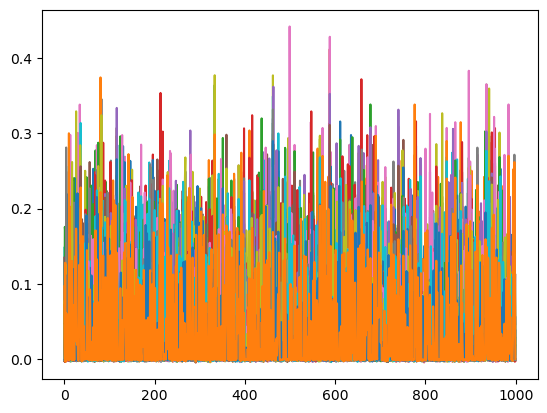

In [ ]:
trainer = Trainer(
    generator=g,
    discriminator=d,
    batch_size=32,
    num_epochs=3000,
    label=1
)
trainer.run()

In [16]:
import torch
torch.cuda.is_available()

True

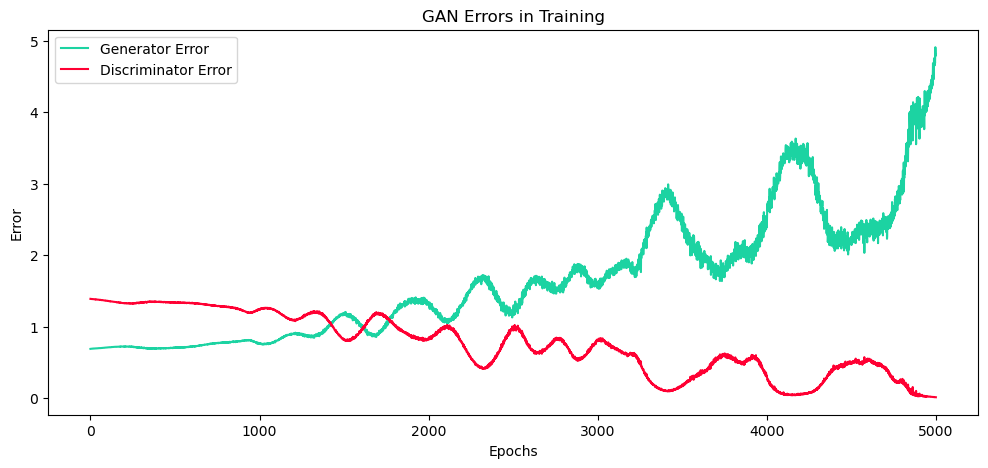

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.title("GAN Errors in Training")
plt.plot(trainer.g_errors, label='Generator Error', c='#1CD3A2')
plt.plot(trainer.d_errors, label='Discriminator Error', c='#FF0033')
plt.xlabel("Epochs")
plt.ylabel('Error')
_ = plt.legend()
plt.savefig('Gan_Losses.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('Gan_Losses.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [12]:
noise = torch.randn(96, 1, 1000, device=device)

In [16]:
g.to(device)
g.load_state_dict(torch.load('./weights/1/generator.pth'))
g.eval()

Generator(
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1000, bias=True)
  (rnn_layer): LSTM(1000, 128, batch_first=True, bidirectional=True)
)

In [74]:
fake = g(noise)
fake.shape

torch.Size([96, 1, 1000])

In [77]:
index = np.random.choice(fake.shape[0], 1, replace=False) 
synthetic_samples = fake.detach().cpu().squeeze(1).numpy()[0].transpose()

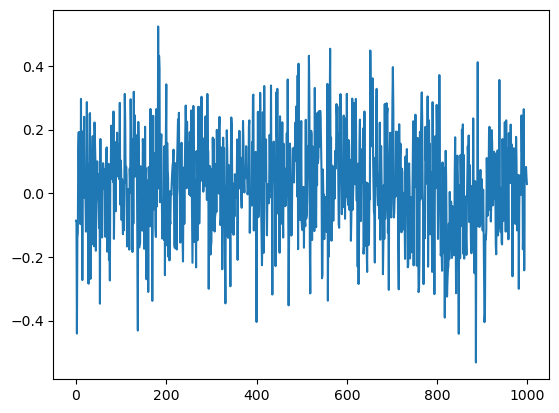

In [78]:
plt.plot(synthetic_samples)
plt.show()

tensor([[[-0.1190, -0.1160, -0.1200,  ...,  0.0690,  0.0860,  0.0220]],

        [[ 0.0040, -0.0200, -0.0530,  ...,  0.1210, -0.3260, -0.3480]],

        [[-0.0290, -0.0350, -0.0540,  ..., -0.0290, -0.0480, -0.0490]],

        ...,

        [[-0.0650, -0.0670, -0.0730,  ..., -0.0490, -0.0580, -0.0580]],

        [[ 0.1510,  0.1230,  0.0970,  ..., -0.1310, -0.1430, -0.1320]],

        [[ 0.2650,  0.2630,  0.2420,  ...,  0.2740,  0.2160,  0.1750]]],
       device='cuda:0')


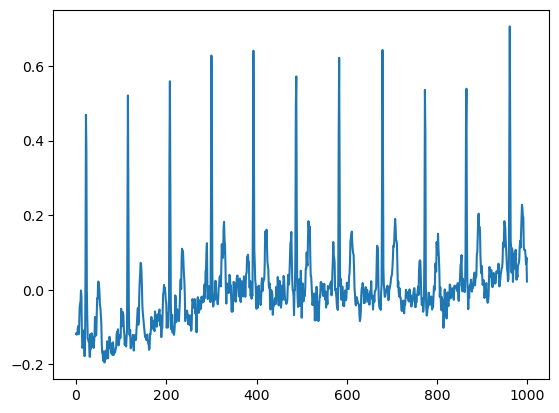

tensor([[[ 0.0340,  0.0350,  0.0410,  ..., -0.1050, -0.0840,  0.2790]],

        [[-0.0140, -0.0080, -0.0050,  ..., -0.0850, -0.0780,  0.0020]],

        [[ 0.0100,  0.0100,  0.0140,  ..., -0.0810, -0.0720, -0.0810]],

        ...,

        [[-0.0390, -0.0360, -0.0440,  ..., -0.0540, -0.0630, -0.0490]],

        [[ 0.0930,  0.1090,  0.1200,  ..., -0.0450, -0.0450, -0.0470]],

        [[ 0.0360,  0.0640,  0.0590,  ..., -0.0930, -0.0710, -0.0600]]],
       device='cuda:0')


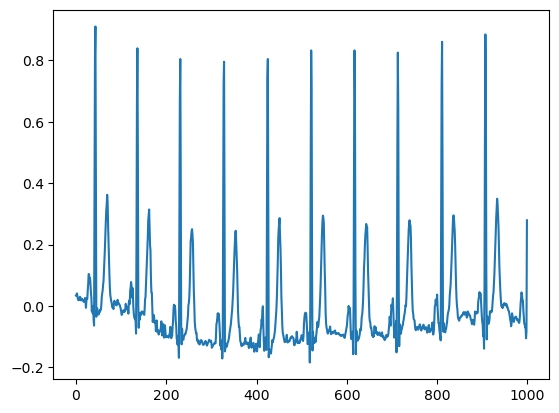

tensor([[[-0.0900, -0.0910, -0.0880,  ...,  0.0950,  0.1390,  0.1620]],

        [[ 0.0350,  0.0310,  0.0120,  ..., -0.0610, -0.0610, -0.0730]],

        [[-0.1250, -0.1230, -0.1210,  ...,  0.1800,  0.1420,  0.1190]],

        ...,

        [[-0.0390, -0.0300, -0.0180,  ..., -0.1010, -0.0960, -0.0740]],

        [[ 0.4030,  0.3770,  0.2920,  ...,  0.3420,  0.3470,  0.3260]],

        [[-0.0380, -0.0640, -0.0730,  ...,  0.0200,  0.0200,  0.0250]]],
       device='cuda:0')


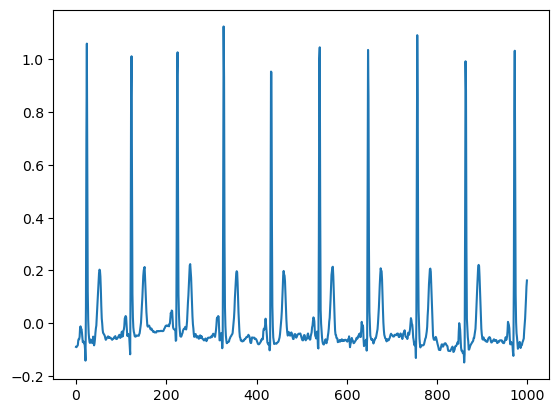

tensor([[[-0.2150, -0.1540,  0.2940,  ...,  0.0930,  0.0870,  0.0730]],

        [[ 0.1550,  0.1480,  0.1400,  ...,  0.0680,  0.0320,  0.0040]],

        [[ 0.0510, -0.0030,  0.0020,  ...,  0.0650,  0.0630,  0.0550]],

        ...,

        [[ 0.0750,  0.0780,  0.0840,  ...,  0.1030,  0.0230, -0.0290]],

        [[-0.0700, -0.0700, -0.0700,  ..., -0.1390, -0.1370, -0.1290]],

        [[-0.2320, -0.2440, -0.2150,  ..., -0.1970, -0.0170,  0.2680]]],
       device='cuda:0')


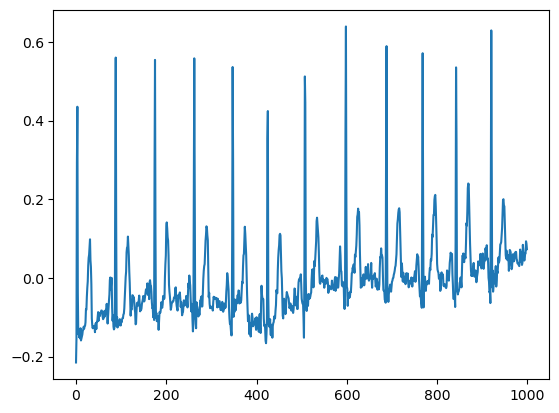

tensor([[[ 0.5050,  0.6870,  0.5650,  ...,  0.0250,  0.0080, -0.0210]],

        [[ 0.0680,  0.0730,  0.0920,  ..., -0.0360,  0.0090,  0.5020]],

        [[-0.2210, -0.2750, -0.2620,  ...,  0.0260,  0.0360,  0.0450]],

        ...,

        [[ 0.0640,  0.0400, -0.0110,  ..., -0.5730, -0.6070, -0.5760]],

        [[ 0.0330, -0.0060, -0.0330,  ...,  0.0220, -0.0560, -0.3500]],

        [[-0.2020, -0.1610, -0.1520,  ..., -0.1290, -0.0630, -0.0540]]],
       device='cuda:0')


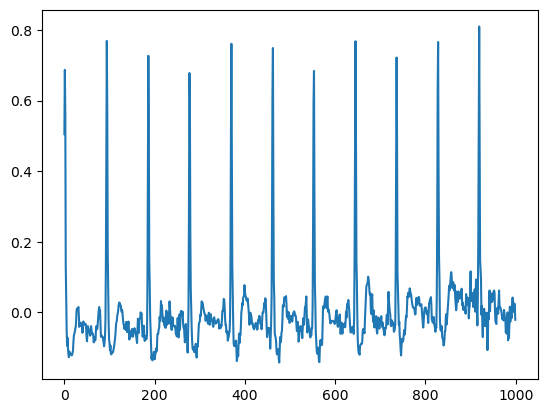

tensor([[[ 0.3410,  0.1760, -0.0320,  ..., -0.0210, -0.0510, -0.0730]],

        [[-0.0500, -0.0470, -0.0450,  ..., -0.0950, -0.1030, -0.0920]],

        [[-0.0150, -0.0160, -0.0170,  ...,  0.1410,  0.1800,  0.1980]],

        ...,

        [[ 0.1450,  0.1510,  0.1510,  ...,  0.0390,  0.0620,  0.0860]],

        [[-0.0750, -0.0730, -0.0690,  ..., -0.0240, -0.0290, -0.0380]],

        [[ 0.0480,  0.0320,  0.0120,  ..., -0.0130,  0.0030,  0.0020]]],
       device='cuda:0')


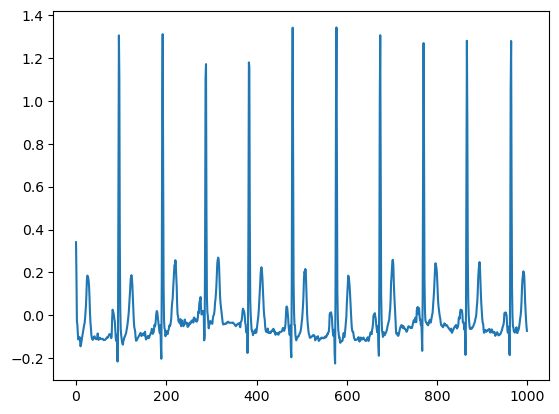

tensor([[[ 0.0300,  0.0350,  0.0350,  ..., -0.0480, -0.0450, -0.0440]],

        [[ 0.0450,  0.0450,  0.0350,  ..., -0.0800, -0.0810, -0.0770]],

        [[-0.0400, -0.0440, -0.0470,  ..., -0.1250, -0.0590, -0.0880]],

        ...,

        [[-0.1250, -0.1230, -0.1200,  ..., -0.0230,  0.0130,  0.0370]],

        [[-0.0780, -0.0450,  0.0100,  ...,  0.0810,  0.0540,  0.1200]],

        [[ 0.0100,  0.0020, -0.0020,  ...,  0.0040, -0.1650, -0.1010]]],
       device='cuda:0')


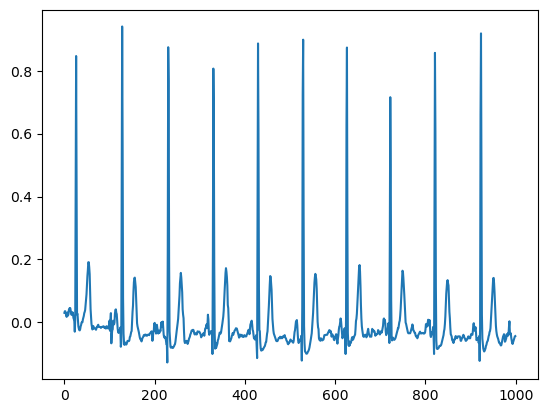

tensor([[[-0.0220, -0.0320, -0.0300,  ...,  0.0590, -0.0500,  0.0360]],

        [[ 0.0790,  0.0810,  0.0750,  ...,  0.0840,  0.6920,  0.7880]],

        [[ 0.0970,  0.0790,  0.0610,  ...,  0.1040,  0.1120,  0.1080]],

        ...,

        [[ 0.0170,  0.0250,  0.0340,  ...,  0.1390,  0.6610,  0.7540]],

        [[ 0.0350,  0.0350,  0.0350,  ..., -0.0050, -0.1030, -0.2650]],

        [[-0.0700, -0.1000, -0.1010,  ...,  0.1470,  0.0980,  0.0720]]],
       device='cuda:0')


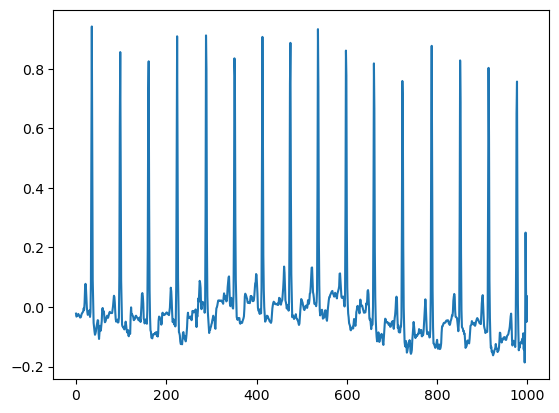

tensor([[[-0.0050,  0.0110,  0.0620,  ...,  0.2360,  0.2160,  0.1440]],

        [[-0.2550, -0.2580, -0.2650,  ..., -0.0610, -0.1380, -0.2100]],

        [[-0.1480, -0.1440, -0.1620,  ...,  0.0110,  0.0090,  0.0340]],

        ...,

        [[-0.0020, -0.0150, -0.0690,  ..., -0.0330, -0.0090,  0.0100]],

        [[-0.0670, -0.0460, -0.0330,  ..., -0.0070,  0.2310,  0.2770]],

        [[-0.2000, -0.1980, -0.0410,  ...,  0.0420,  0.0560,  0.0260]]],
       device='cuda:0')


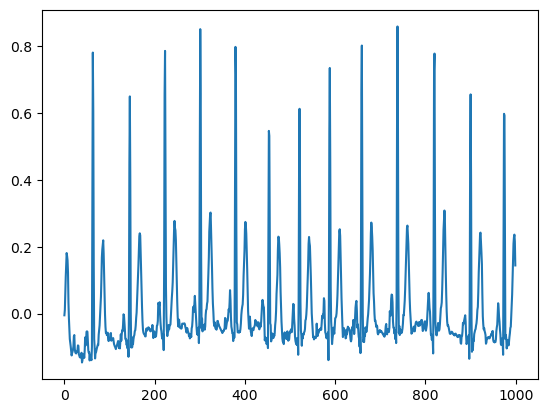

tensor([[[-0.3140, -0.3040, -0.3230,  ...,  1.4730,  0.6190,  0.1750]],

        [[-0.0850, -0.0850, -0.0850,  ..., -0.0680, -0.0740, -0.0490]],

        [[ 0.0730,  0.0550,  0.0560,  ...,  0.0090,  0.0030,  0.0200]],

        ...,

        [[ 0.0300, -0.0080, -0.0090,  ..., -0.0510, -0.0730,  0.1020]],

        [[-0.0950, -0.0720, -0.0800,  ..., -0.0410, -0.0840,  0.0960]],

        [[ 0.0200,  0.0500,  0.0730,  ...,  0.0430,  0.0560,  0.0670]]],
       device='cuda:0')


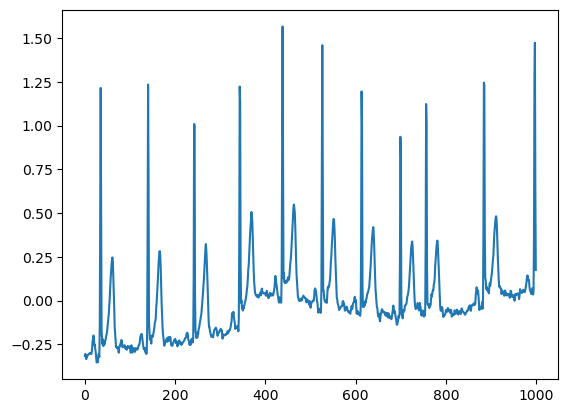

tensor([[[-0.0460, -0.0530, -0.0300,  ...,  0.0080,  0.0280,  0.0350]],

        [[ 0.0390,  0.0260, -0.0060,  ...,  0.0420,  0.0450,  0.0450]],

        [[-0.1000, -0.1020, -0.1040,  ..., -0.0390, -0.0530, -0.0480]],

        ...,

        [[ 0.1000,  0.0360,  0.0210,  ..., -0.0200, -0.0620,  0.0160]],

        [[ 0.3850,  0.3850,  0.3850,  ..., -0.1300, -0.1270, -0.1300]],

        [[ 0.1180,  0.0970,  0.0400,  ..., -0.1250, -0.1100, -0.1090]]],
       device='cuda:0')


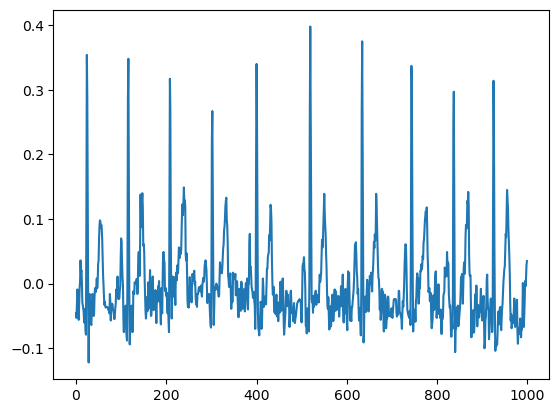

tensor([[[ 0.2250,  0.1910,  0.1950,  ..., -0.1650, -0.2040, -0.1510]],

        [[-0.1140, -0.1250, -0.1060,  ..., -0.0350, -0.0340, -0.0520]],

        [[ 0.0220,  0.0210,  0.0110,  ..., -0.0410, -0.1600,  0.1390]],

        ...,

        [[-0.0010, -0.0050, -0.0060,  ..., -0.0090, -0.0060,  0.1420]],

        [[-0.1180, -0.1150, -0.0820,  ..., -0.0120,  0.0130,  0.0420]],

        [[ 0.1030,  0.1270,  0.1380,  ..., -0.1090, -0.0970, -0.0870]]],
       device='cuda:0')


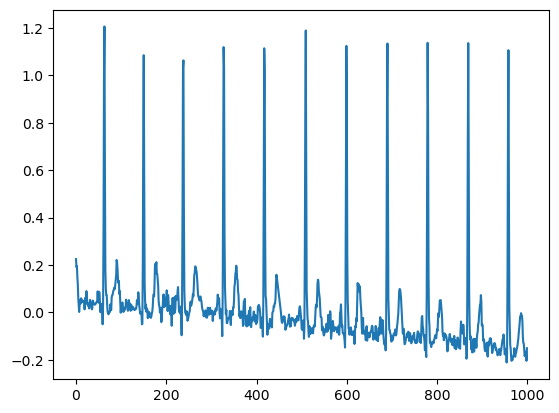

tensor([[[ 0.0790,  0.0740,  0.0660,  ...,  0.1060, -0.3270, -0.4020]],

        [[-0.0460, -0.0460, -0.0340,  ...,  0.0580,  0.1030,  0.1160]],

        [[ 0.1110,  0.1190,  0.1380,  ...,  0.6580,  0.4530,  0.0860]],

        ...,

        [[ 0.0440, -0.2660, -0.7930,  ..., -0.0650,  0.0640,  0.4830]],

        [[ 0.4230,  0.1680, -0.0800,  ..., -0.0840, -0.0760, -0.0810]],

        [[-0.0850, -0.1110, -0.0860,  ..., -0.0100,  0.0020, -0.0060]]],
       device='cuda:0')


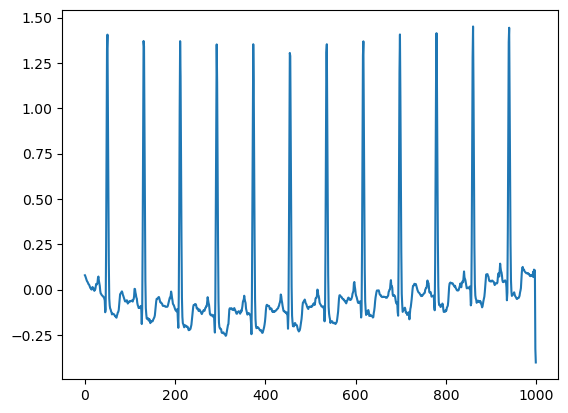

tensor([[[ 0.0610,  0.0610,  0.0580,  ..., -0.0770, -0.0620, -0.1370]],

        [[-0.0950, -0.0950, -0.0950,  ...,  0.0180,  0.0150,  0.0170]],

        [[-0.0520, -0.0800, -0.1010,  ...,  0.0320,  0.0840,  0.0460]],

        ...,

        [[ 0.0200,  0.0220,  0.0230,  ...,  0.0250,  0.0410,  0.0590]],

        [[ 0.1210,  0.1130,  0.0720,  ..., -0.1040, -0.0560, -0.0580]],

        [[-0.0490, -0.0710, -0.0750,  ..., -0.1170, -0.1270, -0.0990]]],
       device='cuda:0')


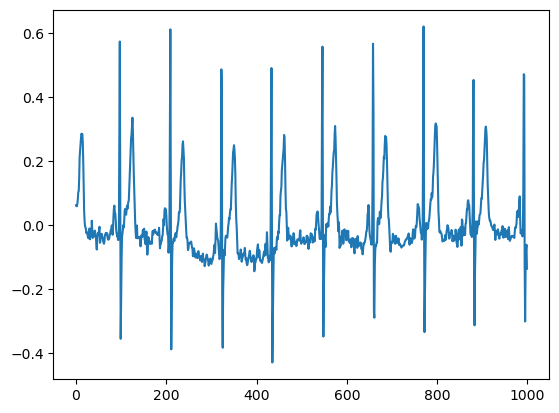

tensor([[[ 0.0460,  0.0400,  0.0360,  ..., -0.2490, -0.2420, -0.2450]],

        [[ 0.1300,  0.1580,  0.1970,  ..., -0.0740,  0.1810,  0.1270]],

        [[-0.0790, -0.0730, -0.0600,  ...,  0.0070, -0.0040,  0.0420]],

        ...,

        [[ 0.0030, -0.0100, -0.0190,  ...,  0.0440,  0.0400,  0.0330]],

        [[-0.0340, -0.0280, -0.0440,  ..., -0.0110, -0.0030, -0.0050]],

        [[-0.0090, -0.0050, -0.0030,  ..., -0.0620, -0.0630, -0.0110]]],
       device='cuda:0')


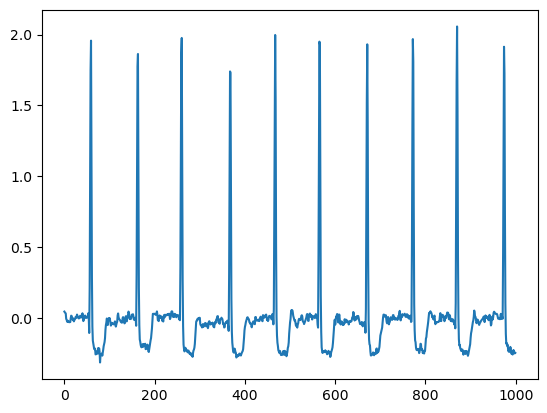

tensor([[[-0.1420, -0.1430, -0.1580,  ..., -0.1000, -0.0630, -0.0870]],

        [[-0.1270, -0.1270, -0.1310,  ...,  0.1280,  0.0330, -0.1200]],

        [[ 0.3430,  0.2200,  0.1200,  ..., -0.1150, -0.1140, -0.1130]],

        ...,

        [[ 0.0850,  0.0850,  0.0850,  ..., -0.0340,  0.0640, -0.3860]],

        [[ 0.1930,  0.0410, -0.1250,  ...,  0.0970,  0.0580,  0.0200]],

        [[-0.0320, -0.0210, -0.0100,  ..., -0.1150, -0.0950,  0.2020]]],
       device='cuda:0')


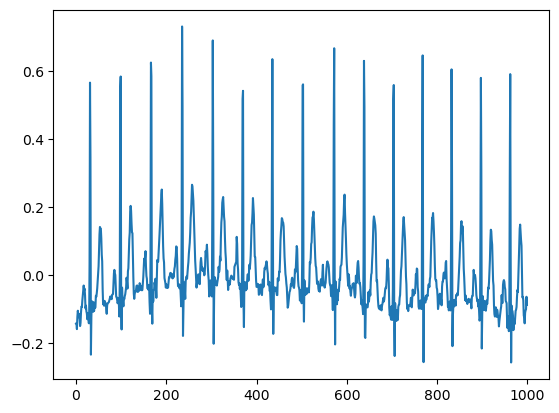

tensor([[[ 0.0100,  0.0170,  0.0360,  ...,  0.2230,  0.3430,  0.4180]],

        [[-0.1400, -0.1410, -0.1360,  ..., -0.0660, -0.0750, -0.0450]],

        [[-0.1440, -0.1420, -0.1370,  ...,  0.3840,  0.3710,  0.3530]],

        ...,

        [[ 0.0860,  0.0990,  0.1080,  ..., -0.0450, -0.0460, -0.0420]],

        [[-0.0570, -0.0690, -0.0640,  ..., -0.0710, -0.1030,  0.0260]],

        [[-0.0250, -0.0290, -0.0320,  ..., -0.0240,  0.2340,  0.4370]]],
       device='cuda:0')


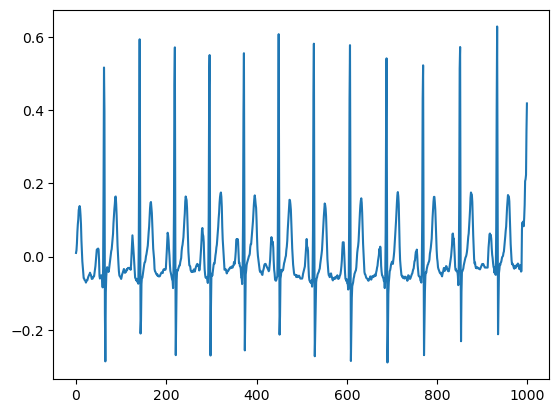

tensor([[[ 0.4840,  0.3200,  0.0730,  ...,  0.0540,  0.0510,  0.0270]],

        [[-0.0400, -0.0390, -0.0170,  ...,  0.0530,  0.1540,  0.2270]],

        [[ 0.0590,  0.0610,  0.0680,  ..., -0.0550, -0.0920, -0.0680]],

        ...,

        [[-0.1720, -0.1670, -0.1310,  ..., -0.1580, -0.1660, -0.1730]],

        [[-0.0840, -0.0820, -0.0750,  ...,  0.0200,  0.0130, -0.0080]],

        [[-0.1230, -0.0140,  0.4460,  ..., -0.0070,  0.0150,  0.0180]]],
       device='cuda:0')


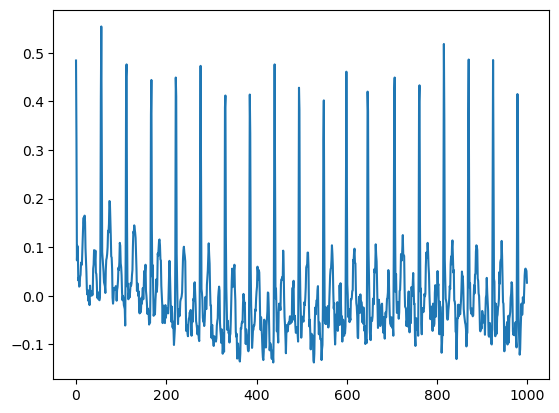

tensor([[[ 0.0180,  0.0160,  0.0250,  ..., -0.0940, -0.0530, -0.0130]],

        [[-0.0150, -0.0150, -0.0150,  ..., -0.0470, -0.0440, -0.0400]],

        [[ 0.0050,  0.0040,  0.0030,  ..., -0.0540, -0.0240, -0.0390]],

        ...,

        [[-0.1250, -0.1320, -0.1130,  ..., -0.0570, -0.0590, -0.0690]],

        [[ 0.3430,  0.3400,  0.3370,  ...,  0.0960,  0.1580,  0.4910]],

        [[-0.0400, -0.0100, -0.0090,  ..., -0.0590, -0.0670, -0.0590]]],
       device='cuda:0')


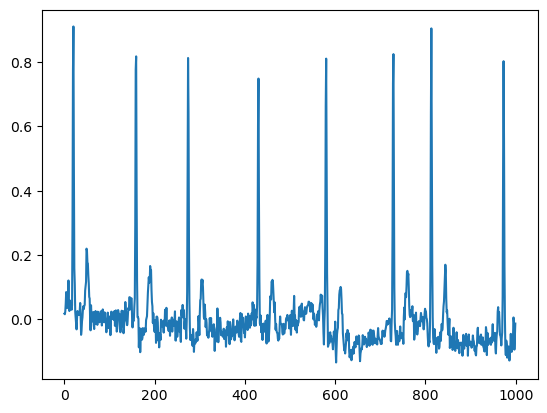

tensor([[[-0.1300, -0.1310, -0.1320,  ..., -0.0600, -0.0560, -0.0520]],

        [[ 0.0050,  0.0050,  0.0040,  ..., -0.1880, -0.2340, -0.2490]],

        [[-0.0550, -0.0590, -0.0690,  ..., -0.0250, -0.0380, -0.0330]],

        ...,

        [[-0.1480, -0.1250, -0.0880,  ...,  0.0410,  0.0290,  0.1290]],

        [[-0.0340, -0.0240, -0.0060,  ..., -0.0630, -0.0680, -0.1160]],

        [[ 0.1880,  0.2070,  0.2470,  ..., -0.0630, -0.0790,  0.0100]]],
       device='cuda:0')


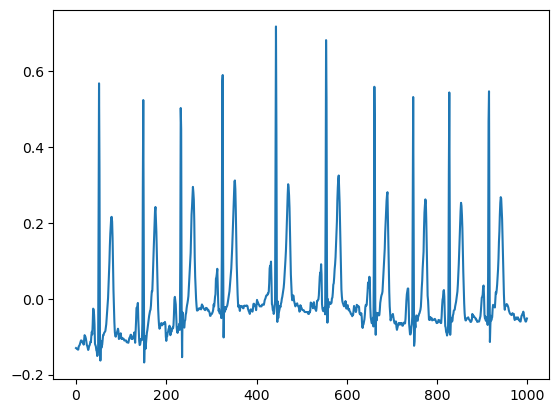

tensor([[[-0.0310, -0.0360, -0.0330,  ...,  0.0120,  0.0130,  0.0990]],

        [[ 0.0920,  0.0940,  0.0900,  ..., -0.2020, -0.2220, -0.1900]],

        [[ 0.0200,  0.0110, -0.0010,  ..., -0.0250, -0.0330, -0.0470]],

        ...,

        [[ 0.0580,  0.0980,  0.1460,  ..., -0.0070, -0.0080, -0.0300]],

        [[ 0.1600,  0.2020,  0.2300,  ..., -0.1330, -0.1630,  0.0550]],

        [[-0.0500, -0.0480, -0.0490,  ..., -0.0430, -0.0660, -0.0990]]],
       device='cuda:0')


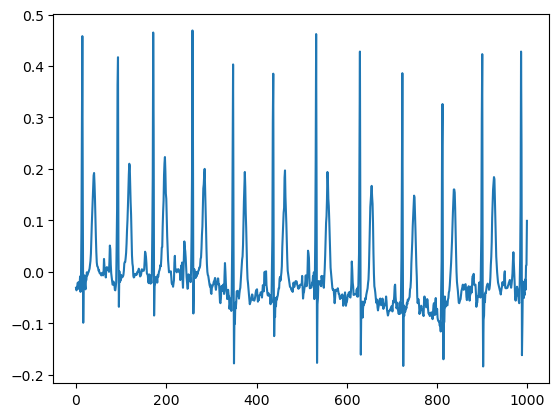

tensor([[[-0.0550, -0.0550, -0.0540,  ...,  0.3760,  0.0800, -0.0720]],

        [[-0.0350, -0.0390, -0.0460,  ..., -0.0850, -0.0950, -0.0970]],

        [[-0.1760, -0.1690, -0.1700,  ..., -0.1200, -0.1190, -0.0980]],

        ...,

        [[ 0.0050, -0.0130, -0.0220,  ..., -0.0500, -0.0370, -0.0050]],

        [[-0.0290, -0.0250, -0.0250,  ..., -0.1080, -0.1210, -0.1610]],

        [[-0.1880, -0.1870, -0.2110,  ..., -0.1510, -0.1940, -0.1720]]],
       device='cuda:0')


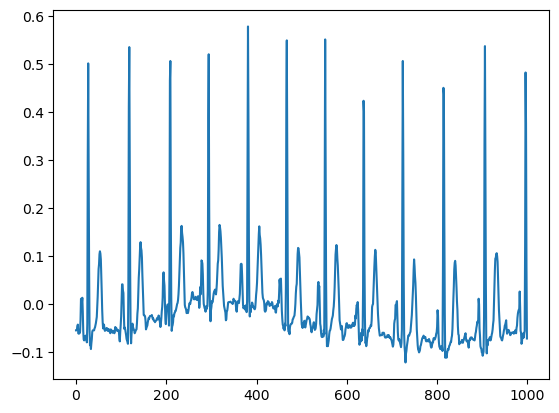

tensor([[[ 0.0300,  0.0420,  0.0670,  ...,  0.0110,  0.0140,  0.0170]],

        [[-0.0290, -0.0280, -0.0220,  ..., -0.0140, -0.0180, -0.0200]],

        [[-0.1140, -0.1180, -0.1310,  ..., -0.0620, -0.0710, -0.0960]],

        ...,

        [[-0.0450, -0.0450, -0.0450,  ..., -0.2030, -0.1920, -0.2070]],

        [[-0.3910, -0.3010, -0.1540,  ..., -0.0590,  0.0010, -0.0480]],

        [[-0.0510, -0.0350, -0.0430,  ..., -0.0220,  0.0050,  0.0060]]],
       device='cuda:0')


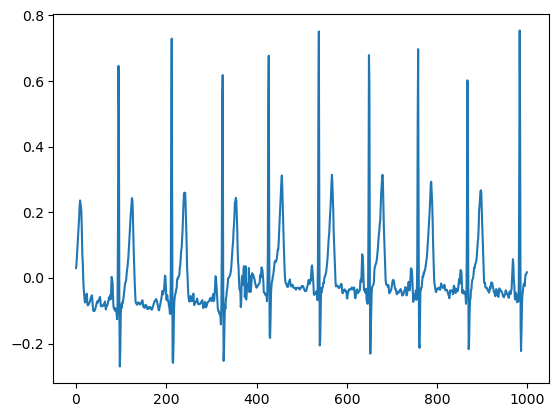

tensor([[[-0.0630, -0.0590, -0.0850,  ...,  0.0400,  0.0390, -0.0250]],

        [[-0.1050, -0.0880, -0.0570,  ..., -0.0230, -0.0210, -0.0300]],

        [[-0.0890, -0.0740, -0.0720,  ..., -0.1020, -0.1050, -0.1110]],

        ...,

        [[-0.1100, -0.1040, -0.1030,  ...,  0.0330,  0.0360,  0.1680]],

        [[ 0.0320,  0.0450,  0.0430,  ...,  0.2290,  0.2300,  0.1060]],

        [[ 0.0880,  0.0810,  0.0870,  ..., -0.0720, -0.1940, -0.2670]]],
       device='cuda:0')


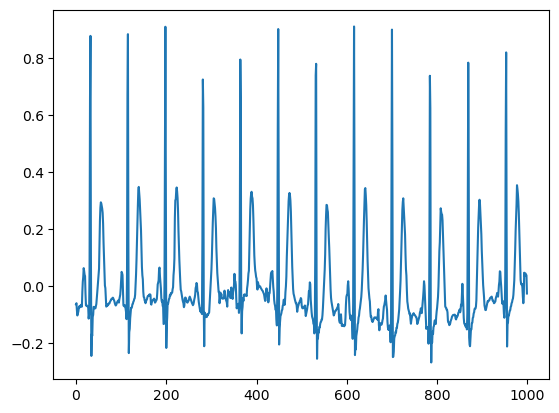

tensor([[[-0.0960, -0.0890, -0.0870,  ...,  1.2610,  1.9230,  1.8660]],

        [[-0.1340, -0.1400, -0.1480,  ...,  0.0790,  0.0900,  0.0800]],

        [[-0.0660, -0.0620, -0.0330,  ..., -0.1080, -0.1050, -0.0890]],

        ...,

        [[ 0.1540,  0.1540,  0.1760,  ...,  0.1940,  0.2010,  0.2080]],

        [[ 0.0430, -0.0900, -0.1490,  ..., -0.0550, -0.0670, -0.0510]],

        [[-0.0530, -0.0570, -0.0240,  ...,  0.0820,  0.0880,  0.1140]]],
       device='cuda:0')


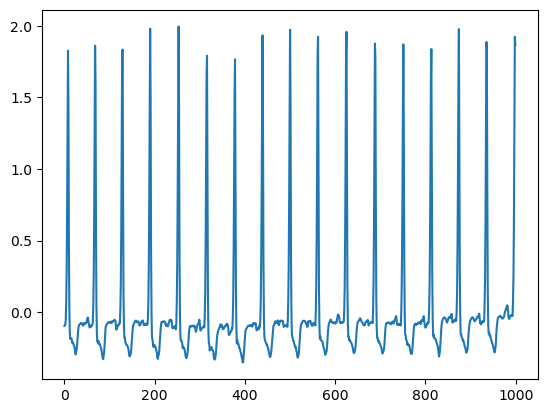

tensor([[[ 0.0130,  0.0090,  0.0140,  ..., -0.0060, -0.0310, -0.0070]],

        [[ 0.0060, -0.0030, -0.0130,  ...,  0.0730,  0.3730,  0.3430]],

        [[ 0.1600,  0.1450,  0.1250,  ...,  0.0970,  0.1180,  0.1290]],

        ...,

        [[-0.0500, -0.0490, -0.0410,  ..., -0.0290, -0.0140,  0.0650]],

        [[-0.0680, -0.1840, -0.3610,  ...,  0.2530,  0.3180,  0.2870]],

        [[-0.0330, -0.0650, -0.0900,  ..., -0.0490, -0.0200,  0.1110]]],
       device='cuda:0')


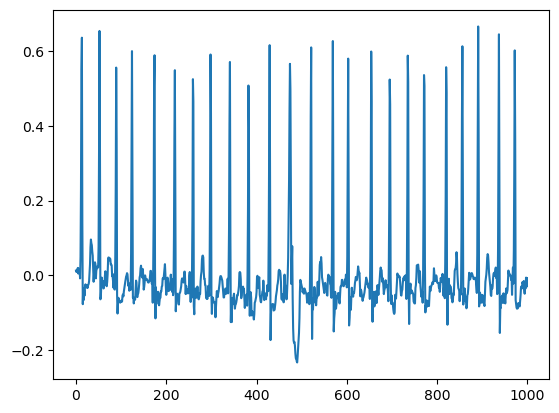

tensor([[[-0.2870, -0.2830, -0.2470,  ..., -0.2620, -0.2620, -0.2720]],

        [[-0.0300, -0.0300, -0.0300,  ...,  0.0820,  0.1640,  0.4120]],

        [[-0.1450, -0.1450, -0.1460,  ..., -0.0520, -0.0740, -0.0770]],

        ...,

        [[ 0.0030, -0.0030,  0.0150,  ..., -0.0910, -0.0560, -0.0470]],

        [[ 0.0230,  0.0260,  0.0220,  ...,  0.1040,  0.0990,  0.1830]],

        [[ 0.6630,  0.3540, -0.1080,  ..., -0.0380, -0.0310, -0.0020]]],
       device='cuda:0')


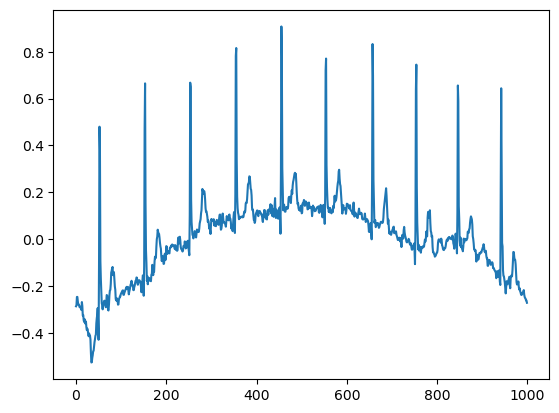

tensor([[[-0.0670, -0.0840, -0.0770,  ..., -0.0620, -0.0480, -0.0410]],

        [[ 0.0290,  0.0120, -0.0020,  ..., -0.0500, -0.1000, -0.1020]],

        [[ 0.0240,  0.0320,  0.0350,  ...,  0.0120,  0.4070,  0.6420]],

        ...,

        [[ 0.4530,  0.4890,  0.4860,  ..., -0.1330, -0.0990, -0.0900]],

        [[ 0.0010, -0.0020, -0.0180,  ..., -0.0020,  0.0450,  0.0710]],

        [[-0.0870, -0.0940, -0.1190,  ...,  0.0150, -0.0020, -0.0030]]],
       device='cuda:0')


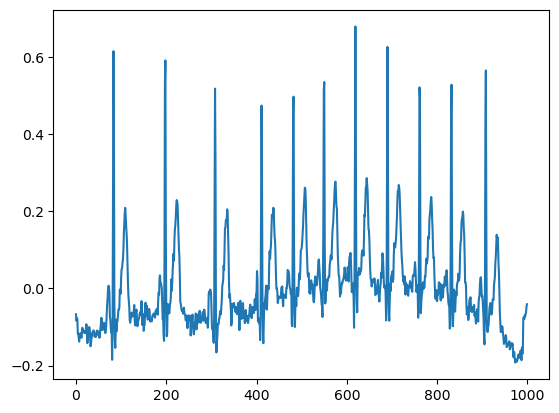

tensor([[[ 0.0390,  0.0260, -0.0180,  ..., -0.1110, -0.2220, -0.0430]],

        [[-0.1270, -0.1210, -0.1230,  ..., -0.0430, -0.0480, -0.0440]],

        [[-0.0980, -0.0830, -0.0730,  ...,  0.2080,  0.2270,  0.2710]],

        ...,

        [[ 0.1150,  0.1150,  0.1120,  ..., -0.0180, -0.0620, -0.0870]],

        [[-0.0040,  0.0030,  0.0060,  ...,  0.0120,  0.1460,  0.1760]],

        [[-0.0270, -0.0120, -0.0180,  ..., -0.0490, -0.0500, -0.0570]]],
       device='cuda:0')


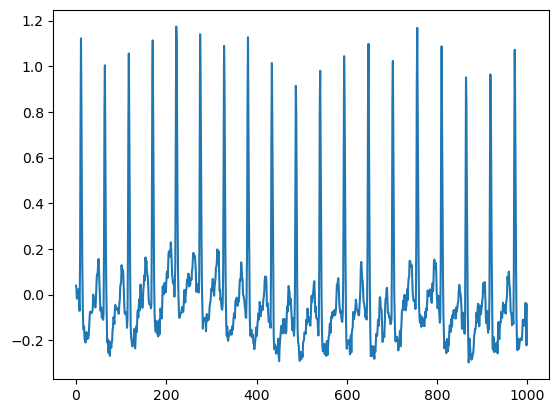

tensor([[[-0.0010, -0.0170, -0.0370,  ...,  0.0280,  0.0500,  0.0450]],

        [[ 0.1930,  0.1780,  0.1200,  ...,  0.0690,  0.1120,  0.0740]],

        [[-0.0020, -0.0040,  0.0040,  ...,  0.1350,  0.1070,  0.0940]],

        ...,

        [[ 0.0280,  0.0460,  0.0600,  ..., -0.0660, -0.1010, -0.0580]],

        [[ 0.0010,  0.0140,  0.0130,  ...,  0.0810, -0.0310,  0.2710]],

        [[-0.0550, -0.0550, -0.0580,  ...,  0.0970,  0.3310, -0.1470]]],
       device='cuda:0')


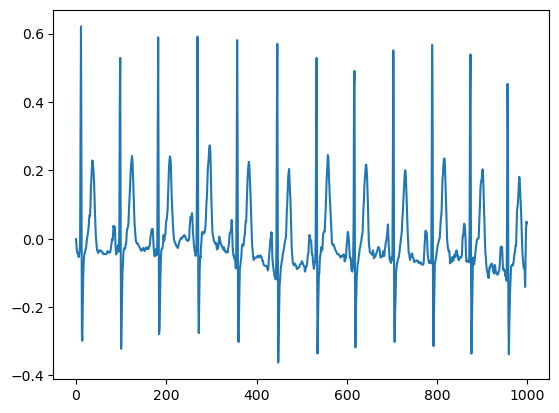

tensor([[[-0.2400, -0.3120, -0.3190,  ..., -0.1100, -0.0950, -0.1000]],

        [[-0.0060,  0.0000,  0.0070,  ..., -0.1190, -0.0610, -0.6040]],

        [[ 0.2590,  0.2640,  0.2670,  ..., -0.3370, -0.3310, -0.3770]],

        ...,

        [[-0.1500, -0.1500, -0.1500,  ..., -0.0400, -0.0400, -0.0400]],

        [[ 0.0400,  0.0390,  0.0430,  ...,  0.0600,  0.0670,  0.0630]],

        [[ 0.0410,  0.0230, -0.0090,  ..., -0.0130,  0.0210,  0.0440]]],
       device='cuda:0')


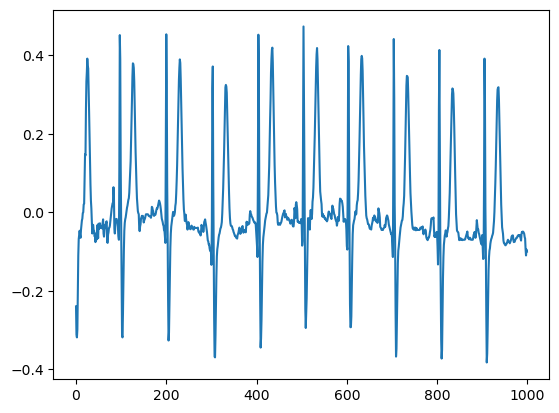

tensor([[[-0.0450, -0.0450, -0.0500,  ..., -0.0450, -0.0400, -0.0240]],

        [[-0.0350, -0.0350, -0.0350,  ..., -0.0080,  0.0210,  0.1330]],

        [[-0.3200, -0.3200, -0.3200,  ...,  0.1520,  0.1460,  0.1440]],

        ...,

        [[ 0.0070,  0.0420,  0.0880,  ..., -0.1150, -0.0990, -0.0870]],

        [[-0.0420, -0.0820, -0.0550,  ...,  0.1440,  0.2700,  0.2940]],

        [[ 0.0010,  0.0040, -0.0020,  ...,  0.1590,  0.1310,  0.1660]]],
       device='cuda:0')


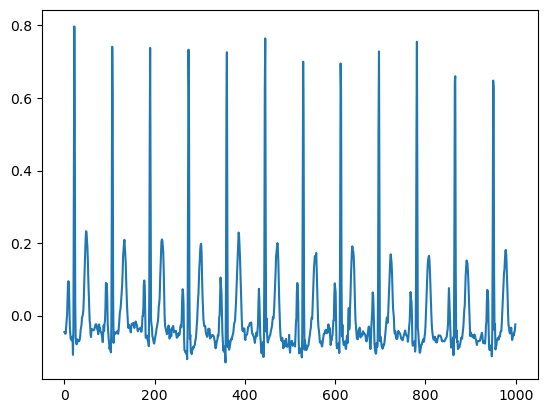

tensor([[[-0.1000, -0.1140, -0.1250,  ...,  0.0330,  0.0180,  0.0080]],

        [[ 0.0500,  0.0640,  0.0970,  ..., -0.0650, -0.0730, -0.0730]],

        [[-0.0450, -0.0500, -0.0570,  ...,  0.0070,  0.0520,  0.3090]],

        ...,

        [[-0.0750, -0.0730, -0.0660,  ..., -0.0160, -0.0110,  0.0170]],

        [[ 0.1140,  0.1000,  0.1040,  ..., -0.2930, -0.2850, -0.2890]],

        [[-0.1800, -0.1790, -0.1810,  ...,  0.3970,  0.3820,  0.3610]]],
       device='cuda:0')


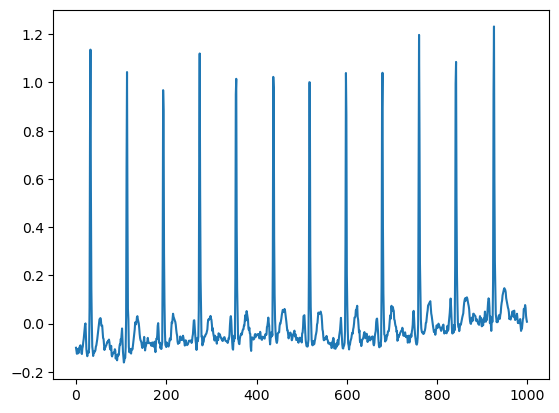

tensor([[[-0.0230, -0.0370,  0.0290,  ..., -0.1550, -0.1010, -0.1180]],

        [[ 0.0450,  0.0160, -0.0400,  ...,  0.0260,  0.0100,  0.0300]],

        [[ 0.0000,  0.0000, -0.0090,  ..., -0.0390, -0.1190, -0.2330]],

        ...,

        [[-0.0060, -0.0160, -0.0310,  ...,  0.0890,  0.0950,  0.0880]],

        [[ 0.0230,  0.0060, -0.0100,  ..., -0.0710, -0.0340, -0.0720]],

        [[-0.0200, -0.0210, -0.0240,  ..., -0.0390, -0.0380, -0.0320]]],
       device='cuda:0')


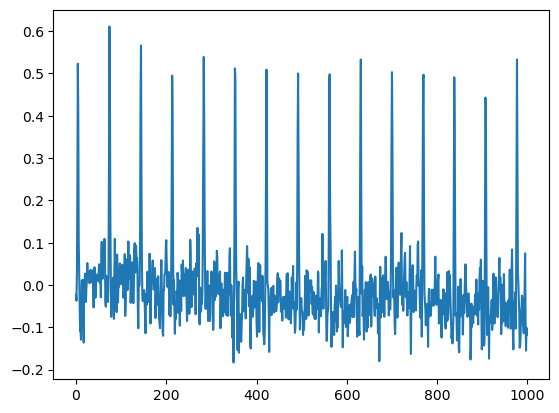

tensor([[[ 0.1450,  0.1450,  0.1440,  ..., -0.2720, -0.2830, -0.2900]],

        [[ 0.0170, -0.0050, -0.0180,  ...,  0.0270, -0.0300,  0.1120]],

        [[ 0.0100,  0.0100,  0.0100,  ...,  0.0760,  0.1040,  0.1320]],

        ...,

        [[-0.0690, -0.1290, -0.1230,  ..., -0.0720, -0.0670, -0.0650]],

        [[-0.1600, -0.1350, -0.0420,  ...,  0.1720, -0.1210, -0.1120]],

        [[-0.0250, -0.0370, -0.0090,  ..., -0.0670, -0.1080, -0.0390]]],
       device='cuda:0')


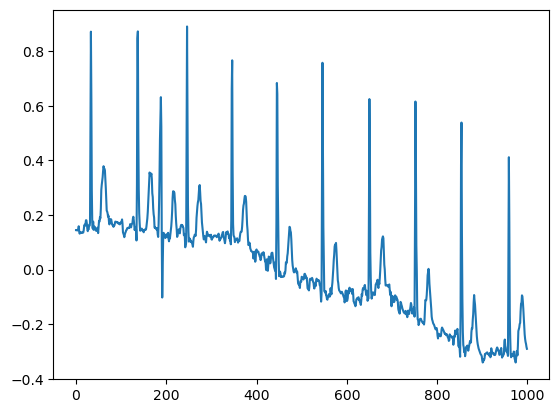

tensor([[[-0.0450, -0.0440, -0.0410,  ..., -0.0590, -0.1100, -0.0970]],

        [[-0.0360, -0.0310, -0.0080,  ..., -0.7960, -1.4440, -1.2570]],

        [[ 0.3000,  0.2970,  0.2660,  ..., -0.3930, -0.4000, -0.4000]],

        ...,

        [[-0.1250, -0.1180, -0.1070,  ..., -0.0410,  0.2080,  0.1570]],

        [[-0.1070, -0.0920, -0.1070,  ...,  0.3240, -0.0140, -0.1430]],

        [[ 0.0340,  0.0270,  0.0190,  ..., -0.0070, -0.0160,  0.0080]]],
       device='cuda:0')


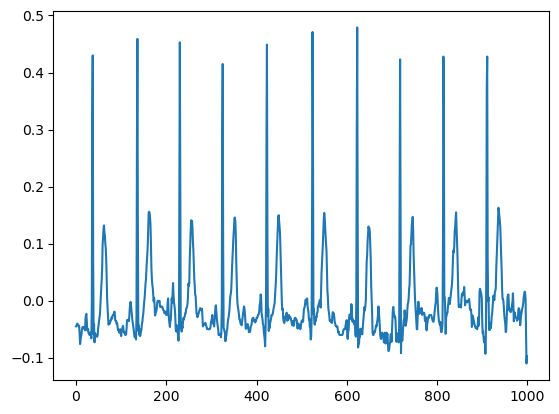

tensor([[[ 0.0350,  0.0430,  0.0620,  ..., -0.2620, -0.1980, -0.1490]],

        [[ 0.1260,  0.1020,  0.0760,  ...,  0.0830,  0.0650,  0.0670]],

        [[-0.1450, -0.1460, -0.1320,  ...,  0.0430,  0.0670,  0.0700]],

        ...,

        [[ 0.0920,  0.0720,  0.0670,  ..., -0.0600, -0.0410, -0.0350]],

        [[ 0.4640,  0.4500,  0.4310,  ...,  0.1100,  0.1060,  0.1040]],

        [[ 0.0200,  0.0200,  0.0200,  ...,  0.0730,  0.0780,  0.1130]]],
       device='cuda:0')


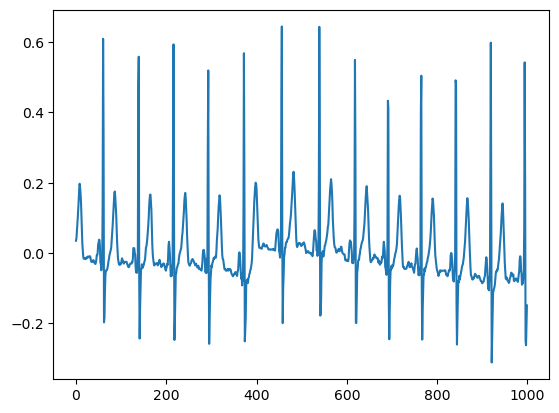

tensor([[[ 0.1440,  0.1250,  0.0980,  ...,  0.1270,  0.2140,  0.1520]],

        [[ 0.0030,  0.0100, -0.0150,  ...,  0.3520,  0.3330,  0.0830]],

        [[-0.0730, -0.0370,  0.0030,  ..., -0.0390, -0.0460, -0.3840]],

        ...,

        [[ 0.1110,  0.1160,  0.2070,  ..., -0.2590, -0.2400, -0.2200]],

        [[-0.0430, -0.0540, -0.0650,  ...,  0.0600, -0.0150,  0.0270]],

        [[-0.2310, -0.2300, -0.3020,  ..., -0.0590, -0.0600, -0.0500]]],
       device='cuda:0')


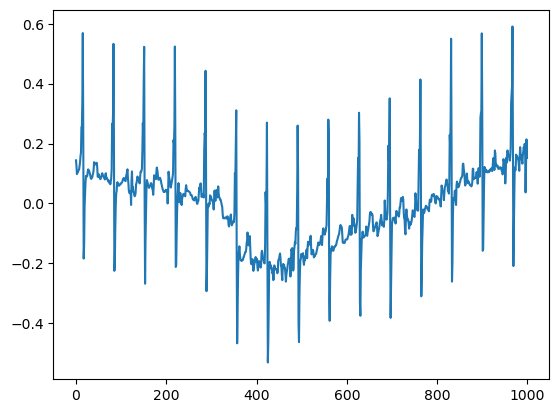

tensor([[[-0.0070,  0.0190,  0.0440,  ...,  0.0230,  0.0180,  0.0010]],

        [[-0.0210, -0.0110,  0.0100,  ...,  0.0890,  0.0650,  0.0570]],

        [[-0.0460, -0.0450, -0.0480,  ...,  0.0580,  0.0070,  0.0580]],

        ...,

        [[ 0.0010,  0.0060,  0.0070,  ..., -0.0630, -0.0560, -0.0320]],

        [[ 0.0710,  0.0420,  0.0290,  ..., -0.0450, -0.0370, -0.0420]],

        [[-0.0450, -0.0450, -0.0450,  ..., -0.1370, -0.1360, -0.1110]]],
       device='cuda:0')


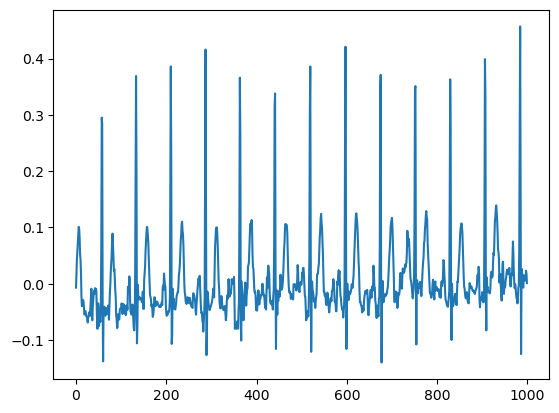

tensor([[[-0.1340, -0.1270, -0.1210,  ..., -0.0070, -0.0210, -0.0150]],

        [[-0.0290, -0.0240, -0.0170,  ..., -0.2030, -0.1770, -0.2000]],

        [[ 0.0740,  0.1050,  0.0920,  ...,  0.0330,  0.0330,  0.0580]],

        ...,

        [[-0.0300, -0.0290, -0.0490,  ..., -0.0890, -0.0620, -0.0350]],

        [[-0.0960, -0.1030, -0.1540,  ..., -0.0250, -0.0550, -0.0170]],

        [[-0.0770, -0.0740, -0.0790,  ..., -0.0440, -0.0430, -0.0310]]],
       device='cuda:0')


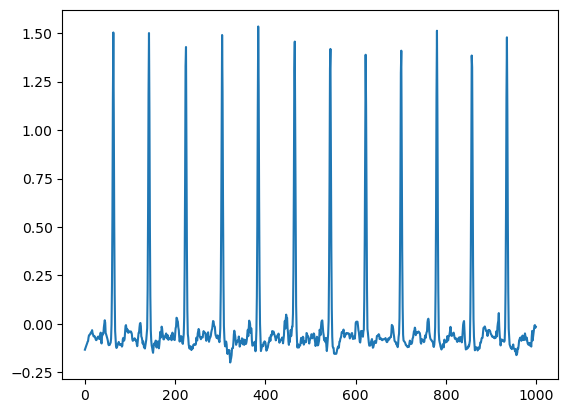

tensor([[[ 0.0030,  0.0350,  0.0730,  ...,  0.0020,  0.0240,  0.0340]],

        [[ 0.0360,  0.0490,  0.0660,  ...,  0.0820,  0.0340, -0.0500]],

        [[-0.0110, -0.0160, -0.0330,  ...,  0.0420,  0.0040, -0.0170]],

        ...,

        [[-0.0610, -0.0710, -0.1380,  ...,  0.0480,  0.0400,  0.0210]],

        [[-0.2840, -0.2750, -0.2780,  ..., -0.2110, -0.2460, -0.3370]],

        [[-0.0100, -0.0100, -0.0110,  ...,  0.0080, -0.0050,  0.0280]]],
       device='cuda:0')


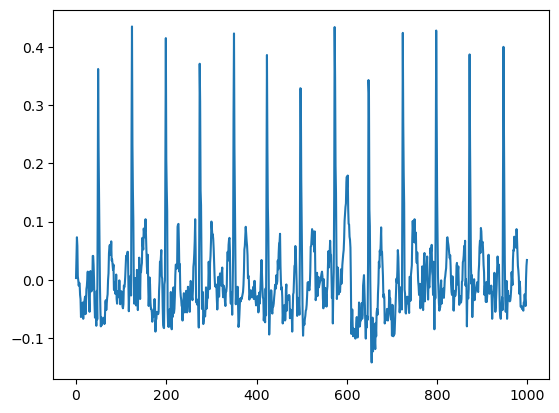

tensor([[[-0.1450, -0.1610, -0.2060,  ..., -0.0250,  0.3520,  0.8850]],

        [[-0.0300, -0.0290, -0.0270,  ..., -0.0930, -0.0850, -0.0850]],

        [[ 0.0000,  0.0030,  0.0040,  ...,  0.0010,  0.0690,  0.0350]],

        ...,

        [[-0.1100, -0.1070, -0.1030,  ..., -0.0520, -0.0560, -0.0400]],

        [[-0.0250, -0.0250, -0.0250,  ..., -0.0220, -0.0270, -0.0250]],

        [[ 0.0760,  0.0810,  0.0640,  ..., -0.0150, -0.0050, -0.0090]]],
       device='cuda:0')


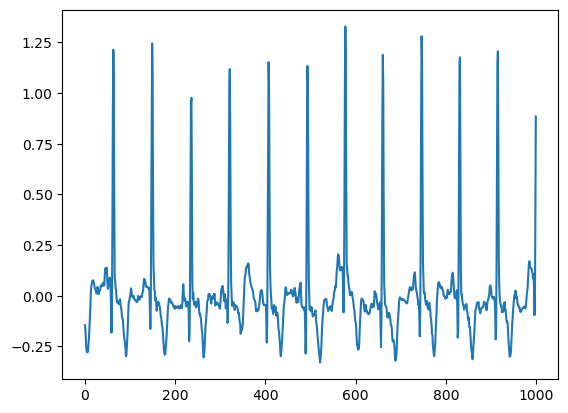

tensor([[[-0.1100, -0.1150, -0.1190,  ..., -0.0410, -0.0510, -0.0240]],

        [[ 0.0120,  0.0130,  0.0390,  ..., -0.0370, -0.0630, -0.0380]],

        [[-0.0140, -0.0060,  0.0080,  ..., -0.1330, -0.1150, -0.0090]],

        ...,

        [[-0.0450, -0.0440, -0.0430,  ..., -0.0320, -0.0250, -0.0230]],

        [[-0.0710, -0.0790, -0.0710,  ...,  0.0090,  0.0430,  0.0070]],

        [[-0.0070,  0.0180, -0.0070,  ...,  0.0440,  0.2690,  0.2220]]],
       device='cuda:0')


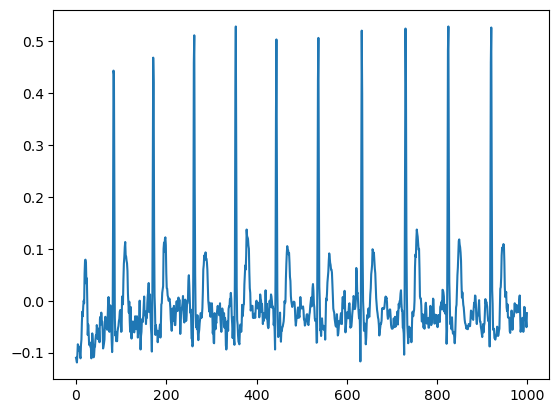

tensor([[[-0.0740, -0.0690, -0.0790,  ..., -0.1350, -0.0080, -0.2880]],

        [[ 0.0610,  0.0710,  0.0950,  ..., -0.9980, -1.9500, -1.7120]],

        [[-0.0050, -0.0050,  0.0020,  ..., -0.0500, -0.0370,  0.0430]],

        ...,

        [[-0.0560, -0.0600, -0.0600,  ...,  0.0290,  0.0500,  0.0400]],

        [[-0.2740, -0.1760, -0.0800,  ...,  0.0220,  0.0230,  0.0390]],

        [[-0.1150, -0.1200, -0.1220,  ..., -0.1340, -0.1290, -0.1460]]],
       device='cuda:0')


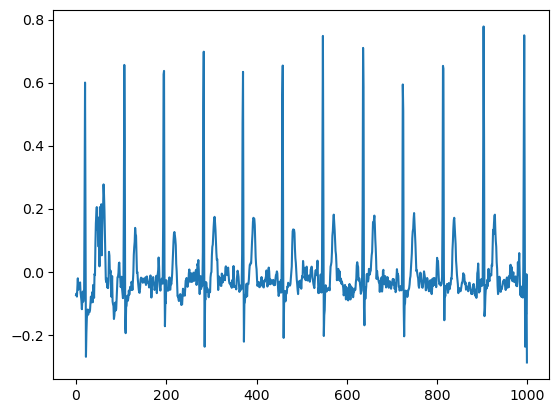

tensor([[[-0.0380, -0.0440, -0.0750,  ...,  0.0610,  0.0310, -0.0350]],

        [[ 0.0150,  0.0150, -0.0060,  ..., -0.0580, -0.2580, -0.6850]],

        [[-0.0770, -0.0850, -0.0800,  ..., -0.0970, -0.1790, -0.1110]],

        ...,

        [[-0.0160, -0.0220, -0.0210,  ...,  0.0120,  0.0060,  0.0000]],

        [[-0.0450, -0.0530, -0.0600,  ...,  0.0460,  0.0510,  0.0310]],

        [[-0.1110, -0.1340, -0.1580,  ..., -0.0390, -0.0570,  0.0600]]],
       device='cuda:0')


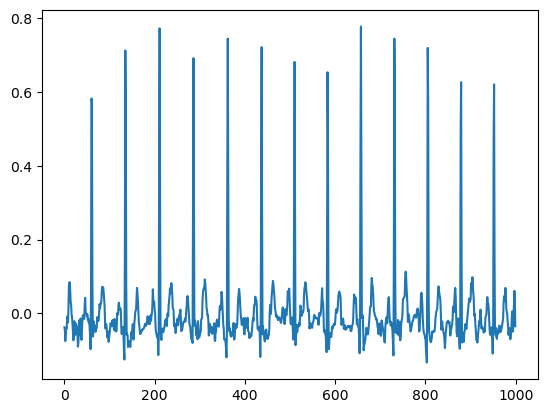

tensor([[[ 0.1090,  0.1030,  0.1050,  ..., -0.0110,  0.0240,  0.0110]],

        [[ 0.0670,  0.0710,  0.0480,  ...,  0.0050, -0.0380, -0.0500]],

        [[ 0.0970,  0.0690, -0.0070,  ..., -0.1370, -0.1670, -0.1910]],

        ...,

        [[-0.0770, -0.0780, -0.0640,  ..., -0.0110,  0.0000, -0.0140]],

        [[ 0.2170, -0.0060, -0.0850,  ...,  0.4110,  0.1730, -0.0550]],

        [[-0.0100, -0.0290, -0.0450,  ...,  0.1030,  0.4320,  0.6700]]],
       device='cuda:0')


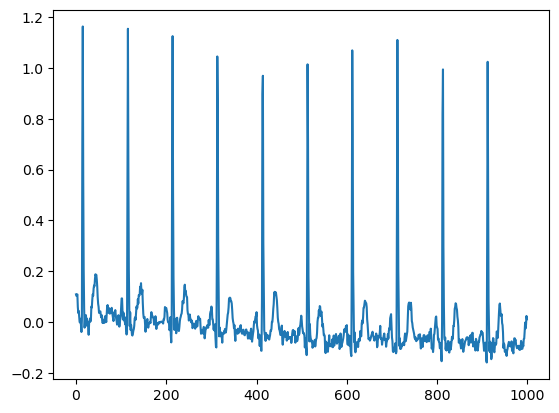

tensor([[[ 0.1220,  0.0670,  0.0100,  ...,  0.2330,  0.1480,  0.0070]],

        [[-0.0500, -0.0500, -0.0470,  ..., -0.0400, -0.0350,  0.0000]],

        [[-0.0050, -0.0080, -0.0100,  ...,  0.0430, -0.0120, -0.0480]],

        ...,

        [[ 0.0860,  0.0380,  0.0430,  ...,  0.0250,  0.0570,  0.0770]],

        [[ 0.0400,  0.0390,  0.0350,  ...,  0.0590,  0.0720,  0.0630]],

        [[-0.0060, -0.0270, -0.0590,  ..., -0.0500,  0.1390,  0.4710]]],
       device='cuda:0')


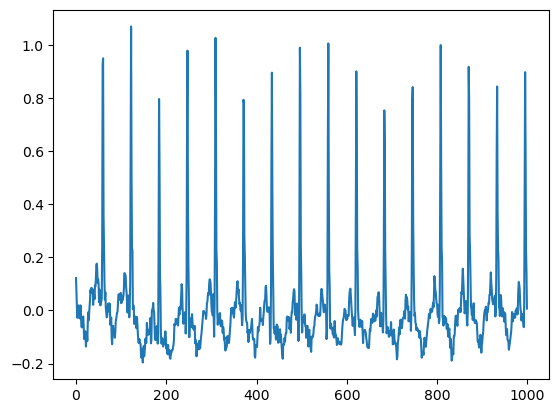

tensor([[[-0.0720, -0.0400, -0.0490,  ...,  0.7850,  0.5720,  0.0950]],

        [[ 0.0130,  0.0530,  0.0640,  ..., -0.0550, -0.1060, -0.1130]],

        [[-0.0780, -0.0780, -0.0940,  ..., -0.1850, -0.2180, -0.2230]],

        ...,

        [[ 0.0150,  0.0150,  0.0120,  ..., -0.1300, -0.1240, -0.1030]],

        [[ 0.0370,  0.0640,  0.0930,  ..., -0.0820, -0.1110, -0.0820]],

        [[ 0.0010,  0.0020,  0.0230,  ...,  0.0660,  0.0540,  0.0880]]],
       device='cuda:0')


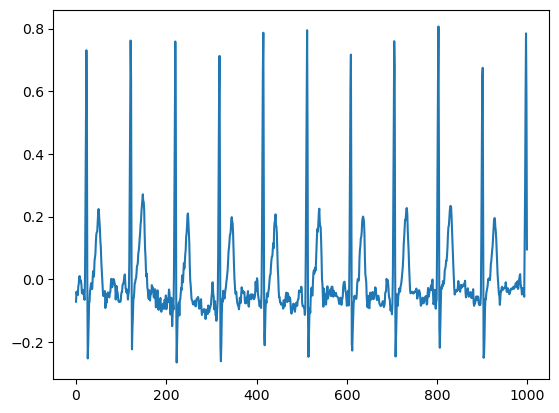

tensor([[[-0.0710, -0.1040, -0.1270,  ...,  0.0080, -0.0130, -0.0190]],

        [[-0.0250, -0.0250, -0.0250,  ..., -0.0220, -0.0200, -0.0360]],

        [[-0.0460, -0.0450, -0.0490,  ...,  0.0960,  0.0990,  0.1030]],

        ...,

        [[ 0.1060,  0.1160,  0.1060,  ..., -0.0750, -0.0710, -0.0530]],

        [[-0.0050,  0.0130, -0.0250,  ..., -0.0960, -0.1470, -0.0490]],

        [[ 0.0810,  0.3420,  0.6370,  ...,  0.0770,  0.0630,  0.0460]]],
       device='cuda:0')


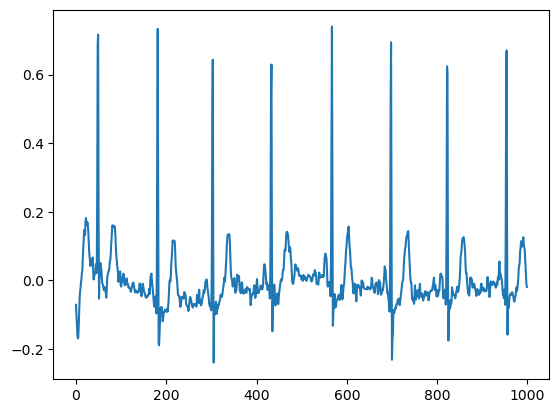

tensor([[[-0.0690, -0.0390,  0.0140,  ..., -0.0720, -0.0820, -0.0850]],

        [[-0.1170, -0.1310, -0.1450,  ..., -0.0310, -0.0250, -0.0190]],

        [[-0.1520, -0.1440, -0.1250,  ..., -0.1450, -0.0920, -0.0490]],

        ...,

        [[-0.0420, -0.0600, -0.0770,  ...,  0.0930,  0.0350, -0.0500]],

        [[ 0.0910,  0.0980,  0.0650,  ...,  0.6460,  0.7930,  0.2290]],

        [[ 0.3360,  0.1770,  0.0490,  ..., -0.0430, -0.0360, -0.0350]]],
       device='cuda:0')


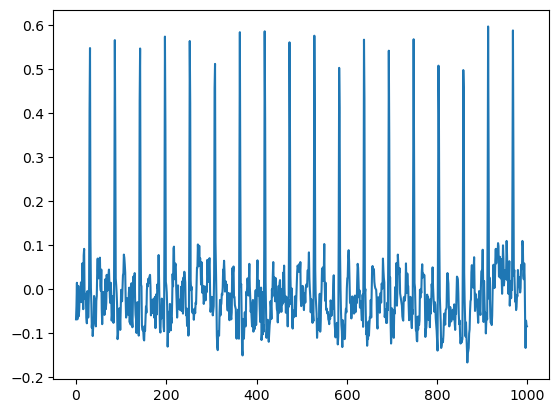

tensor([[[-0.0150, -0.0150, -0.0150,  ...,  0.0800,  0.0890,  0.0750]],

        [[ 0.0490,  0.0420,  0.0330,  ...,  0.0670,  0.4490,  0.7460]],

        [[ 0.0250,  0.0240,  0.0170,  ..., -0.0780, -0.0710, -0.0720]],

        ...,

        [[ 0.0150,  0.0150,  0.0120,  ...,  0.1530,  0.0720,  0.1030]],

        [[-0.0740, -0.0470, -0.0380,  ..., -0.2280, -0.2780, -0.2770]],

        [[-0.0310, -0.0380, -0.0270,  ..., -0.0130, -0.0180,  0.0000]]],
       device='cuda:0')


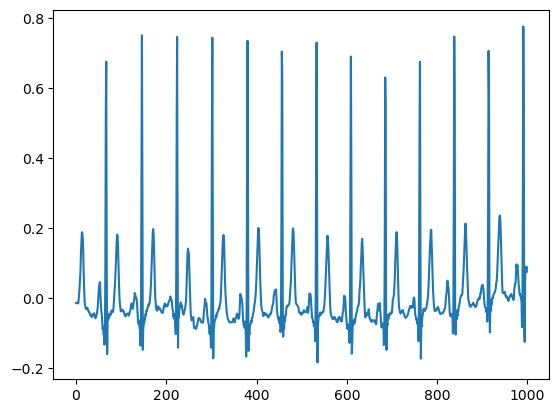

tensor([[[-0.0400, -0.0420, -0.0470,  ..., -0.0260,  0.0070,  0.0240]],

        [[ 0.0390,  0.0390, -0.0070,  ..., -0.0760, -0.0950, -0.1040]],

        [[-0.1500, -0.2100, -0.1200,  ..., -0.0720, -0.0700, -0.0790]],

        ...,

        [[ 0.1720,  0.1200,  0.0290,  ..., -0.0690, -0.0630,  0.0240]],

        [[-0.1970, -0.1610, -0.1950,  ...,  0.3020,  0.3210,  0.3300]],

        [[ 0.0900,  0.0880,  0.0810,  ..., -0.0010, -0.0110,  0.0060]]],
       device='cuda:0')


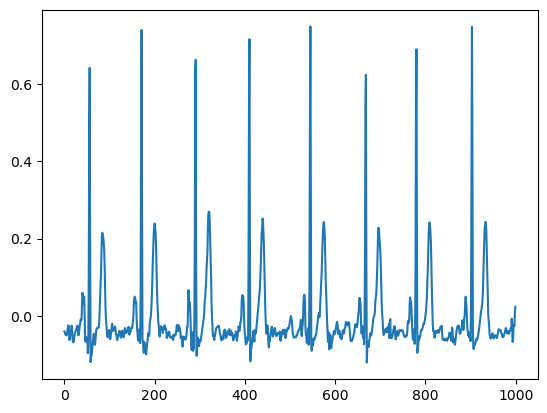

tensor([[[-0.0600, -0.0600, -0.0590,  ...,  0.0710, -0.0330, -0.1850]],

        [[ 0.0040, -0.0030, -0.0210,  ..., -0.0860, -0.0810, -0.0800]],

        [[ 0.1450,  0.1320,  0.1010,  ...,  0.0250, -0.0120, -0.0090]],

        ...,

        [[ 0.0400,  0.0320,  0.0110,  ..., -0.0850, -0.0760, -0.0830]],

        [[-0.1020, -0.0970, -0.0950,  ..., -0.0110,  0.0000, -0.0010]],

        [[-0.0850, -0.0820, -0.0750,  ..., -0.1870, -0.1600, -0.0240]]],
       device='cuda:0')


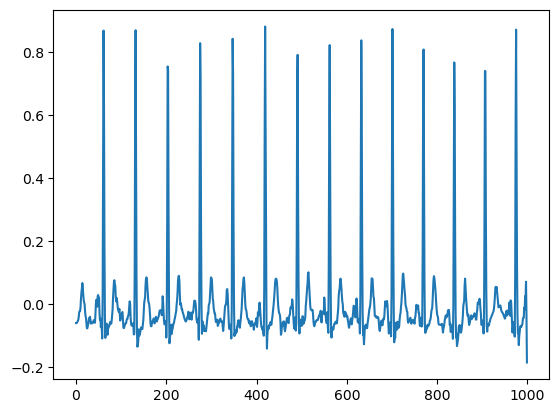

tensor([[[-0.1660, -0.0700,  0.0000,  ..., -0.0040,  0.0070, -0.0030]],

        [[ 0.0030, -0.0090, -0.0480,  ..., -0.0160, -0.1180, -0.3160]],

        [[-0.0470, -0.0600, -0.0630,  ...,  0.0840,  0.0610,  0.0610]],

        ...,

        [[-0.1670, -0.1430, -0.0870,  ..., -0.1340, -0.1770, -0.1400]],

        [[ 0.2580,  0.2230,  0.1790,  ..., -0.1440, -0.1530, -0.1600]],

        [[-0.0400, -0.0490, -0.0580,  ...,  0.5350,  0.3280,  0.0980]]],
       device='cuda:0')


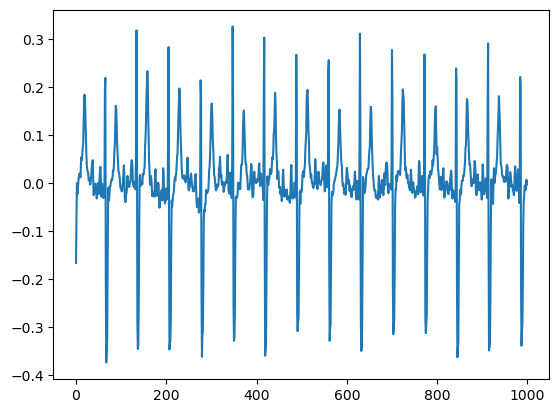

tensor([[[-0.0120, -0.0070, -0.0100,  ...,  0.2460,  0.2480,  0.2630]],

        [[ 0.0270,  0.0390,  0.0630,  ...,  0.0880,  0.3920,  0.3320]],

        [[ 0.6480,  0.8350,  0.7000,  ..., -0.0180, -0.0030,  0.0090]],

        ...,

        [[ 0.3900,  0.6360,  0.5200,  ...,  0.0060,  0.0060,  0.0210]],

        [[-0.2300, -0.2290, -0.2250,  ..., -0.1390, -0.1150, -0.1060]],

        [[ 0.0050, -0.0010, -0.0110,  ..., -0.0080, -0.0230, -0.0530]]],
       device='cuda:0')


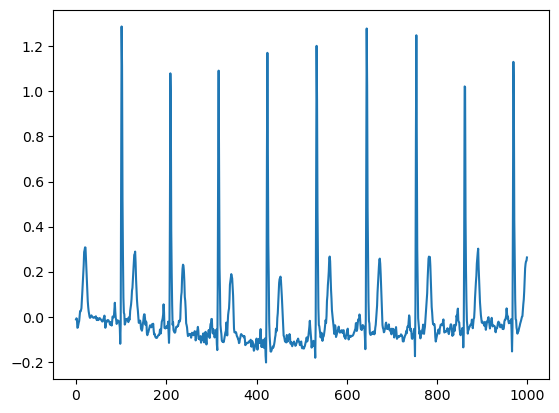

tensor([[[ 0.1310,  0.2670,  0.2370,  ...,  0.0360,  0.0850,  0.3230]],

        [[ 0.0300,  0.0220,  0.0070,  ..., -0.1690,  0.2170,  0.9270]],

        [[-0.0050, -0.0110, -0.0040,  ..., -0.1070,  0.0200, -0.4110]],

        ...,

        [[ 1.2450,  1.1220,  0.2050,  ...,  0.9310,  1.0480,  0.1050]],

        [[-0.0710, -0.0840, -0.1060,  ...,  0.0870,  0.0580,  0.0850]],

        [[-0.0990, -0.1270, -0.0440,  ...,  0.0220, -0.1160,  0.0940]]],
       device='cuda:0')


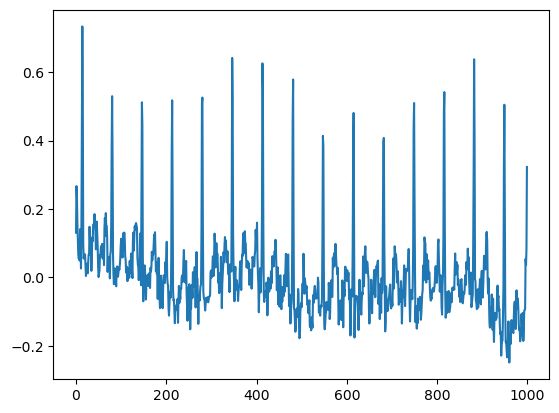

tensor([[[-0.1230, -0.1270, -0.1490,  ..., -0.0390, -0.0420, -0.0340]],

        [[-0.1600, -0.1620, -0.1650,  ..., -0.0410, -0.1220, -0.1090]],

        [[-0.0700, -0.0260, -0.0160,  ...,  0.0120, -0.0240,  0.0520]],

        ...,

        [[-0.0830, -0.0630, -0.0360,  ..., -0.0170, -0.0150,  0.0080]],

        [[-0.0310, -0.0330, -0.0440,  ...,  0.0130, -0.2120, -0.6790]],

        [[-0.1390, -0.1300, -0.1280,  ..., -0.0060,  0.5440,  1.0820]]],
       device='cuda:0')


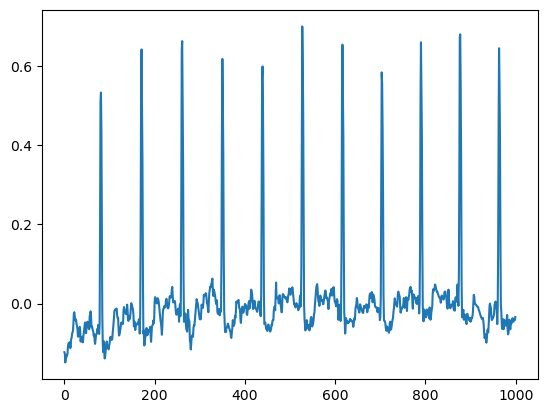

tensor([[[ 0.0620,  0.0930,  0.0670,  ...,  0.1240,  0.1110,  0.0850]],

        [[ 0.0080, -0.0120, -0.0680,  ...,  0.0050,  0.0050, -0.0120]],

        [[ 0.2710,  0.2570,  0.2150,  ..., -0.0600, -0.1420, -0.1490]],

        ...,

        [[-0.0500, -0.0620, -0.0850,  ..., -0.1450, -0.0910,  0.2740]],

        [[ 0.0830,  0.0670,  0.0370,  ..., -0.0060, -0.0040, -0.0030]],

        [[-0.0150, -0.0150, -0.0180,  ..., -0.0520, -0.0210,  0.0100]]],
       device='cuda:0')


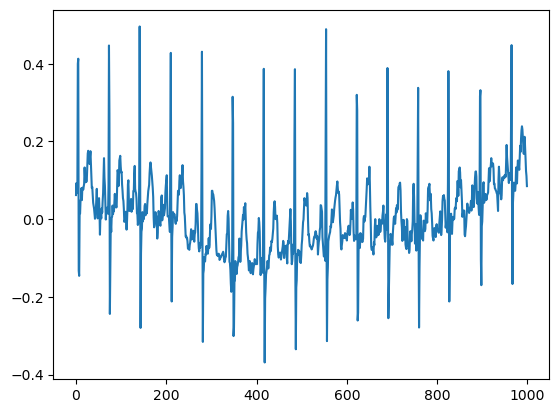

tensor([[[-0.0660, -0.0640, -0.0310,  ...,  0.0440,  0.0400,  0.0260]],

        [[ 0.0910,  0.1250,  0.1630,  ..., -0.0610, -0.2570,  0.0000]],

        [[-0.0390, -0.0540, -0.0830,  ...,  0.2280,  0.2290,  0.2190]],

        ...,

        [[-0.0200, -0.0260, -0.0440,  ..., -0.1170, -0.0300,  0.0920]],

        [[ 0.0000, -0.0030, -0.0090,  ..., -0.1740, -0.1580, -0.0140]],

        [[-0.0850, -0.0850, -0.0950,  ..., -0.0520, -0.0540, -0.0360]]],
       device='cuda:0')


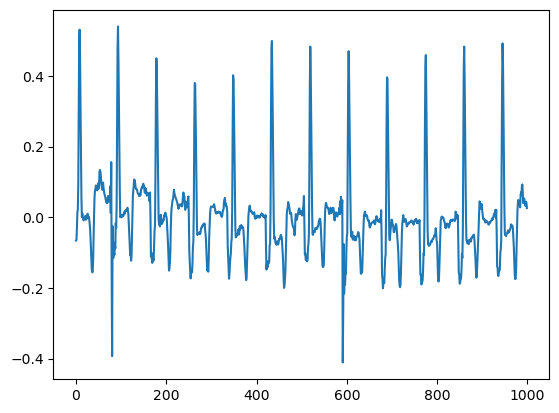

tensor([[[ 0.4140,  0.1340, -0.4900,  ..., -0.0290, -0.0510, -0.0150]],

        [[-0.0500, -0.0280, -0.0010,  ...,  0.0810,  0.0700,  0.0630]],

        [[-0.0300, -0.0300, -0.0300,  ...,  0.3050,  0.0300,  0.0800]],

        ...,

        [[-0.1550, -0.1640, -0.1700,  ...,  0.2690,  0.2080,  0.1530]],

        [[-0.0040, -0.0110, -0.0340,  ..., -0.0730, -0.0730, -0.0130]],

        [[-0.0350, -0.0510, -0.0630,  ...,  0.0930,  0.0580,  0.0860]]],
       device='cuda:0')


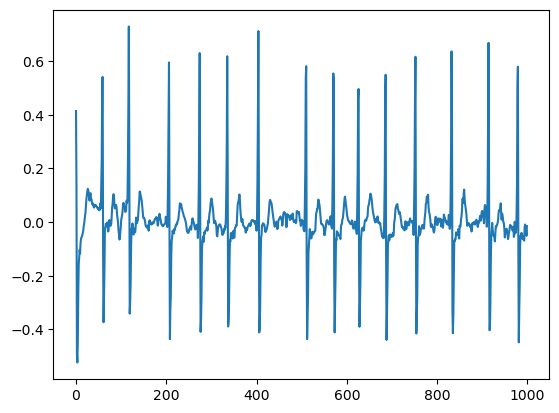

tensor([[[-0.0290, -0.0270, -0.0180,  ..., -0.0050, -0.0600, -0.0650]],

        [[-0.3230, -0.3070, -0.3310,  ...,  0.3680,  0.4180,  0.4070]],

        [[-0.0800, -0.0830, -0.0890,  ...,  0.0520,  0.0400,  0.0490]],

        ...,

        [[ 0.0060, -0.0260, -0.0330,  ...,  0.3450,  0.2560,  0.1840]],

        [[ 0.3070,  0.3130,  0.3530,  ..., -0.0390, -0.0480, -0.0570]],

        [[ 0.0290,  0.0200, -0.0090,  ..., -0.0040, -0.0040,  0.0250]]],
       device='cuda:0')


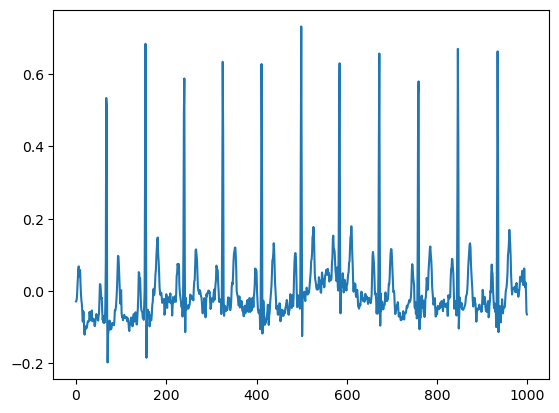

tensor([[[-0.0930, -0.0990, -0.1090,  ...,  0.2950,  0.2800,  0.2390]],

        [[-0.0250, -0.0240, -0.0230,  ..., -0.8830, -0.8480, -0.7360]],

        [[-0.0210, -0.0220, -0.0220,  ...,  0.1520,  0.1520,  0.1440]],

        ...,

        [[ 0.0430,  0.0260,  0.0020,  ...,  0.0570,  0.0810,  0.1070]],

        [[-0.2150, -0.1610, -0.1040,  ..., -0.0960, -0.0780, -0.0590]],

        [[ 0.0650,  0.0940,  0.1020,  ...,  0.2160, -0.0410,  0.0140]]],
       device='cuda:0')


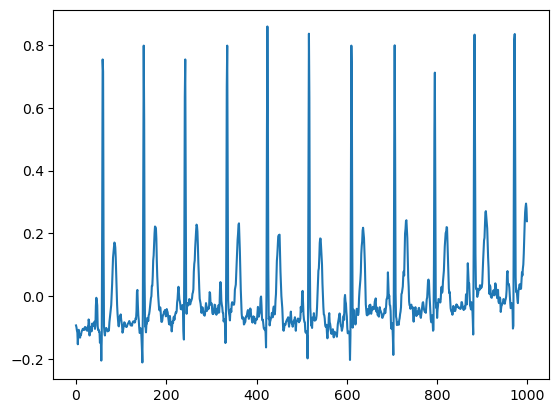

tensor([[[ 0.6130,  0.8090,  1.0120,  ..., -0.0920,  0.0230,  0.1980]],

        [[ 0.3040,  0.5240,  0.8290,  ..., -0.0230, -0.0040,  0.0240]],

        [[-0.1090, -0.0960, -0.0770,  ...,  0.0360,  0.0360,  0.0080]],

        ...,

        [[-0.0110, -0.0430, -0.0730,  ...,  0.0810,  0.1820,  0.2190]],

        [[-0.0080, -0.0050, -0.0180,  ..., -0.1770, -0.1640, -0.2390]],

        [[-0.1740, -0.1760, -0.1770,  ..., -0.1900, -0.1700, -0.1650]]],
       device='cuda:0')


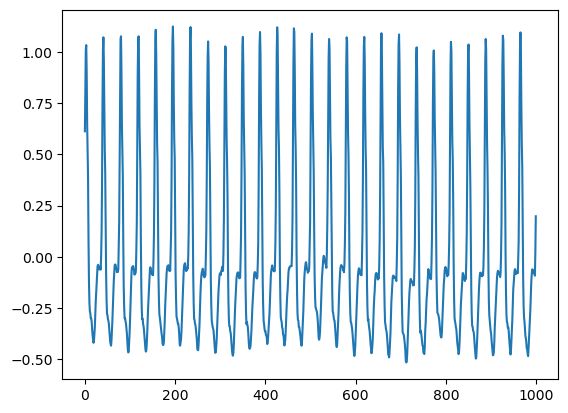

tensor([[[-0.1490, -0.1390, -0.1060,  ...,  0.0660,  0.0330,  0.0020]],

        [[-0.0550, -0.0350,  0.0550,  ..., -0.0560, -0.0430, -0.0460]],

        [[ 0.0150,  0.0180,  0.0200,  ..., -0.1000, -0.1470, -0.3660]],

        ...,

        [[-0.0350, -0.0350, -0.0350,  ...,  0.0760,  0.0780,  0.0660]],

        [[-0.1050, -0.1270, -0.1210,  ...,  0.1580,  0.1490,  0.1810]],

        [[ 0.0250,  0.0240,  0.0130,  ..., -0.0440, -0.0390,  0.0100]]],
       device='cuda:0')


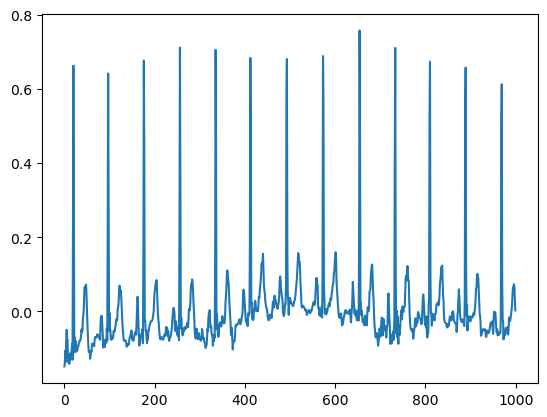

tensor([[[-0.0560, -0.0610, -0.0660,  ..., -0.0780, -0.1930, -0.0430]],

        [[ 0.0540,  0.0450,  0.0340,  ..., -0.0810, -0.0790, -0.0850]],

        [[ 0.0570,  0.0270, -0.0780,  ..., -0.1610, -0.2170, -0.2850]],

        ...,

        [[ 0.1140,  0.1170,  0.1200,  ...,  0.0140,  0.0030,  0.0000]],

        [[-0.3050, -0.3020, -0.2940,  ...,  0.9780,  0.1790, -0.1600]],

        [[ 0.1180,  0.1630,  0.1900,  ...,  0.0760,  0.1200,  0.1610]]],
       device='cuda:0')


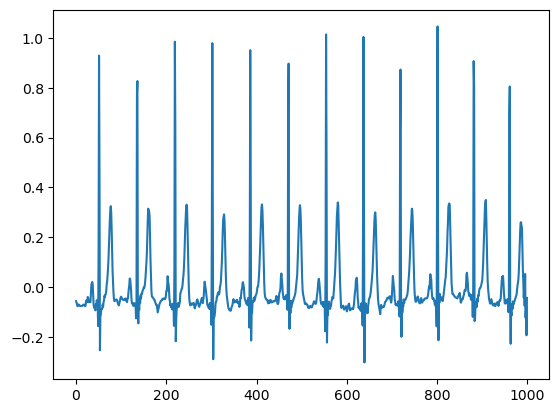

tensor([[[-0.1620, -0.1430, -0.1340,  ..., -0.0130, -0.0490, -0.0080]],

        [[ 0.0640,  0.0710,  0.0910,  ..., -0.1460, -0.0900, -0.0860]],

        [[-0.0970, -0.1240, -0.1660,  ...,  0.1040,  0.1330,  0.1330]],

        ...,

        [[-0.2700, -0.2930, -0.2790,  ...,  0.9740,  0.4920, -0.0770]],

        [[ 0.0410,  0.0470,  0.0280,  ..., -0.1180, -0.1320, -0.0610]],

        [[-0.0750, -0.0680, -0.0380,  ...,  0.0010, -0.0010,  0.0010]]],
       device='cuda:0')


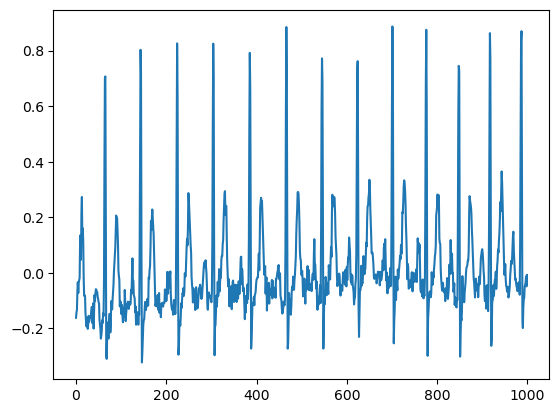

tensor([[[ 0.0200,  0.0200,  0.0250,  ..., -0.0390, -0.0390, -0.0460]],

        [[-0.0990, -0.1040, -0.1050,  ..., -0.0450, -0.0580, -0.0490]],

        [[ 0.3990,  0.3840,  0.3270,  ..., -0.0800, -0.1390, -0.1710]],

        ...,

        [[-0.0290, -0.0240, -0.0190,  ..., -0.3310,  0.1430, -0.0450]],

        [[-0.0350, -0.0350, -0.0350,  ...,  0.1530,  0.5990,  0.6940]],

        [[-0.1010, -0.1610, -0.1850,  ...,  0.2380, -0.1470, -0.3320]]],
       device='cuda:0')


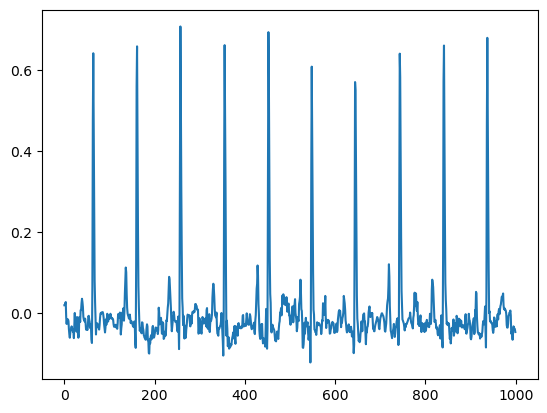

tensor([[[ 0.0310,  0.0180,  0.0120,  ..., -0.0890,  0.0890,  0.1770]],

        [[ 1.1760,  0.9320,  0.2540,  ..., -0.0550, -0.0570, -0.0670]],

        [[-0.0310, -0.0370, -0.0440,  ...,  0.2110,  0.2290,  0.2470]],

        ...,

        [[-0.0200,  0.2450,  0.6280,  ...,  0.0110,  0.0110,  0.0370]],

        [[ 0.0600,  0.0400,  0.0050,  ..., -0.0080, -0.1140, -0.1060]],

        [[-0.0910, -0.0960, -0.0950,  ..., -0.1560, -0.0280,  0.1440]]],
       device='cuda:0')


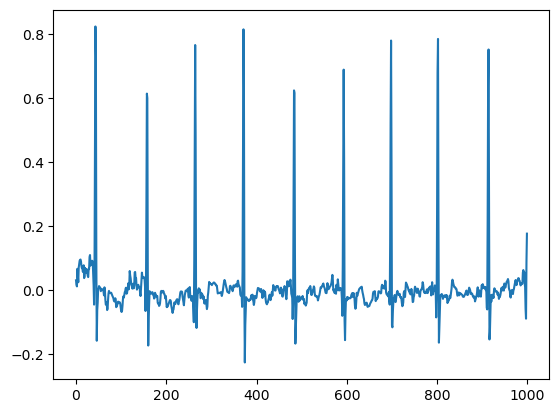

tensor([[[ 0.0070, -0.0260, -0.0480,  ..., -0.0280,  0.0150,  0.0490]],

        [[-0.0790, -0.0790, -0.0990,  ..., -0.0050, -0.0080, -0.0110]],

        [[ 0.1700,  0.1870,  0.2250,  ...,  0.2140, -0.0530, -0.1910]],

        ...,

        [[-0.2390, -0.2380, -0.2310,  ...,  0.2590,  0.2360,  0.2480]],

        [[ 0.0900,  0.1110,  0.1130,  ...,  0.2130,  0.5110,  0.2690]],

        [[-0.0580, -0.0480, -0.0400,  ..., -0.0160, -0.0040,  0.0440]]],
       device='cuda:0')


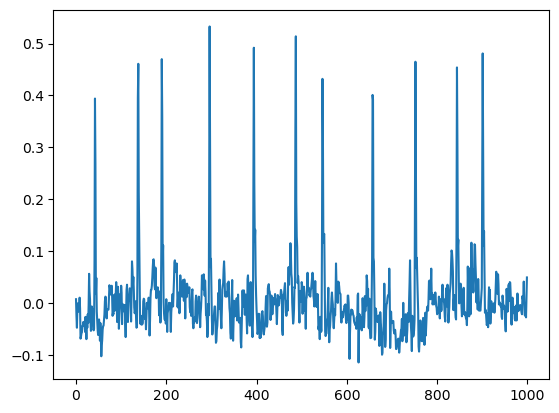

tensor([[[ 0.0380,  0.0280,  0.0220,  ..., -0.0040, -0.0250, -0.0110]],

        [[-0.0550, -0.0510, -0.0320,  ...,  0.1270,  0.1410,  0.1640]],

        [[-0.0440, -0.0490, -0.0300,  ...,  0.0580, -0.0370,  0.0190]],

        ...,

        [[-0.0430, -0.0490, -0.0230,  ...,  0.0590,  0.0940,  0.0680]],

        [[-0.0250, -0.0230, -0.0180,  ..., -0.0220,  0.0090,  0.0990]],

        [[ 1.4380,  1.4530,  1.1090,  ..., -0.0630, -0.0800, -0.0760]]],
       device='cuda:0')


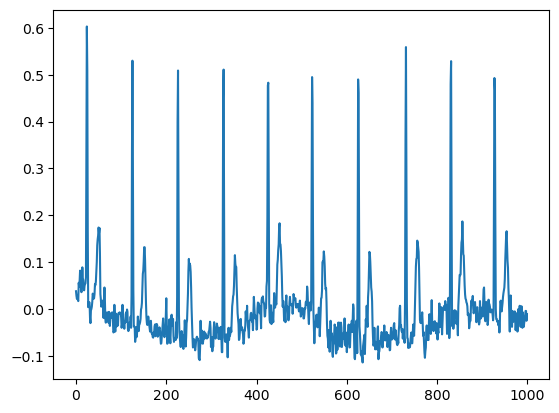

tensor([[[ 0.0500,  0.0660,  0.1020,  ...,  0.0020,  0.0060,  0.0100]],

        [[ 0.0000,  0.0000,  0.0000,  ..., -0.2200,  0.1890,  0.5540]],

        [[-0.1050, -0.1040, -0.0990,  ...,  0.0160, -0.0470,  0.1890]],

        ...,

        [[-0.1470, -0.1150, -0.0640,  ..., -0.0170,  0.0770,  0.0190]],

        [[-0.0670, -0.0350,  0.0460,  ..., -0.2670, -0.2010, -0.1610]],

        [[ 0.0550,  0.0410,  0.0320,  ..., -0.0450, -0.0400, -0.0670]]],
       device='cuda:0')


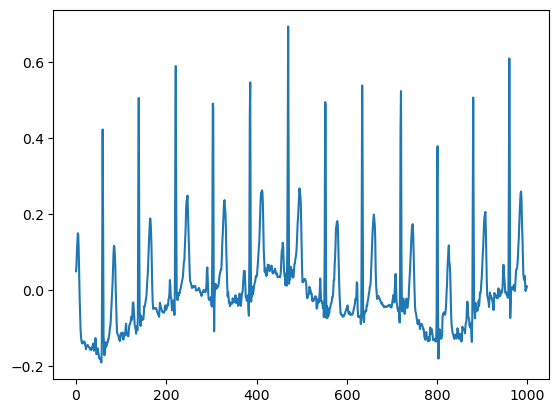

tensor([[[ 0.0440,  0.0520,  0.0700,  ..., -0.2210, -0.2230, -0.2100]],

        [[-0.0090, -0.0120, -0.0150,  ..., -0.1020, -0.1020, -0.1130]],

        [[-0.0020, -0.0270, -0.0380,  ...,  0.1330,  0.0560,  0.0720]],

        ...,

        [[ 0.2930,  0.0320, -0.1140,  ...,  0.0870,  0.1140,  0.1230]],

        [[-0.0160, -0.0190, -0.0280,  ..., -0.0420, -0.0530, -0.0450]],

        [[-0.0030, -0.0260, -0.0500,  ..., -0.0280, -0.0320, -0.0360]]],
       device='cuda:0')


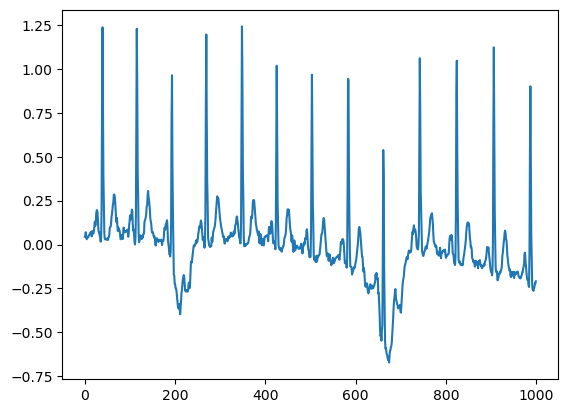

tensor([[[ 0.0330,  0.0330,  0.0270,  ...,  0.0390, -0.0060,  0.0370]],

        [[-0.0460, -0.0410, -0.0230,  ..., -0.8180, -0.8230, -0.3210]],

        [[-0.0500, -0.0500, -0.0490,  ...,  0.0430,  0.0370,  0.0150]],

        ...,

        [[-0.0050,  0.0060,  0.0030,  ..., -0.0930, -0.0790, -0.0660]],

        [[-0.0140, -0.0230, -0.0420,  ..., -0.0010,  0.0610,  0.0080]],

        [[-0.0400, -0.0390, -0.0520,  ...,  0.1150, -0.0340, -0.1140]]],
       device='cuda:0')


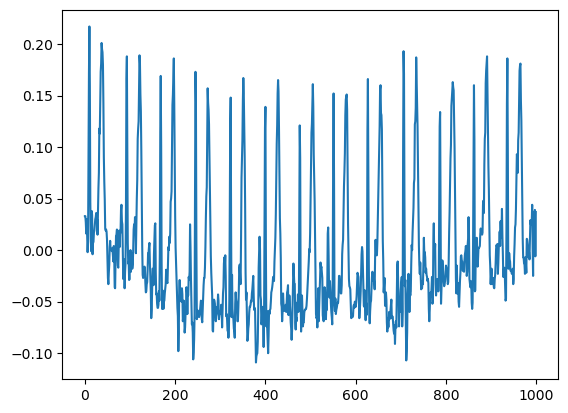

tensor([[[-0.1430, -0.1670, -0.1710,  ...,  0.0340, -0.2060, -0.1790]],

        [[-0.0140, -0.0080, -0.0030,  ...,  1.3060,  0.9880,  0.4450]],

        [[ 0.1600, -0.0160, -0.0600,  ..., -0.0920, -0.0850, -0.0860]],

        ...,

        [[-0.1320, -0.1170, -0.1280,  ..., -0.1330, -0.2690, -0.1990]],

        [[-0.1080, -0.0980, -0.0830,  ..., -0.0190, -0.0150,  0.0240]],

        [[-0.0450, -0.0420, -0.0260,  ...,  0.1430, -0.4460, -0.1660]]],
       device='cuda:0')


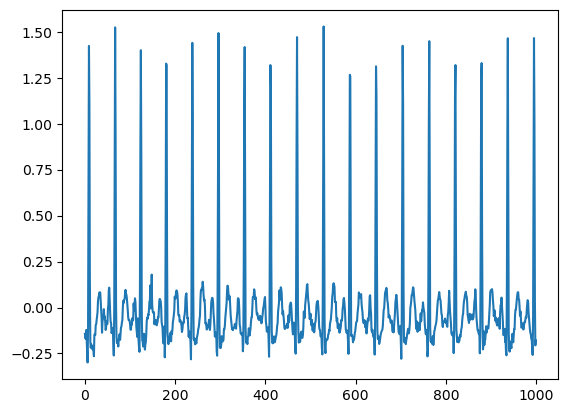

tensor([[[ 0.0070,  0.0100, -0.0080,  ..., -0.0120, -0.0050,  0.0030]],

        [[-0.0520, -0.0580, -0.0340,  ...,  0.0260,  0.0190, -0.0230]],

        [[-0.0090, -0.0050,  0.0070,  ..., -0.0340, -0.0250,  0.0050]],

        ...,

        [[-0.0080,  0.0060,  0.0020,  ...,  0.4490,  0.3720,  0.3890]],

        [[-0.0490, -0.0240, -0.0240,  ..., -0.0800,  0.0690,  0.3070]],

        [[ 0.0140,  0.0130,  0.0300,  ..., -0.1030, -0.0990, -0.0830]]],
       device='cuda:0')


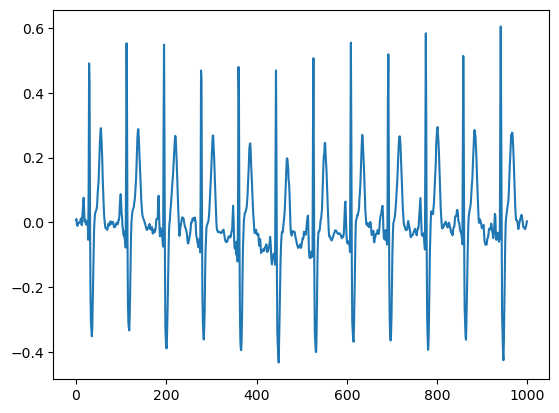

tensor([[[-0.0590, -0.0660, -0.0770,  ..., -0.0310, -0.0260,  0.0360]],

        [[ 0.0350,  0.0490,  0.0070,  ..., -0.0130, -0.0230,  0.0200]],

        [[-0.0770, -0.0830, -0.0850,  ...,  0.0080,  0.0010,  0.0180]],

        ...,

        [[-0.1500, -0.1480, -0.1420,  ...,  0.0410,  0.0390,  0.0010]],

        [[-0.0540, -0.0450, -0.0520,  ..., -0.0570, -0.0310,  0.0020]],

        [[ 0.0250, -0.0150,  0.0230,  ...,  0.1730,  0.1380,  0.0930]]],
       device='cuda:0')


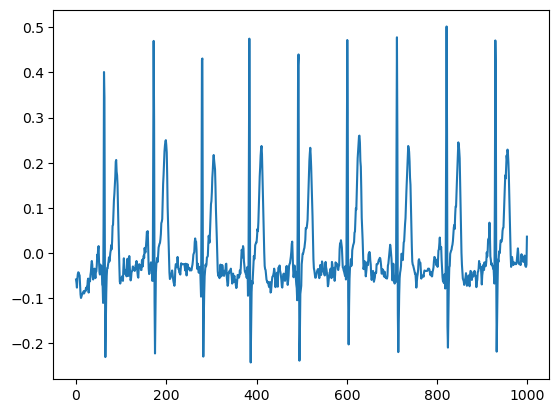

tensor([[[ 0.0600,  0.0500,  0.0330,  ..., -0.0600, -0.0780, -0.0880]],

        [[-0.0850, -0.0920, -0.1020,  ..., -0.1110, -0.1100, -0.1270]],

        [[-0.0200, -0.0200, -0.0110,  ..., -0.0150, -0.0650, -0.0420]],

        ...,

        [[-0.0510, -0.0330, -0.0090,  ...,  0.0260, -0.6320, -0.9430]],

        [[-0.0300, -0.0180, -0.0310,  ..., -0.0260, -0.0470, -0.0770]],

        [[-0.0330, -0.0460, -0.0410,  ..., -0.0860, -0.1260, -0.0880]]],
       device='cuda:0')


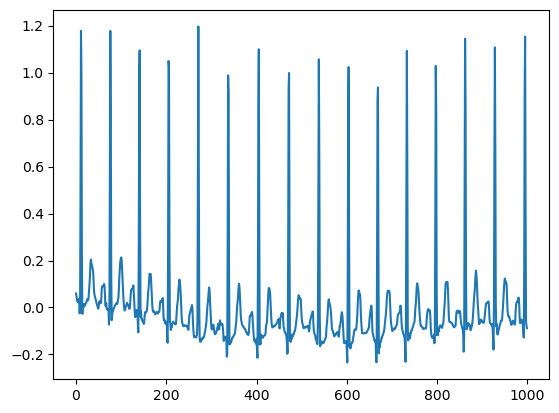

tensor([[[-0.0200, -0.0200, -0.0230,  ..., -0.2370, -0.0050, -0.0010]],

        [[ 0.2610,  0.2710,  0.2990,  ..., -0.0160, -0.0140,  0.0090]],

        [[-0.0780, -0.0630, -0.0790,  ...,  0.0410,  0.0160, -0.0030]],

        ...,

        [[-0.2050, -0.2030, -0.2000,  ...,  0.1170,  0.5920,  0.8430]],

        [[-0.0040,  0.0310,  0.1640,  ...,  0.0680,  0.0520,  0.0400]],

        [[-0.0600, -0.0570, -0.0540,  ...,  0.0220,  0.0190,  0.0200]]],
       device='cuda:0')


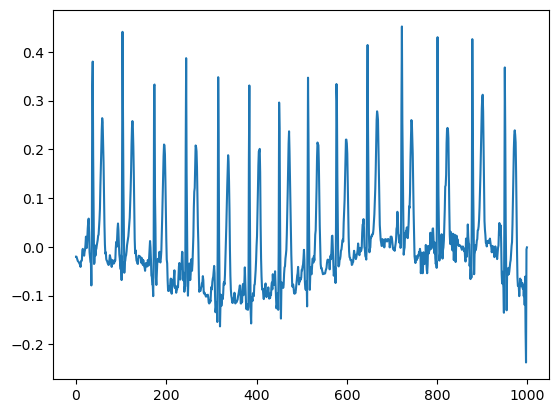

tensor([[[-0.0160, -0.0150, -0.0140,  ...,  0.0580,  0.0520,  0.0210]],

        [[ 0.0940,  0.0970,  0.1190,  ...,  0.1240,  0.1630,  0.1660]],

        [[ 0.2150,  0.2030,  0.1230,  ...,  0.0430,  0.0350,  0.0400]],

        ...,

        [[ 0.0080,  0.0000,  0.0030,  ...,  0.4270,  0.4510,  0.4630]],

        [[-0.1240, -0.0800, -0.0360,  ...,  0.0270,  0.0130, -0.0560]],

        [[-0.1190, -0.1080, -0.0840,  ..., -0.0080, -0.0470, -0.1860]]],
       device='cuda:0')


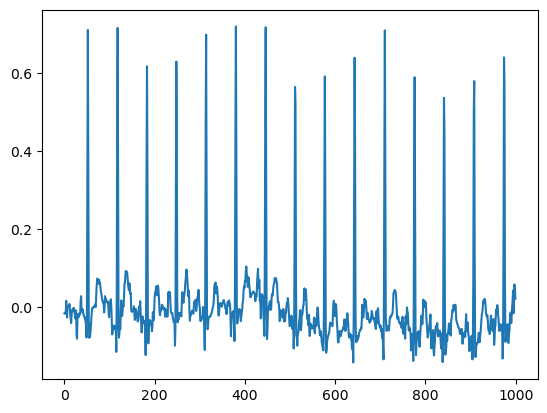

tensor([[[-0.0360, -0.0550, -0.0630,  ...,  0.0550,  0.0140,  0.0260]],

        [[-0.0010, -0.0050, -0.0050,  ...,  0.1900,  0.1570,  0.1450]],

        [[-0.0650, -0.0660, -0.0890,  ...,  0.0050,  0.0270,  0.0770]],

        ...,

        [[-0.0390, -0.0380, -0.0190,  ..., -0.1340, -0.1290, -0.1450]],

        [[ 0.0690,  0.0500,  0.0210,  ..., -0.0160, -0.0410, -0.0470]],

        [[-0.0170,  0.0700,  0.1050,  ..., -0.0720, -0.0720, -0.0480]]],
       device='cuda:0')


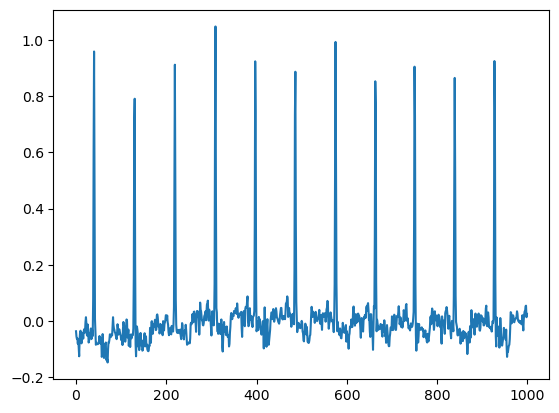

tensor([[[ 0.0200,  0.0380,  0.0600,  ..., -0.1000, -0.1480, -0.1030]],

        [[-0.0040,  0.0070,  0.0250,  ..., -0.0250, -0.0350, -0.0370]],

        [[-0.3000, -0.3050, -0.3070,  ..., -0.2260, -0.2090, -0.1700]],

        ...,

        [[ 0.0040,  0.0080,  0.0080,  ...,  0.0160,  0.0130,  0.0210]],

        [[-0.0050, -0.0030,  0.0030,  ...,  0.0560,  0.0170, -0.0090]],

        [[-0.1990, -0.2060, -0.2210,  ...,  0.0890,  0.0710,  0.0560]]],
       device='cuda:0')


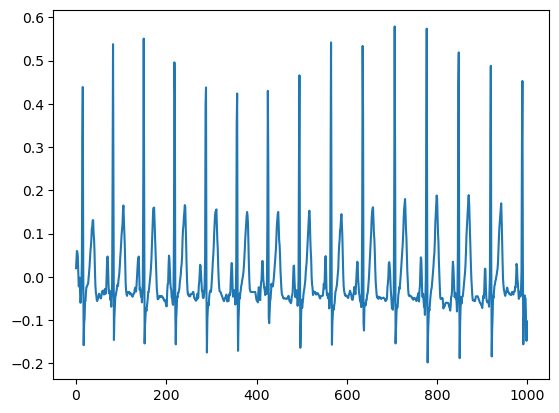

tensor([[[-0.1790, -0.1680, -0.1520,  ...,  1.4690,  1.5110,  1.4960]],

        [[ 0.2430,  0.0890, -0.1100,  ..., -0.0250, -0.0130,  0.0280]],

        [[-0.1500, -0.1490, -0.1600,  ...,  0.0170,  0.0170,  0.0100]],

        ...,

        [[-0.2190, -0.2160, -0.2370,  ...,  0.3760,  0.2690,  0.3770]],

        [[-0.0120,  0.0400,  0.0350,  ...,  0.1210,  0.0990,  0.0930]],

        [[ 0.0030,  0.0020,  0.0050,  ..., -0.0230, -0.0590, -0.0780]]],
       device='cuda:0')


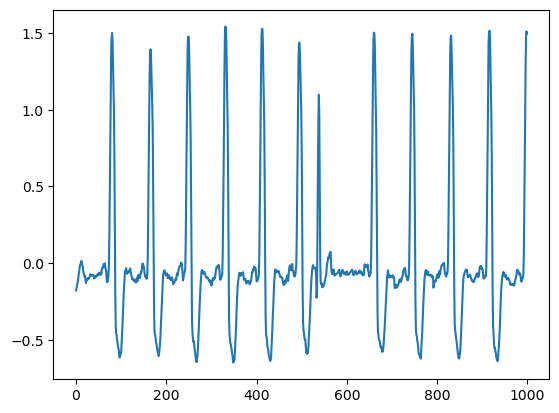

tensor([[[ 0.0630,  0.1020,  0.0750,  ...,  0.2060,  0.2320,  0.2260]],

        [[ 0.1050,  0.1020,  0.1060,  ..., -0.0530, -0.0550, -0.0360]],

        [[-0.0450, -0.0440, -0.0410,  ..., -0.0270, -0.0610, -0.0730]],

        ...,

        [[-0.0730, -0.0660, -0.0350,  ...,  0.0480,  0.0180,  0.0860]],

        [[ 0.0200,  0.0220,  0.0270,  ..., -0.0450, -0.0520, -0.0550]],

        [[ 0.0000,  0.0020,  0.0080,  ..., -0.4570, -0.2700,  0.0150]]],
       device='cuda:0')


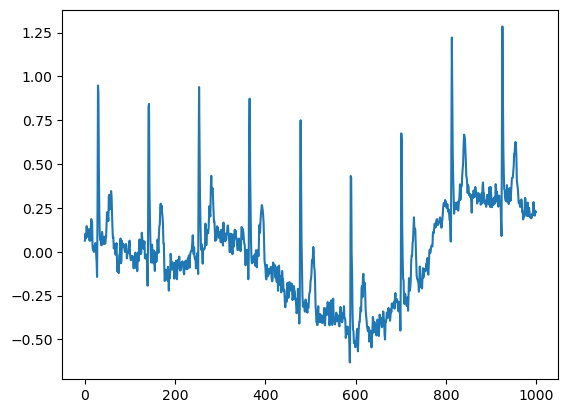

tensor([[[-0.0050, -0.0050, -0.0050,  ..., -0.0280, -0.0170, -0.0320]],

        [[ 0.0030,  0.0030,  0.0320,  ...,  0.0290,  0.0320, -0.0350]],

        [[ 0.0270,  0.0230,  0.0270,  ..., -0.0810, -0.1160, -0.0990]],

        ...,

        [[ 0.2150,  0.2440,  0.3020,  ...,  0.0830,  0.0880,  0.0970]],

        [[-0.2010, -0.2080, -0.2080,  ..., -0.1260, -0.0930, -0.0740]],

        [[ 0.1000,  0.0920,  0.0700,  ...,  0.0250,  0.0210,  0.0340]]],
       device='cuda:0')


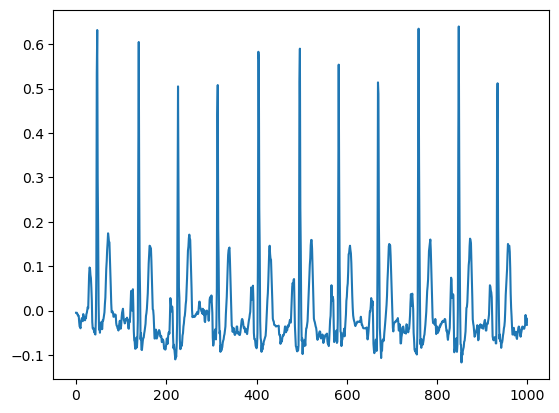

tensor([[[-0.0460, -0.0440, -0.0280,  ..., -0.0920, -0.1130, -0.0970]],

        [[ 0.0260,  0.0680,  0.0610,  ...,  0.0370,  0.0340,  0.0400]],

        [[ 0.7020,  0.5490,  0.2870,  ..., -0.0070, -0.0060, -0.0090]],

        ...,

        [[-0.1260, -0.1280, -0.1280,  ..., -0.0850, -0.1590, -0.2220]],

        [[ 0.0290,  0.0350,  0.0480,  ...,  0.3380,  0.4370,  0.0970]],

        [[-0.1180, -0.0980, -0.0880,  ..., -0.3470, -0.3080,  0.2670]]],
       device='cuda:0')


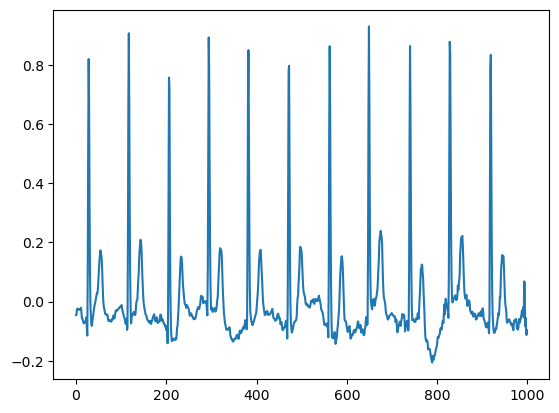

tensor([[[-0.1590, -0.1400, -0.1150,  ...,  0.1870,  0.2420,  0.1560]],

        [[ 0.0210,  0.0470,  0.0760,  ...,  0.0220,  0.1150,  0.0410]],

        [[-0.1000, -0.1020, -0.1050,  ...,  0.2700,  0.0290, -0.0880]],

        ...,

        [[-0.0360, -0.0840, -0.0940,  ...,  0.0090, -0.0120, -0.0890]],

        [[-0.0510, -0.0510, -0.0460,  ..., -0.0770, -0.0400,  0.1030]],

        [[-0.0530, -0.0430, -0.0480,  ..., -0.0590, -0.0600, -0.0740]]],
       device='cuda:0')


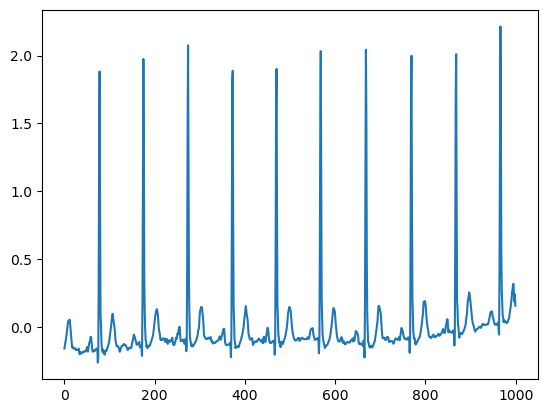

tensor([[[-0.3140, -0.3110, -0.3070,  ..., -0.2080, -0.1770, -0.1550]],

        [[ 0.1900,  0.1690,  0.1410,  ...,  0.0470,  0.0240,  0.0250]],

        [[-0.0120, -0.0180, -0.0040,  ...,  0.0200, -0.0320,  0.0180]],

        ...,

        [[-0.4560, -0.3180, -0.1750,  ..., -0.0630, -0.0070,  0.0570]],

        [[-0.0490, -0.0590, -0.0610,  ..., -0.1640, -0.1560, -0.1350]],

        [[-0.1100, -0.1100, -0.1100,  ..., -0.2460, -0.1180, -0.0450]]],
       device='cuda:0')


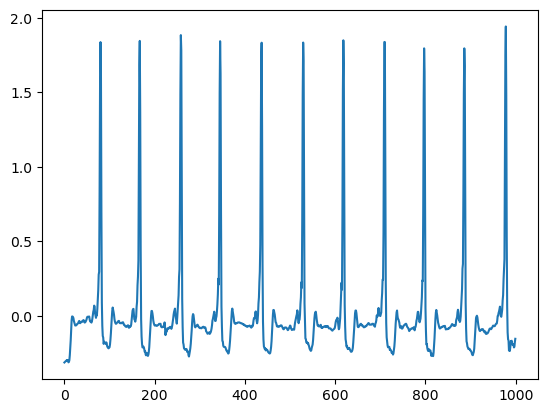

tensor([[[-0.0530, -0.0600, -0.0800,  ...,  0.0560,  0.2750,  0.1250]],

        [[ 0.0470,  0.0540,  0.1130,  ..., -0.0730, -0.0810, -0.0800]],

        [[ 0.0160,  0.0150,  0.0170,  ..., -0.0810, -0.0870, -0.0730]],

        ...,

        [[ 0.6700,  0.5530,  0.3640,  ...,  0.0640,  0.0620,  0.0480]],

        [[-0.0400, -0.0430, -0.0400,  ..., -0.0200, -0.0580, -0.1640]],

        [[-0.0460, -0.0450, -0.0400,  ..., -0.1140, -0.1090, -0.0010]]],
       device='cuda:0')


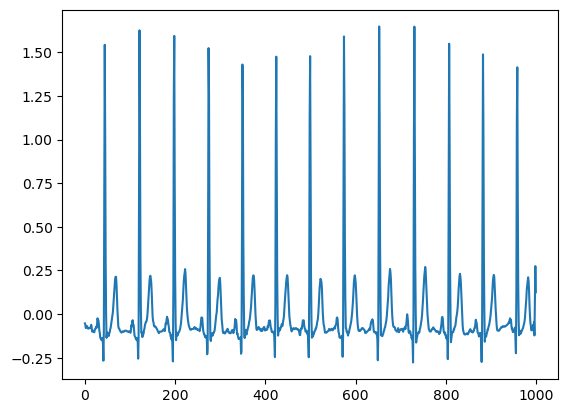

tensor([[[-0.0510, -0.0560, -0.0640,  ..., -0.2240, -0.2760,  0.0430]],

        [[ 0.0790,  0.0670,  0.0710,  ..., -0.0120, -0.0380,  0.0140]],

        [[-0.0400, -0.0520, -0.0530,  ..., -0.0200, -0.0680, -0.0330]],

        ...,

        [[-0.0200, -0.0180, -0.0220,  ..., -0.0170, -0.0580, -0.0020]],

        [[-0.1420, -0.0150,  0.5290,  ..., -0.1460, -0.1550, -0.1630]],

        [[-0.1220, -0.4290, -0.3650,  ...,  0.0150,  0.0060, -0.0930]]],
       device='cuda:0')


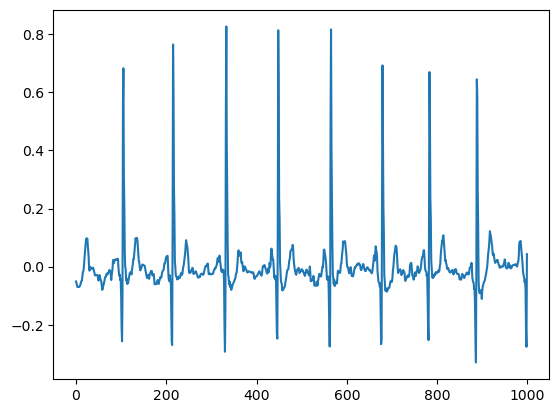

tensor([[[-0.0690, -0.0650, -0.0630,  ..., -0.0410, -0.0540, -0.0640]],

        [[ 0.2860,  0.2290,  0.1570,  ..., -0.0480, -0.0180, -0.0330]],

        [[-0.1280, -0.0830, -0.0790,  ...,  0.1390,  0.1270,  0.0570]],

        ...,

        [[ 0.0560,  0.0570,  0.0550,  ..., -0.0390,  0.0700, -0.0160]],

        [[-0.0540, -0.0510, -0.0450,  ...,  0.0260,  0.0230,  0.0440]],

        [[ 0.0130, -0.0020,  0.0050,  ...,  0.0790,  0.0170, -0.0030]]],
       device='cuda:0')


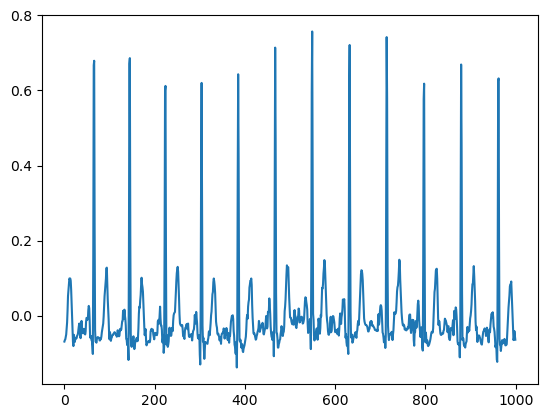

tensor([[[-0.1150, -0.1120, -0.1140,  ..., -0.0400, -0.0100, -0.0100]],

        [[ 0.0540,  0.0410,  0.0700,  ..., -0.0710, -0.0930, -0.0880]],

        [[ 0.1570,  0.1720,  0.1740,  ..., -0.0440, -0.1020, -0.0950]],

        ...,

        [[-0.0380, -0.0580, -0.0430,  ...,  0.1120,  0.1020,  0.0800]],

        [[-0.0170, -0.0270, -0.0240,  ..., -0.0890, -0.1210, -0.2010]],

        [[-0.0700, -0.0860, -0.0650,  ..., -0.0100,  0.0830,  0.1160]]],
       device='cuda:0')


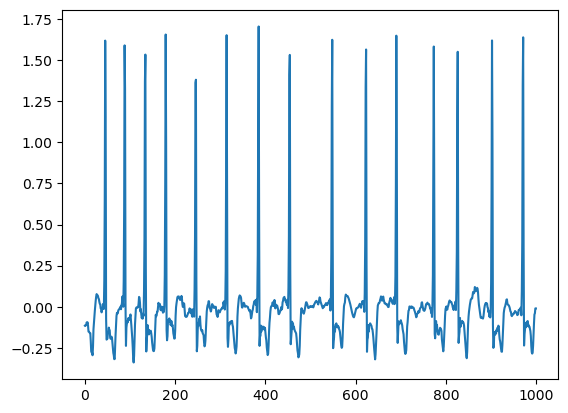

tensor([[[ 0.1200,  0.1200,  0.1200,  ...,  0.0130,  0.0070, -0.0670]],

        [[-0.0120,  0.0030, -0.0020,  ...,  0.4440,  0.2930,  0.0490]],

        [[ 0.0240,  0.0260,  0.0330,  ..., -0.0980,  0.0250, -0.0670]],

        ...,

        [[ 0.0290,  0.0270,  0.0420,  ...,  0.2480,  0.3310,  0.2760]],

        [[-0.0550, -0.0540, -0.0510,  ...,  0.0950,  0.1080,  0.0990]],

        [[ 0.0600,  0.0430,  0.0080,  ..., -0.0340, -0.2310, -0.2950]]],
       device='cuda:0')


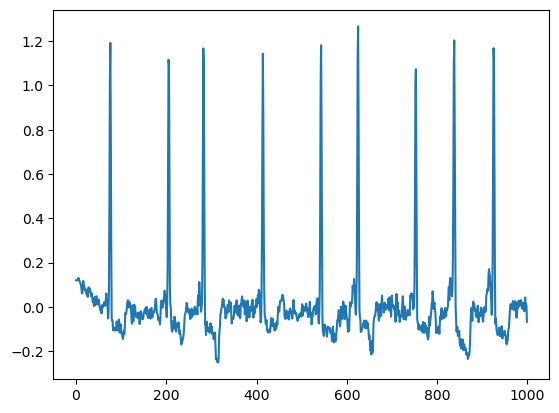

tensor([[[-8.0000e-03, -2.0000e-03, -2.0000e-02,  ..., -4.1000e-02,
          -5.0000e-02, -7.2000e-02]],

        [[ 7.3000e-02,  3.0000e-02, -4.9000e-02,  ...,  3.0000e-02,
           5.0000e-02,  7.8000e-02]],

        [[-7.4000e-02, -6.3000e-02, -7.7000e-02,  ..., -5.3000e-02,
          -1.4400e-01, -1.9300e-01]],

        ...,

        [[ 7.6000e-02,  9.6000e-02,  1.0100e-01,  ..., -1.0100e-01,
          -1.0500e-01, -1.9700e-01]],

        [[ 4.6500e-01,  9.1800e-01,  1.3440e+00,  ...,  2.0000e-02,
          -1.0000e-03,  4.8000e-02]],

        [[-2.0000e-02, -1.9000e-02, -1.4000e-02,  ...,  1.3400e-01,
           1.3500e-01,  1.4800e-01]]], device='cuda:0')


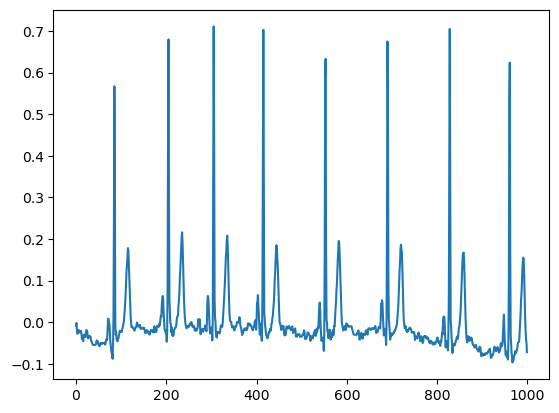

tensor([[[ 0.0900,  0.0630,  0.0700,  ..., -0.0080, -0.0010,  0.0030]],

        [[-0.0460, -0.0240,  0.0150,  ...,  0.0510,  0.0640,  0.0410]],

        [[ 0.0340,  0.0490,  0.1610,  ..., -0.0170,  0.0010,  0.0370]],

        ...,

        [[ 0.4630,  0.2280,  0.0980,  ...,  0.0140, -0.0370, -0.0060]],

        [[-0.1000, -0.1030, -0.1000,  ...,  0.0550,  0.0810,  0.0610]],

        [[ 0.1750,  0.1500,  0.1230,  ..., -0.2220, -0.2240, -0.2410]]],
       device='cuda:0')


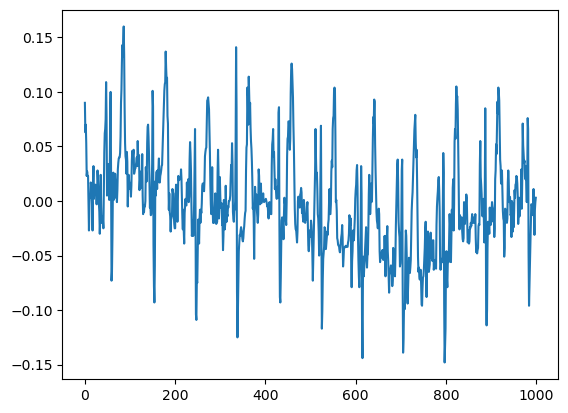

tensor([[[-0.0790, -0.0730, -0.0820,  ..., -0.0810, -0.0510, -0.0540]],

        [[-0.1150, -0.1230, -0.1230,  ...,  0.0690,  0.0220, -0.0040]],

        [[ 0.1790,  0.1760,  0.1710,  ..., -0.0030, -0.0010, -0.0080]],

        ...,

        [[-0.0040, -0.0170, -0.0130,  ...,  0.0170, -0.1060, -0.2240]],

        [[ 0.2250,  0.2290,  0.2500,  ..., -0.1680, -0.1530, -0.1420]],

        [[-0.0290, -0.0470, -0.0790,  ..., -0.0690, -0.0890, -0.0800]]],
       device='cuda:0')


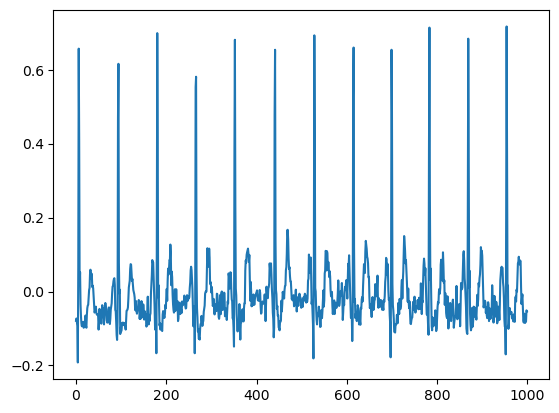

tensor([[[-0.0560, -0.0150, -0.0360,  ..., -0.0180, -0.0710, -0.1880]],

        [[ 0.1680,  0.1570,  0.1500,  ...,  0.1050,  0.0900,  0.0230]],

        [[ 0.0990,  0.1100,  0.0770,  ...,  0.1110,  0.5890,  0.4770]],

        ...,

        [[ 0.1660,  0.1570,  0.1790,  ...,  0.7060,  0.4200,  0.0100]],

        [[-0.0750, -0.0660, -0.1060,  ...,  0.0040,  0.0040,  0.0050]],

        [[ 0.0160,  0.0100, -0.0060,  ..., -0.0450, -0.0480, -0.0510]]],
       device='cuda:0')


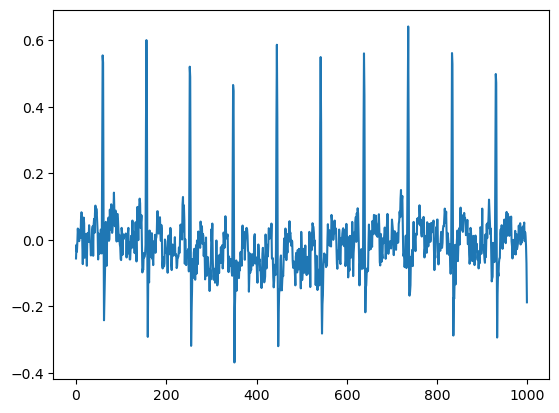

tensor([[[-0.2730, -0.2930, -0.3110,  ...,  0.0350, -0.0300, -0.1000]],

        [[-0.0380, -0.0490, -0.0840,  ..., -0.0150, -0.0060, -0.0400]],

        [[ 0.0760,  0.1090,  0.0900,  ..., -0.0040,  0.0050, -0.0570]],

        ...,

        [[ 0.0080, -0.0150, -0.0380,  ...,  0.1600,  0.1510,  0.1840]],

        [[ 0.0690,  0.0760,  0.0570,  ...,  0.0460,  0.0380, -0.0730]],

        [[-0.0150, -0.0250, -0.0490,  ..., -0.4540,  0.0250, -0.0840]]],
       device='cuda:0')


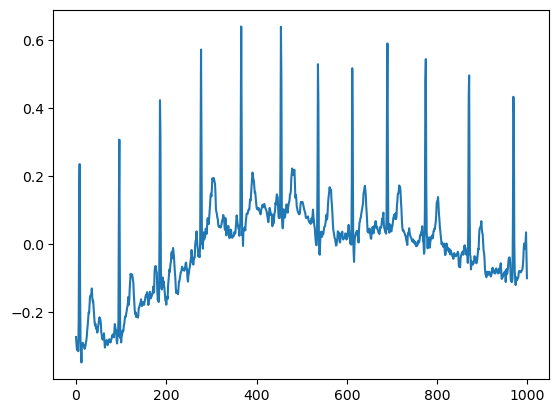

tensor([[[-0.0890, -0.0900, -0.1120,  ..., -0.0170, -0.0190, -0.0500]],

        [[ 0.1830,  0.1280,  0.0110,  ...,  0.0160,  0.0140, -0.0030]],

        [[-0.1430, -0.1470,  0.0010,  ..., -0.2970, -0.3350, -0.3420]],

        ...,

        [[ 0.0210,  0.0210,  0.0220,  ..., -0.0350, -0.0140, -0.0300]],

        [[-0.0550, -0.0850, -0.0760,  ...,  0.0840,  0.0710,  0.0670]],

        [[-0.0070, -0.0100, -0.0410,  ...,  0.1210, -0.2130, -0.7200]]],
       device='cuda:0')


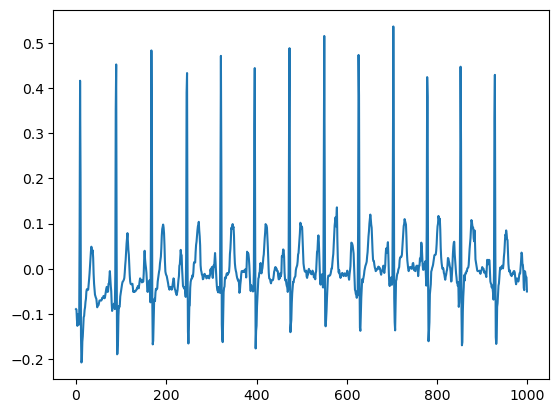

tensor([[[-0.0810, -0.0830, -0.0610,  ...,  0.0590,  0.0860,  0.0410]],

        [[-0.1190, -0.1240, -0.1930,  ...,  0.0080, -0.0190, -0.0450]],

        [[ 0.0550,  0.1060,  0.1160,  ...,  0.1410,  0.1160,  0.1090]],

        ...,

        [[ 0.0180,  0.0160, -0.0060,  ...,  0.0250,  0.0050,  0.0920]],

        [[ 0.3080,  0.1530, -0.1300,  ..., -0.1540, -0.1720, -0.1340]],

        [[-0.0240, -0.0060,  0.0060,  ...,  0.0280,  0.0210,  0.0140]]],
       device='cuda:0')


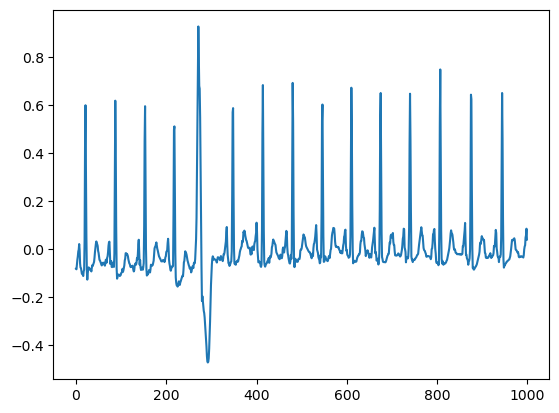

tensor([[[-0.0750, -0.0790, -0.0870,  ..., -0.0400, -0.0250, -0.0240]],

        [[-0.0740, -0.0810, -0.0600,  ...,  0.0630,  0.0330,  0.0510]],

        [[ 0.3010,  0.3090,  0.3250,  ...,  0.5490,  0.4910,  0.5320]],

        ...,

        [[-0.0520,  0.0870,  0.4970,  ...,  0.0060, -0.0620, -0.1840]],

        [[-0.0870, -0.0720, -0.0610,  ...,  0.0230,  0.0350,  0.0380]],

        [[ 0.0300,  0.0350,  0.0390,  ...,  0.0190,  0.0620,  0.0520]]],
       device='cuda:0')


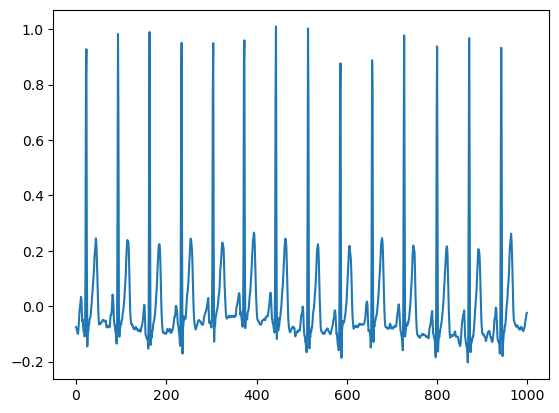

tensor([[[-0.0410, -0.0500, -0.0510,  ...,  0.0580,  0.0680,  0.0820]],

        [[-0.0390, -0.0510, -0.0810,  ..., -0.0490, -0.0230, -0.0240]],

        [[ 0.0140, -0.0390, -0.0270,  ..., -0.0260, -0.0340, -0.0320]],

        ...,

        [[-0.0880, -0.1150, -0.1090,  ..., -0.0250,  0.0640,  0.2220]],

        [[-0.1100, -0.0840, -0.0970,  ..., -0.0840, -0.1220, -0.1020]],

        [[-0.0800, -0.0840, -0.0900,  ...,  0.0200, -0.0470,  0.1220]]],
       device='cuda:0')


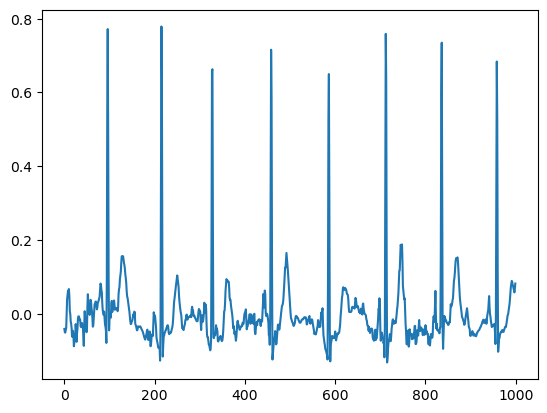

tensor([[[ 0.3480,  0.4580,  0.5330,  ..., -0.0110,  0.0010,  0.0240]],

        [[-0.0490, -0.0550, -0.0200,  ...,  0.0450,  0.0160,  0.0240]],

        [[ 0.0210,  0.0510,  0.0490,  ...,  0.1450,  0.2590,  0.2400]],

        ...,

        [[ 0.0200,  0.0190,  0.0220,  ..., -0.0750, -0.0830, -0.0860]],

        [[-0.1540, -0.1060,  0.0460,  ...,  0.0540,  0.1550,  0.3690]],

        [[-0.0810, -0.1120, -0.1570,  ...,  0.0010,  0.0120,  0.0210]]],
       device='cuda:0')


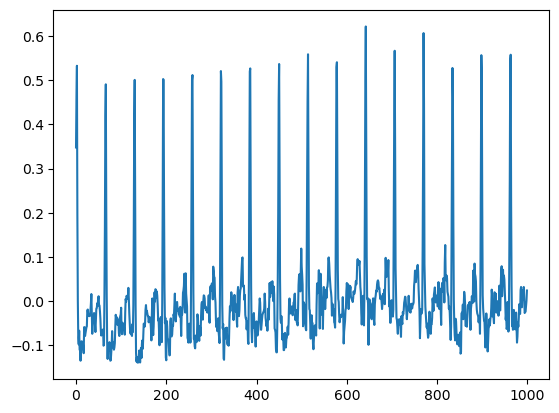

tensor([[[ 0.3340,  0.3020,  0.2380,  ..., -0.1480,  0.2250,  1.0140]],

        [[ 0.0110,  0.0030, -0.0240,  ...,  0.6150,  0.5820,  0.6610]],

        [[-0.1240,  0.0220, -0.0640,  ...,  0.0140,  0.0410,  0.1210]],

        ...,

        [[-0.0100, -0.0090, -0.0070,  ..., -0.0420,  0.0460,  0.0920]],

        [[-0.0360, -0.0540, -0.0560,  ..., -0.1500, -0.1480, -0.1690]],

        [[ 0.0050,  0.0130,  0.0270,  ..., -0.0130, -0.0340, -0.0980]]],
       device='cuda:0')


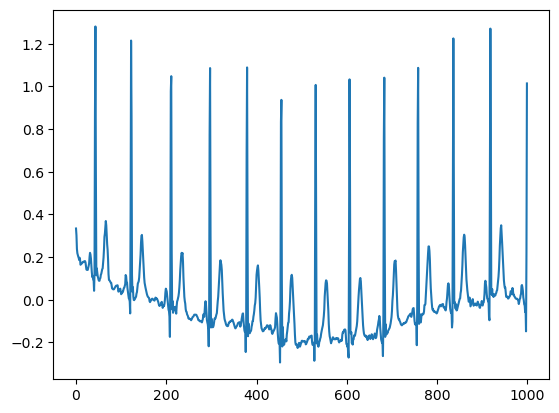

tensor([[[ 0.0230,  0.0230,  0.0370,  ...,  0.0610,  0.1700,  0.1300]],

        [[-0.0250, -0.0250, -0.0250,  ...,  0.0310,  0.2550,  0.2720]],

        [[ 0.3690,  0.3610,  0.2920,  ..., -0.0100,  0.0320,  0.0190]],

        ...,

        [[ 0.2480,  0.2550,  0.2780,  ..., -0.1450, -0.1280, -0.1080]],

        [[-0.0430, -0.0330, -0.0290,  ..., -0.0130,  0.0190,  0.0150]],

        [[-0.1300, -0.1300, -0.1330,  ...,  0.0400,  0.0230,  0.0200]]],
       device='cuda:0')


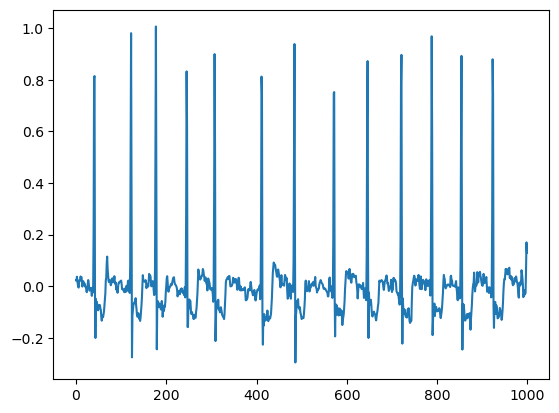

tensor([[[-0.2220, -0.2360, -0.2380,  ...,  0.1260,  0.0890,  0.0800]],

        [[-0.1030, -0.0500,  0.0810,  ..., -0.0220, -0.0060, -0.0010]],

        [[ 0.5090,  0.2840, -0.1150,  ..., -0.0510, -0.0560, -0.0470]],

        ...,

        [[-0.0400, -0.0420, -0.0490,  ...,  0.0460,  0.2060,  0.5770]],

        [[-0.0710, -0.0690, -0.1130,  ..., -0.0080, -0.0350, -0.0540]],

        [[-0.0350, -0.0390, -0.0550,  ..., -0.0650, -0.0760, -0.1160]]],
       device='cuda:0')


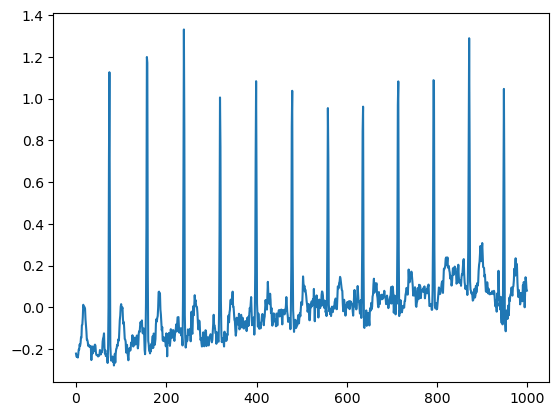

tensor([[[-2.1900e-01, -2.1300e-01, -2.0900e-01,  ...,  1.5200e-01,
           6.2200e-01,  8.0400e-01]],

        [[-1.6700e-01, -1.9200e-01, -1.8200e-01,  ...,  2.9500e-01,
           1.1560e+00,  1.4690e+00]],

        [[ 2.1000e-02,  2.5000e-02,  2.5000e-02,  ..., -5.3000e-02,
          -6.1000e-02, -2.4000e-02]],

        ...,

        [[-7.6000e-02, -8.3000e-02, -7.8000e-02,  ...,  1.1000e-02,
           1.0000e-03, -1.9600e-01]],

        [[-1.3600e-01, -1.0900e-01, -8.6000e-02,  ..., -2.4000e-02,
           1.4000e-02,  1.0000e-03]],

        [[ 3.0000e-02,  3.3000e-02,  5.3000e-02,  ...,  7.7000e-02,
           9.7000e-02,  1.2900e-01]]], device='cuda:0')


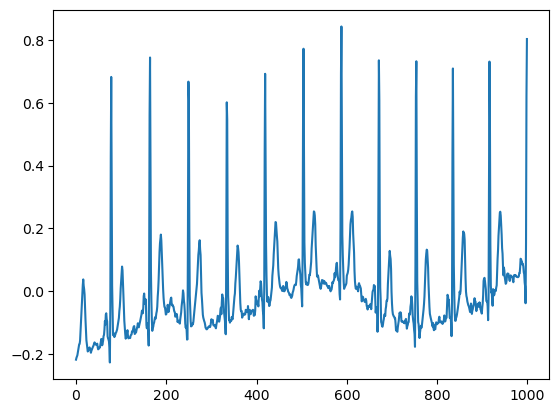

tensor([[[-0.0550, -0.0260, -0.0220,  ...,  0.0330,  0.0230,  0.0380]],

        [[ 0.0210,  0.0220,  0.0150,  ..., -0.0410, -0.0520, -0.0460]],

        [[-0.1660, -0.1160, -0.0730,  ..., -0.0350, -0.1260, -0.2890]],

        ...,

        [[-0.1290, -0.1240, -0.1160,  ...,  0.0090,  0.0290,  0.0410]],

        [[ 0.0370,  0.0340,  0.1230,  ..., -0.3620, -0.0320,  0.0810]],

        [[-0.0560, -0.0590, -0.0550,  ..., -0.0750, -0.0650, -0.0880]]],
       device='cuda:0')


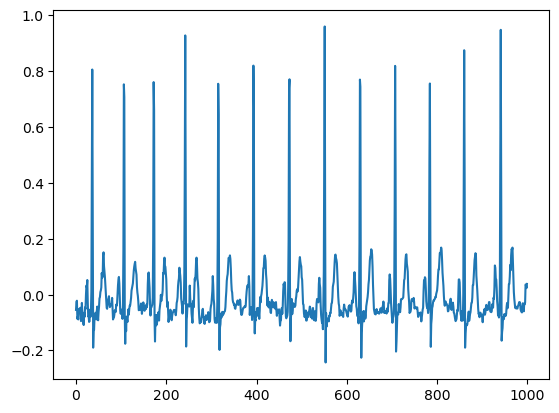

tensor([[[-0.0200, -0.0210, -0.0230,  ...,  0.1400,  0.0330,  0.0420]],

        [[ 0.1990,  0.2300,  0.2550,  ..., -0.1040, -0.0690, -0.0180]],

        [[-0.0730, -0.0790, -0.1040,  ...,  0.1080,  0.0790,  0.0480]],

        ...,

        [[ 0.0010,  0.0050,  0.0080,  ..., -0.0430, -0.0930,  0.0010]],

        [[ 0.2500,  0.2450,  0.2270,  ..., -0.2080,  0.0390,  0.0590]],

        [[-0.1200, -0.1370, -0.1800,  ..., -0.1430, -0.1460, -0.1120]]],
       device='cuda:0')


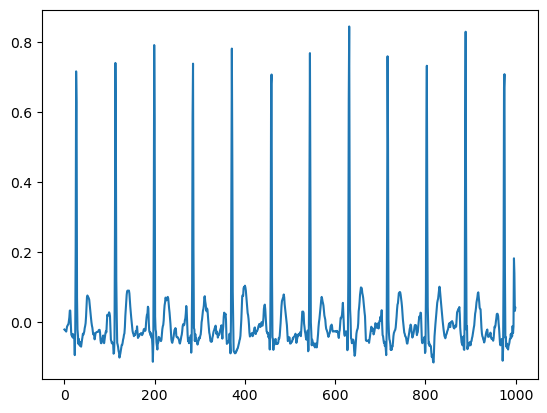

tensor([[[-0.0370, -0.0120, -0.0400,  ..., -0.0160, -0.0470, -0.0240]],

        [[-0.0700, -0.0690, -0.0670,  ..., -0.0810, -0.1360, -0.1570]],

        [[ 0.0510,  0.0310,  0.0510,  ...,  0.0610,  0.1100,  0.0800]],

        ...,

        [[-0.0400, -0.0400, -0.0400,  ...,  0.0830,  0.0710,  0.1300]],

        [[-0.0380, -0.0200, -0.0210,  ..., -0.0630, -0.0190,  0.0130]],

        [[ 0.0740,  0.0760,  0.0920,  ..., -0.0980, -0.0510, -0.1450]]],
       device='cuda:0')


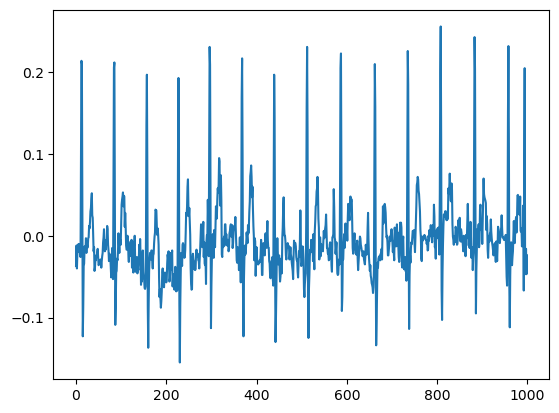

tensor([[[ 0.6010,  0.3170, -0.0100,  ..., -0.0580, -0.0670, -0.0770]],

        [[ 0.0890,  0.0670,  0.0380,  ..., -0.0740, -0.0560, -0.0390]],

        [[-0.0510, -0.0530, -0.0530,  ...,  0.1590,  0.2090,  0.2240]],

        ...,

        [[-0.0970, -0.0440, -0.0540,  ..., -0.0800, -0.0720, -0.1720]],

        [[ 0.1290,  0.1440,  0.1520,  ...,  0.0680, -0.0350, -0.0550]],

        [[-0.0850, -0.0900, -0.0660,  ...,  0.0420,  0.0070, -0.0200]]],
       device='cuda:0')


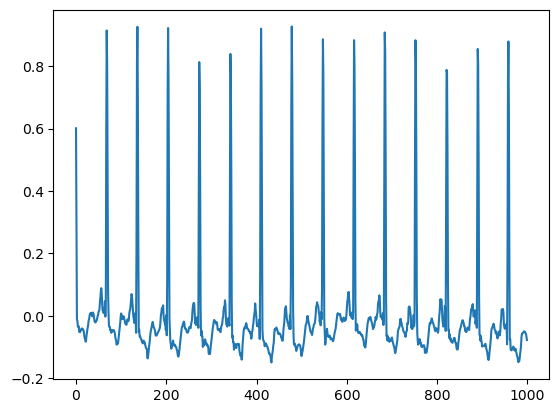

tensor([[[-0.1100, -0.1260, -0.0730,  ...,  0.0160,  0.0070,  0.0100]],

        [[ 0.0460,  0.0520,  0.0610,  ..., -0.0660, -0.0550, -0.0830]],

        [[-0.1690, -0.1730, -0.1910,  ...,  0.0310,  0.0310,  0.0720]],

        ...,

        [[-0.0170, -0.0340, -0.0450,  ...,  0.3960,  0.8690,  0.5820]],

        [[ 0.2080,  0.1950,  0.1840,  ...,  0.0960,  0.1080,  0.1110]],

        [[-0.0660, -0.0970, -0.0860,  ...,  0.1000,  0.1360,  0.1330]]],
       device='cuda:0')


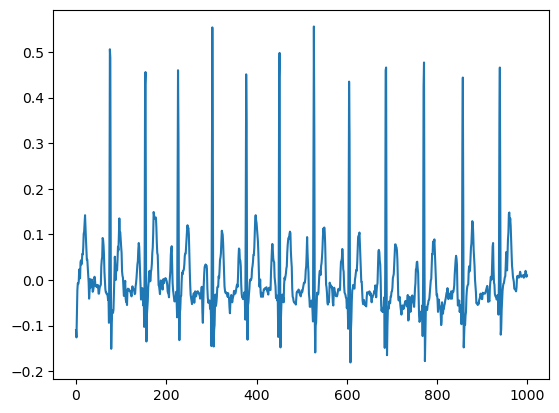

tensor([[[-0.0050, -0.0050, -0.0050,  ..., -0.0390, -0.1020, -0.1040]],

        [[ 0.0280,  0.0410,  0.0290,  ..., -0.0050,  0.0160,  0.0470]],

        [[-0.1350, -0.1350, -0.1350,  ...,  0.1090,  0.1060,  0.1160]],

        ...,

        [[-0.2990, -0.2940, -0.2920,  ..., -0.1560, -0.1550, -0.1970]],

        [[ 0.1990,  0.1790,  0.1440,  ...,  0.0140,  0.0140,  0.0220]],

        [[-0.0130, -0.0180, -0.0100,  ...,  0.0640,  0.0550,  0.0300]]],
       device='cuda:0')


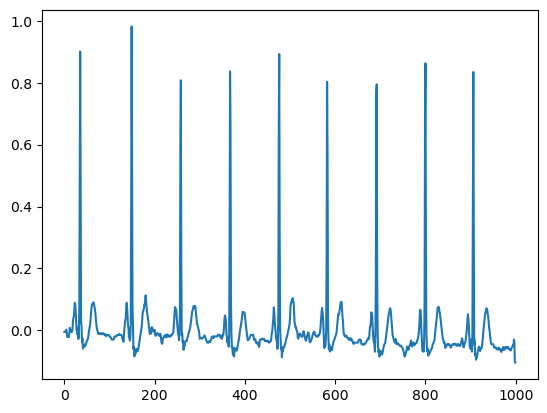

tensor([[[-0.0750, -0.1070, -0.0780,  ...,  0.0520,  0.0440,  0.0190]],

        [[ 0.0020,  0.0210,  0.0520,  ..., -0.0040, -0.0120, -0.0500]],

        [[-0.0440, -0.0350, -0.0280,  ..., -0.0470, -0.0540, -0.0510]],

        ...,

        [[-0.0420, -0.0350, -0.0220,  ...,  0.0630, -0.0570, -0.0040]],

        [[ 0.1600,  0.4280,  0.8990,  ..., -0.0770, -0.0550, -0.0630]],

        [[ 0.1640,  0.1530,  0.1360,  ..., -0.0590, -0.0160, -0.0240]]],
       device='cuda:0')


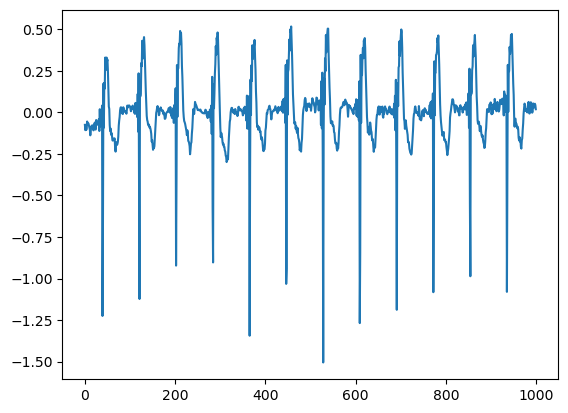

tensor([[[-0.1840, -0.1790, -0.1730,  ...,  0.1030,  0.1210,  0.1170]],

        [[ 0.1510,  0.1270,  0.0130,  ..., -0.0110, -0.0320, -0.0450]],

        [[-0.0480, -0.0380, -0.0400,  ...,  0.0580,  0.0490,  0.0430]],

        ...,

        [[-0.0890, -0.0890, -0.1020,  ..., -0.0440, -0.0450, -0.0170]],

        [[ 0.1200,  0.1180,  0.1270,  ..., -0.2370, -0.2230, -0.2060]],

        [[-0.1050, -0.1020, -0.0920,  ...,  0.1890,  0.7060,  0.9770]]],
       device='cuda:0')


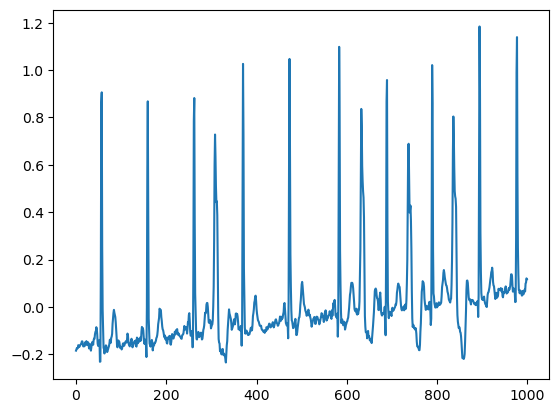

tensor([[[ 0.6390,  0.3760,  0.1540,  ...,  0.3820,  0.2810, -0.0530]],

        [[ 0.1610,  0.1150,  0.0590,  ..., -0.0120, -0.0180, -0.0040]],

        [[-0.0150, -0.0150, -0.0150,  ...,  0.8020,  0.9290,  0.4010]],

        ...,

        [[-0.0600, -0.0560, -0.0510,  ...,  0.0260,  0.0370,  0.0360]],

        [[-0.1220, -0.1230, -0.1150,  ...,  0.0490,  0.0620,  0.0790]],

        [[-0.1130, -0.1060, -0.0880,  ...,  0.0350,  0.0240,  0.0570]]],
       device='cuda:0')


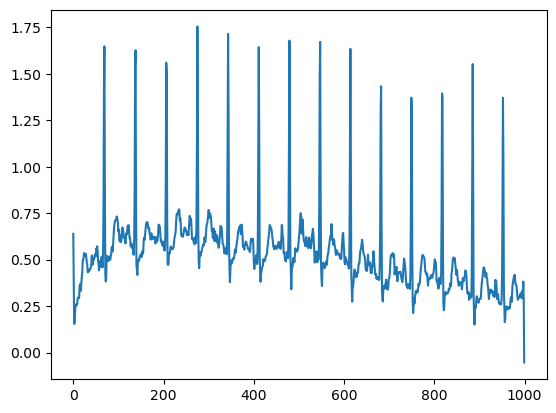

tensor([[[-0.0400, -0.0400, -0.0400,  ..., -0.0360, -0.0300, -0.0340]],

        [[ 0.0160,  0.0140,  0.0570,  ...,  0.0710,  0.0400,  0.0200]],

        [[ 0.3290,  0.3400,  0.3570,  ..., -0.0560, -0.0220, -0.0380]],

        ...,

        [[-0.1850, -0.2250, -0.2030,  ..., -0.0370, -0.0530, -0.0710]],

        [[ 0.0470,  0.0480,  0.0450,  ..., -0.0610, -0.0830, -0.1680]],

        [[-0.0150, -0.0200, -0.0180,  ..., -0.0970, -0.1080, -0.1270]]],
       device='cuda:0')


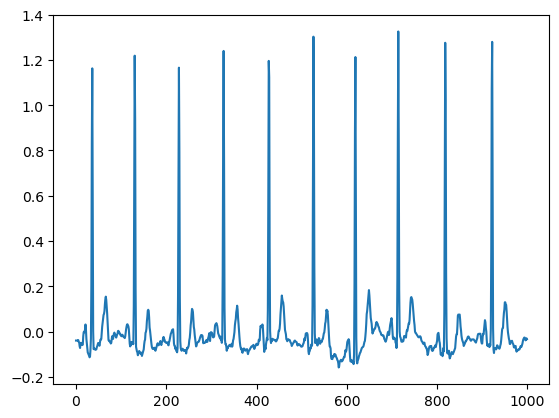

tensor([[[ 0.0090, -0.0030, -0.0040,  ...,  0.2250,  0.1870, -0.0840]],

        [[ 0.0600,  0.0520,  0.0420,  ..., -0.0560, -0.0460, -0.0480]],

        [[-0.5180, -0.5200, -0.5570,  ...,  1.2600,  1.0040,  0.7000]],

        ...,

        [[-0.1870, -0.1200, -0.0220,  ..., -0.1240, -0.1320, -0.1180]],

        [[ 0.0700,  0.0790,  0.1040,  ...,  0.1230,  0.1350,  0.1070]],

        [[-0.1790, -0.1780, -0.1730,  ..., -0.2110, -0.2370, -0.2150]]],
       device='cuda:0')


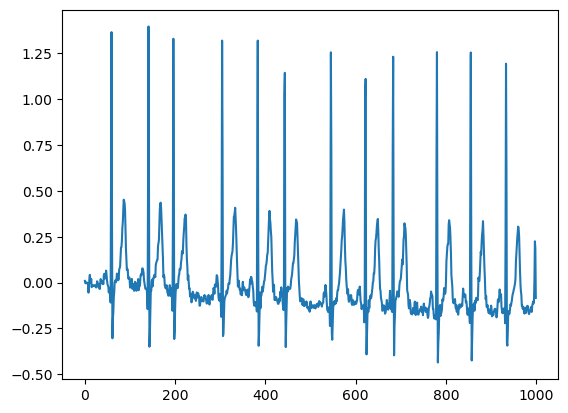

tensor([[[-0.0230, -0.0110, -0.0300,  ...,  0.0020, -0.0220, -0.0380]],

        [[ 0.0120,  0.0100,  0.0180,  ..., -0.0850, -0.0920, -0.0810]],

        [[-0.0170, -0.0370, -0.0440,  ..., -0.1440, -0.1520, -0.1500]],

        ...,

        [[-0.0840, -0.0670, -0.0610,  ..., -0.1220,  0.0710,  0.7140]],

        [[-0.1470, -0.1830, -0.1230,  ..., -0.0660, -0.0870, -0.1030]],

        [[-0.0490, -0.0450, -0.0470,  ..., -0.0160,  0.3730,  0.3580]]],
       device='cuda:0')


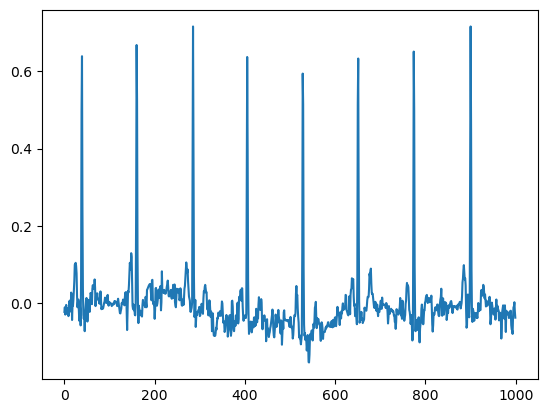

tensor([[[ 0.2000,  0.2100,  0.2180,  ..., -0.3100, -0.3090, -0.3090]],

        [[-0.1500, -0.1520, -0.1540,  ...,  0.0490,  0.0470,  0.0470]],

        [[ 0.0130,  0.0100,  0.0490,  ..., -0.0480, -0.0410, -0.0460]],

        ...,

        [[-0.0650, -0.0640, -0.0500,  ..., -0.1340, -0.1250, -0.1400]],

        [[-0.0040,  0.0030,  0.0060,  ...,  0.0650,  0.0350, -0.0700]],

        [[ 0.0170,  0.0350,  0.0440,  ..., -0.2710, -0.0850,  0.2760]]],
       device='cuda:0')


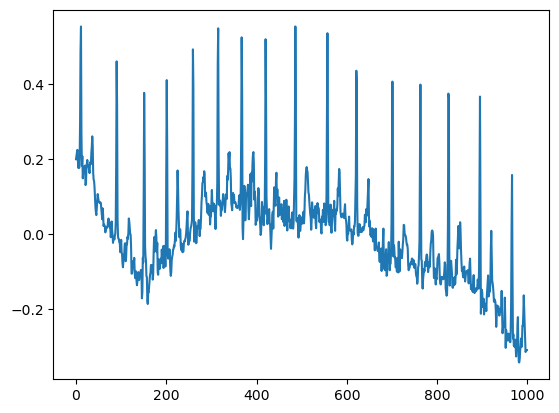

tensor([[[-0.0310, -0.0230, -0.0090,  ...,  0.0880,  0.0580,  0.0210]],

        [[ 0.0300,  0.0240,  0.0150,  ...,  0.1000,  0.1910,  0.1650]],

        [[-0.0550, -0.0520, -0.0430,  ..., -0.2200, -0.1790, -0.1380]],

        ...,

        [[-0.0580, -0.0190, -0.0210,  ..., -0.0640, -0.2210, -0.1270]],

        [[-0.0310, -0.0420, -0.0590,  ...,  0.0010,  0.0030,  0.0110]],

        [[ 0.0750,  0.1110,  0.1070,  ...,  0.0080,  0.0320,  0.0710]]],
       device='cuda:0')


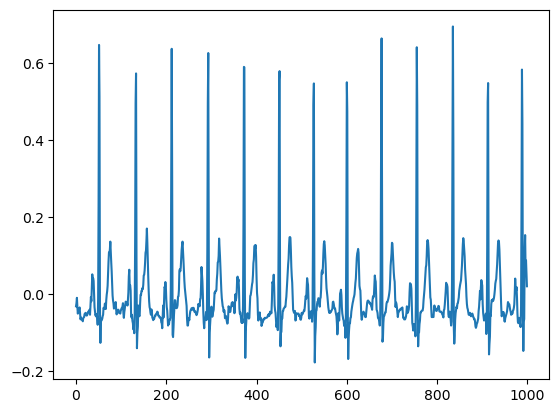

tensor([[[ 0.0090,  0.0050,  0.0050,  ..., -0.0360, -0.0380, -0.0290]],

        [[ 0.0330,  0.0200,  0.0180,  ..., -0.0670, -0.0530, -0.0340]],

        [[-0.0090, -0.0760, -0.1220,  ..., -0.1050, -0.1040, -0.1010]],

        ...,

        [[-0.2130, -0.2090, -0.2020,  ...,  0.1400,  0.0780,  0.0390]],

        [[ 0.1390,  0.1330,  0.0110,  ..., -0.0210, -0.0150,  0.0050]],

        [[ 0.0430,  0.0730,  0.1460,  ...,  0.0280,  0.0150,  0.0150]]],
       device='cuda:0')


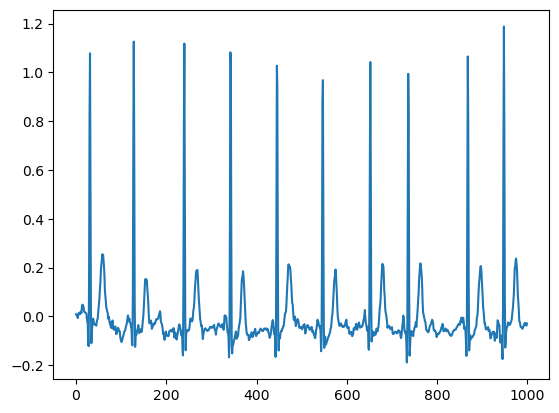

tensor([[[ 0.0400,  0.0470,  0.0530,  ...,  0.0130,  0.0100,  0.0120]],

        [[ 0.0590,  0.0190, -0.0180,  ...,  0.1140,  0.1400,  0.1670]],

        [[ 0.1590,  0.4640,  0.8900,  ..., -0.0760, -0.0730,  0.2860]],

        ...,

        [[-0.1600, -0.1650, -0.1770,  ..., -0.2020, -0.0470,  0.4130]],

        [[-0.1870, -0.2030, -0.2350,  ...,  0.0560,  0.0360,  0.0500]],

        [[ 0.1200,  0.1080,  0.0680,  ..., -0.1570, -0.1570, -0.1470]]],
       device='cuda:0')


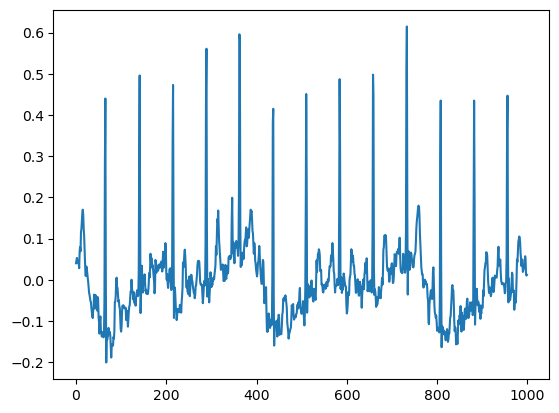

tensor([[[-0.0690, -0.0580, -0.0320,  ..., -0.0060, -0.0020,  0.0070]],

        [[ 0.0650,  0.0640,  0.0640,  ...,  0.1880,  0.1900,  0.1610]],

        [[ 0.0100,  0.0170,  0.0350,  ..., -0.1520, -0.1520, -0.1440]],

        ...,

        [[-0.1050, -0.1050, -0.1010,  ..., -0.1910, -0.1040,  0.0350]],

        [[-0.0260, -0.0350, -0.0320,  ..., -0.0430, -0.0430, -0.0310]],

        [[-0.0790, -0.0970, -0.0930,  ...,  0.0250,  0.0070, -0.0010]]],
       device='cuda:0')


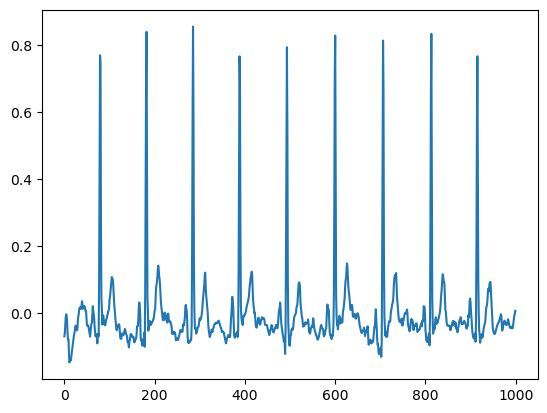

tensor([[[ 0.1310,  0.1560,  0.2160,  ..., -0.1550, -0.1570, -0.1670]],

        [[-0.0380, -0.0460, -0.0620,  ...,  0.1080,  0.1590,  0.1860]],

        [[-0.0220, -0.0330, -0.0660,  ...,  0.1490, -0.0080,  0.0130]],

        ...,

        [[-0.0730, -0.0850, -0.1220,  ...,  0.0030,  0.0020, -0.0570]],

        [[-0.0200,  0.0060,  0.0260,  ...,  0.0860, -0.0940,  0.0890]],

        [[-0.1570, -0.1690, -0.1470,  ..., -0.0220, -0.0840, -0.0840]]],
       device='cuda:0')


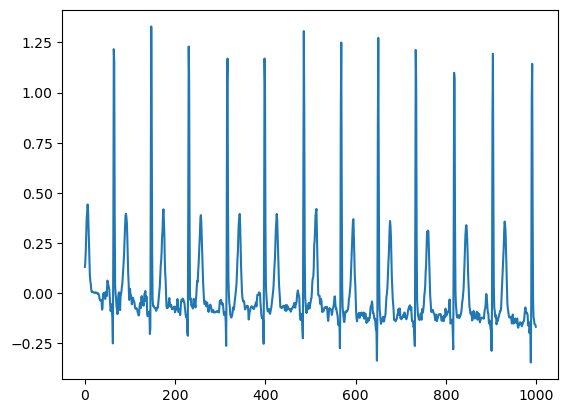

tensor([[[-0.0340, -0.0320, -0.0260,  ..., -0.0130, -0.0170, -0.0190]],

        [[ 0.2290,  0.2390,  0.2670,  ..., -0.3330, -0.4170, -0.4580]],

        [[-0.1350, -0.1380, -0.1470,  ...,  0.0050,  0.0120,  0.0070]],

        ...,

        [[ 0.6750,  0.6440,  0.2880,  ..., -0.0420, -0.0390, -0.0410]],

        [[ 0.0360,  0.0140, -0.0110,  ...,  0.0380,  0.0320,  0.1000]],

        [[-0.1850, -0.1850, -0.1850,  ...,  0.1730,  0.2350,  0.4300]]],
       device='cuda:0')


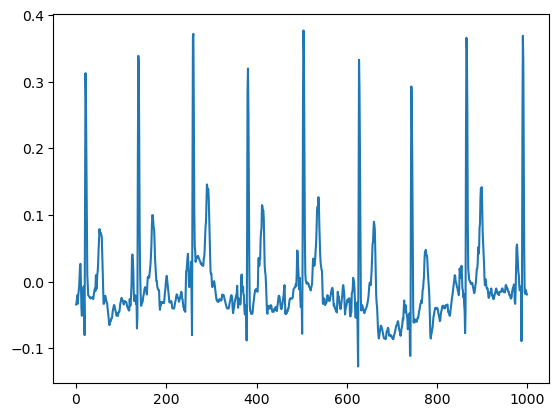

tensor([[[ 0.0220,  0.0160,  0.0510,  ..., -0.1670, -0.0580,  0.1190]],

        [[-0.4330, -0.5090, -0.5350,  ..., -0.2800, -0.2900, -0.3750]],

        [[ 0.0450,  0.0510,  0.0510,  ...,  0.0470,  0.0520,  0.0520]],

        ...,

        [[-0.0740, -0.0630, -0.0430,  ..., -0.0420, -0.0410, -0.0530]],

        [[-0.0500, -0.0490, -0.0450,  ..., -0.0350, -0.0290, -0.0550]],

        [[-0.0210, -0.0170, -0.0130,  ..., -0.0360,  0.0710,  0.0130]]],
       device='cuda:0')


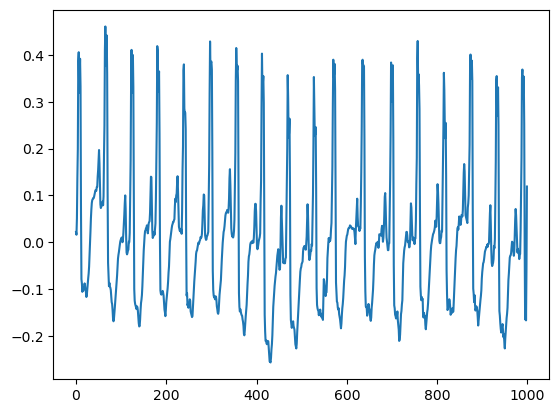

tensor([[[ 0.0510,  0.0360,  0.0130,  ...,  0.2880,  0.2790,  0.2900]],

        [[-0.0580, -0.0440, -0.0400,  ..., -0.0400,  0.3490,  0.3930]],

        [[-0.0040,  0.0040,  0.0080,  ..., -0.2120, -0.2200, -0.1790]],

        ...,

        [[ 0.1170,  0.0720,  0.0890,  ...,  0.0340,  0.0080,  0.0230]],

        [[ 0.0700,  0.0800,  0.0960,  ...,  0.0240,  0.0220, -0.0160]],

        [[-0.0730, -0.0730, -0.1260,  ...,  0.5020,  0.1480, -0.0240]]],
       device='cuda:0')


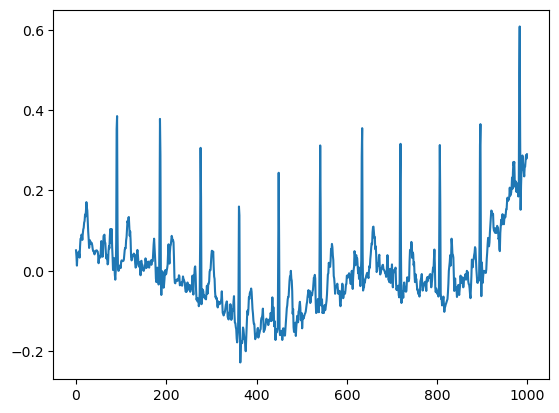

tensor([[[-0.0200, -0.0260, -0.0330,  ..., -0.1180, -0.1020, -0.1240]],

        [[-0.0570, -0.0750, -0.0910,  ..., -0.0680, -0.0080, -0.0560]],

        [[-0.0200, -0.0110, -0.0200,  ..., -0.1110, -0.1130, -0.1160]],

        ...,

        [[ 0.0410,  0.0460,  0.0540,  ..., -0.0510, -0.1970, -0.1870]],

        [[-0.0560, -0.0470, -0.0320,  ..., -0.1090, -0.2350, -0.1900]],

        [[ 0.8100,  0.4910, -0.0220,  ..., -0.0710, -0.0760, -0.0720]]],
       device='cuda:0')


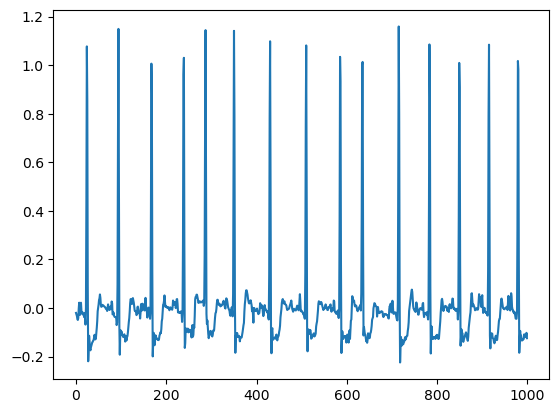

tensor([[[-0.0540, -0.0430, -0.0280,  ..., -0.0550, -0.0060, -0.0620]],

        [[ 0.0000, -0.0050, -0.0120,  ...,  0.0030,  0.1790,  0.5260]],

        [[ 0.0270,  0.0330,  0.0080,  ..., -0.1440, -0.2370, -0.2200]],

        ...,

        [[ 0.1470,  0.1040,  0.0550,  ..., -0.0550, -0.0470, -0.0330]],

        [[ 0.0340,  0.0310,  0.0310,  ..., -0.0950, -0.0620, -0.0470]],

        [[-0.0010,  0.0000,  0.0090,  ..., -0.1010, -0.0860,  0.2000]]],
       device='cuda:0')


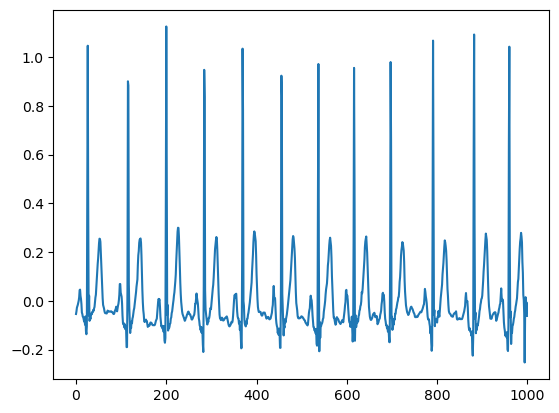

tensor([[[ 0.0360,  0.0440,  0.0650,  ...,  0.1150,  0.0830,  0.0650]],

        [[-0.0150, -0.0150, -0.0150,  ...,  0.0420,  0.0550,  0.0800]],

        [[-0.2920, -0.2870, -0.2440,  ..., -0.1180, -0.1400, -0.1330]],

        ...,

        [[-0.1210, -0.1520, -0.1040,  ..., -0.0260, -0.0050,  0.0610]],

        [[-0.0550, -0.0450, -0.0270,  ..., -0.1120, -0.1520,  0.2030]],

        [[-0.0650, -0.0650, -0.0650,  ...,  0.1140,  0.0930,  0.1560]]],
       device='cuda:0')


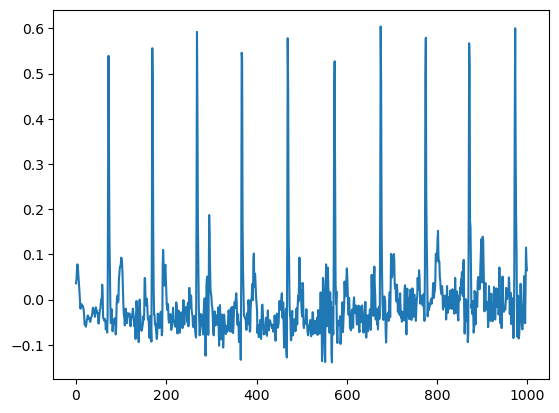

tensor([[[-0.0640, -0.0530, -0.0320,  ...,  0.1330, -0.0650, -0.2850]],

        [[-0.4510, -0.4670, -0.4380,  ..., -0.0960, -0.0940, -0.1010]],

        [[-0.0850, -0.0850, -0.0710,  ..., -0.0060,  0.0170,  0.0820]],

        ...,

        [[-0.0450, -0.0570, -0.0840,  ...,  0.1330,  0.0790,  0.0280]],

        [[ 0.0610,  0.0660,  0.0700,  ...,  0.0620,  0.0790,  0.0740]],

        [[-0.0500, -0.0460, -0.0390,  ...,  0.0070, -0.0030, -0.0020]]],
       device='cuda:0')


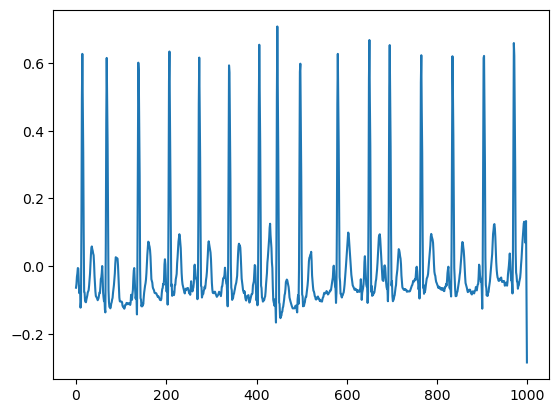

tensor([[[-0.2300, -0.2240, -0.2170,  ..., -0.0430, -0.0630,  0.0780]],

        [[ 0.1240,  0.4180,  0.8480,  ..., -0.0750, -0.0950, -0.0970]],

        [[-0.1220, -0.1250, -0.1460,  ..., -0.3030, -0.2690, -0.2890]],

        ...,

        [[ 0.0750,  0.0790,  0.0720,  ..., -0.0040, -0.0130, -0.0030]],

        [[-0.0870, -0.1080, -0.1170,  ..., -0.1560, -0.1250, -0.1020]],

        [[-0.0350, -0.0330, -0.0270,  ...,  0.0940,  0.0710,  0.1970]]],
       device='cuda:0')


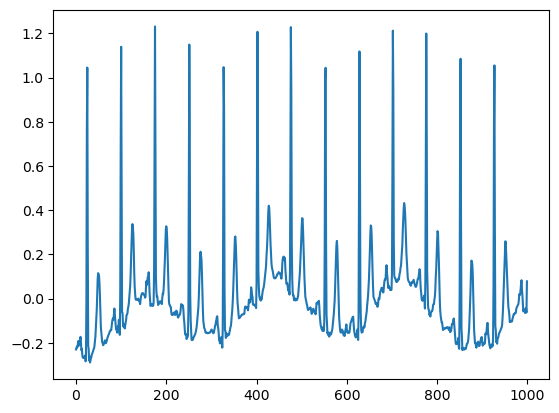

tensor([[[ 0.1470, -0.0210, -0.1390,  ...,  0.0270,  0.0380,  0.0520]],

        [[ 0.1000,  0.1000,  0.1030,  ...,  0.0720,  0.0220, -0.1470]],

        [[-0.0050, -0.0080, -0.0140,  ..., -0.0220,  0.0340, -0.0090]],

        ...,

        [[ 0.0990,  0.0620,  0.0090,  ..., -0.0650, -0.0920, -0.1100]],

        [[ 0.0030, -0.0220, -0.0100,  ...,  0.0240,  0.0060,  0.0290]],

        [[ 0.0460,  0.0680,  0.1110,  ..., -0.0300,  0.0200,  0.0380]]],
       device='cuda:0')


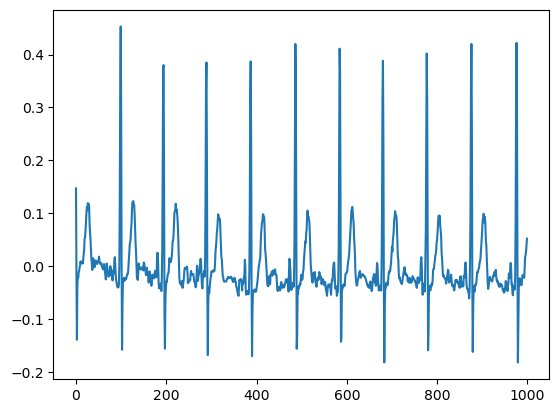

tensor([[[-0.0110,  0.0010,  0.0500,  ...,  0.1270,  0.1260,  0.0800]],

        [[-0.0290, -0.0240, -0.0160,  ..., -0.0850, -0.0830, -0.0710]],

        [[-0.0150,  0.0130,  0.0170,  ...,  0.1260,  0.1030,  0.0750]],

        ...,

        [[ 0.0290,  0.1070,  0.0660,  ..., -0.0030,  0.1410, -0.1570]],

        [[ 0.2420,  0.2620,  0.2950,  ...,  0.0290,  0.0200, -0.0010]],

        [[-0.0320, -0.0360, -0.0380,  ..., -0.0810, -0.1990, -0.0200]]],
       device='cuda:0')


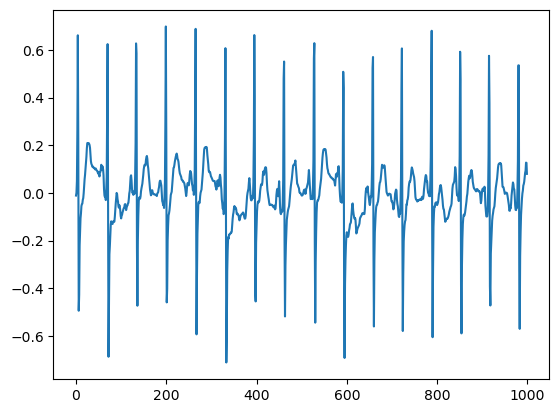

tensor([[[ 0.1820,  0.4120,  0.4750,  ..., -0.0310, -0.0300, -0.0200]],

        [[ 0.0750,  0.0790,  0.0330,  ..., -0.1130, -0.0970,  0.0100]],

        [[-0.0530, -0.0550, -0.0760,  ..., -0.0060, -0.0060, -0.0070]],

        ...,

        [[-0.0250, -0.0200, -0.0080,  ..., -0.0770, -0.0910, -0.0690]],

        [[ 0.0600,  0.0530,  0.0630,  ..., -0.0840, -0.0660, -0.1140]],

        [[ 0.0160,  0.0260,  0.0320,  ...,  0.1520,  0.0660, -0.0840]]],
       device='cuda:0')


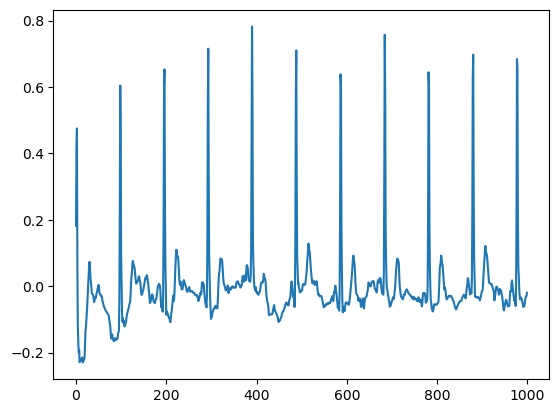

tensor([[[-0.0590,  0.0800,  0.5610,  ...,  0.0380,  0.0690,  0.0880]],

        [[ 0.0250,  0.0290,  0.0180,  ...,  0.9120,  0.5490,  0.0060]],

        [[-0.0560, -0.0550, -0.0680,  ..., -0.0480, -0.0140,  0.0370]],

        ...,

        [[-0.2050, -0.2030, -0.1970,  ...,  0.0910,  0.0880,  0.0770]],

        [[-0.0940, -0.0840, -0.0680,  ..., -0.0550, -0.0600, -0.1790]],

        [[-0.0830, -0.1180, -0.1330,  ..., -0.2140,  0.1340,  0.2450]]],
       device='cuda:0')


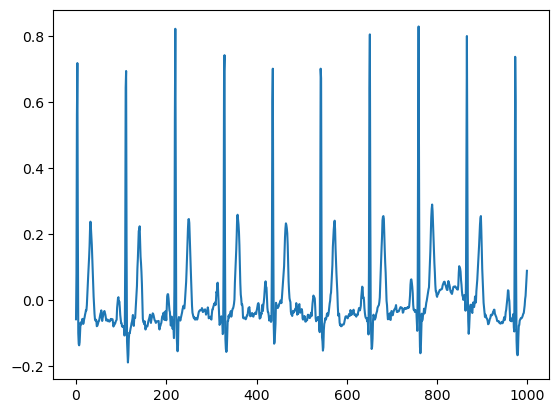

tensor([[[-0.0700, -0.0580, -0.0270,  ..., -0.1790, -0.2300, -0.1110]],

        [[-0.1480, -0.1390, -0.1520,  ...,  1.3420,  1.5440,  1.0350]],

        [[-0.1050, -0.0950, -0.0820,  ..., -0.0030,  0.1230,  0.4600]],

        ...,

        [[-1.2690, -1.2680, -1.2640,  ..., -1.2050, -1.2050, -1.2030]],

        [[-0.0940, -0.0420, -0.0110,  ..., -0.0170,  0.0100, -0.0150]],

        [[-0.1300, -0.1300, -0.1270,  ...,  0.0290, -0.0360, -0.0460]]],
       device='cuda:0')


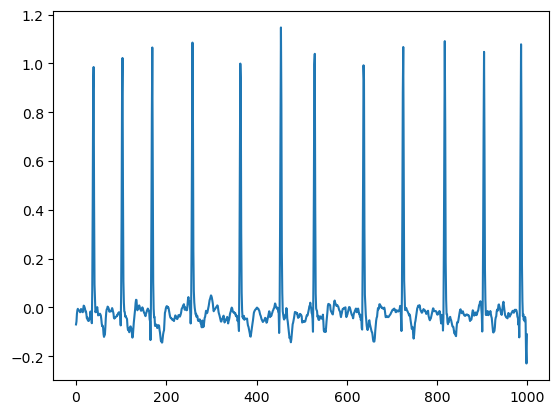

tensor([[[-0.0450, -0.0940, -0.0900,  ..., -0.0230, -0.0210, -0.0120]],

        [[-0.4750, -0.4650, -0.4830,  ...,  0.0610,  0.0310,  0.0600]],

        [[ 0.0610,  0.0580,  0.0620,  ..., -0.1090, -0.0680, -0.2160]],

        ...,

        [[-0.1060, -0.1100, -0.0950,  ..., -0.0960, -0.0820, -0.0630]],

        [[ 0.0060,  0.0000, -0.0290,  ..., -0.0650, -0.0790, -0.0830]],

        [[ 0.2650,  0.7960,  1.0950,  ..., -0.0910, -0.0650, -0.0580]]],
       device='cuda:0')


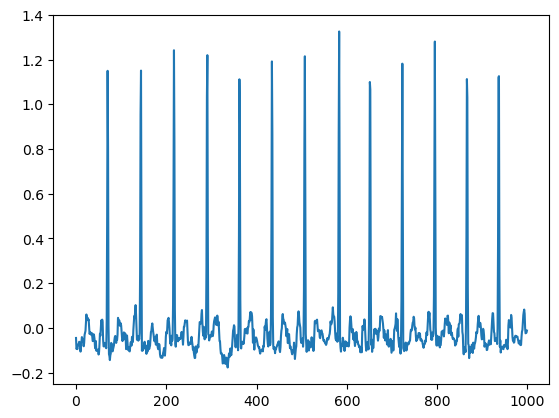

tensor([[[-0.1420, -0.1080, -0.0900,  ...,  0.0080, -0.0620, -0.0550]],

        [[ 0.0010, -0.0060, -0.0220,  ..., -0.1140, -0.1210, -0.1190]],

        [[-0.2500, -0.2450, -0.2330,  ..., -0.1180, -0.1030, -0.1000]],

        ...,

        [[ 0.0240,  0.0160,  0.0400,  ..., -0.0610, -0.0690, -0.0610]],

        [[ 0.0240,  0.0690,  0.0080,  ...,  0.0420, -0.0820, -0.0760]],

        [[-0.0050, -0.0050, -0.0050,  ..., -0.1040, -0.1150, -0.1000]]],
       device='cuda:0')


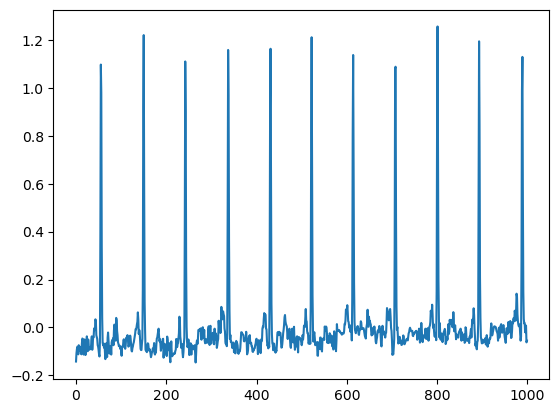

tensor([[[-0.0100,  0.0010,  0.0150,  ..., -0.0330, -0.0250,  0.0220]],

        [[ 0.0310,  0.0440,  0.0730,  ..., -0.0750, -0.0750, -0.0750]],

        [[ 0.2940,  0.2880,  0.2810,  ..., -0.0300, -0.0250, -0.0640]],

        ...,

        [[-0.0260, -0.0350, -0.0350,  ...,  0.0530,  0.0760,  0.0980]],

        [[ 0.0110,  0.0170,  0.0090,  ..., -0.0200, -0.0220, -0.0300]],

        [[-0.0510, -0.0470, -0.0250,  ..., -0.0200,  0.1500,  0.1830]]],
       device='cuda:0')


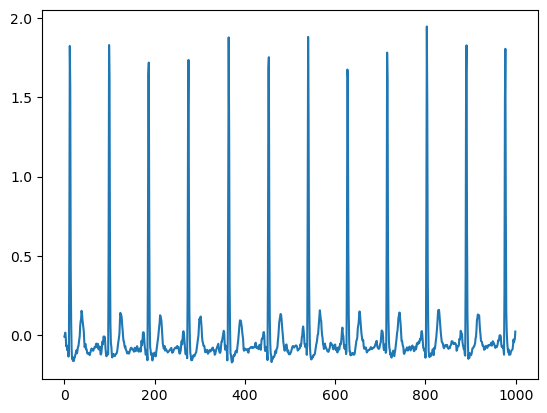

tensor([[[-0.1760, -0.2080, -0.2160,  ...,  0.0080, -0.0120,  0.0000]],

        [[-0.2300, -0.2100, -0.2030,  ...,  0.1430,  0.1770,  0.1620]],

        [[-0.0950, -0.0940, -0.0900,  ..., -0.0400, -0.0410, -0.0460]],

        ...,

        [[ 0.4660,  0.0380, -0.2060,  ..., -0.0750, -0.0550, -0.0650]],

        [[ 0.0090, -0.0130, -0.0500,  ...,  0.1910,  0.2130,  0.2160]],

        [[ 0.0640,  0.0670, -0.0090,  ...,  0.0070, -0.1930, -1.1870]]],
       device='cuda:0')


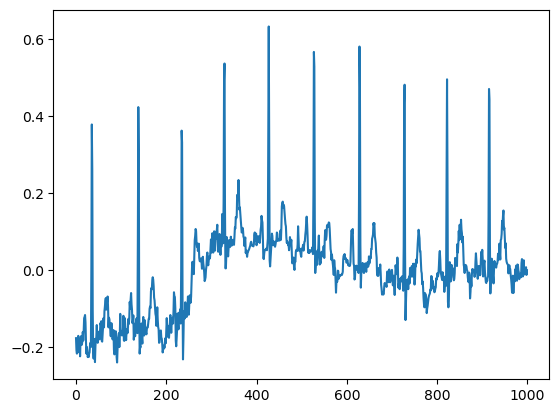

tensor([[[-0.0990, -0.1040,  0.1340,  ..., -0.1250, -0.0610, -0.0540]],

        [[ 0.0150,  0.0140,  0.0150,  ...,  0.0370, -0.0250, -0.0910]],

        [[-0.0030, -0.0090, -0.0420,  ..., -0.0080,  0.0240,  0.0320]],

        ...,

        [[-0.0360, -0.0200, -0.0060,  ...,  0.0290,  0.0410,  0.0290]],

        [[-0.0340, -0.0240, -0.0050,  ..., -0.1520,  0.2280,  0.1630]],

        [[ 0.0000,  0.0000,  0.0020,  ..., -0.0760, -0.0540, -0.0940]]],
       device='cuda:0')


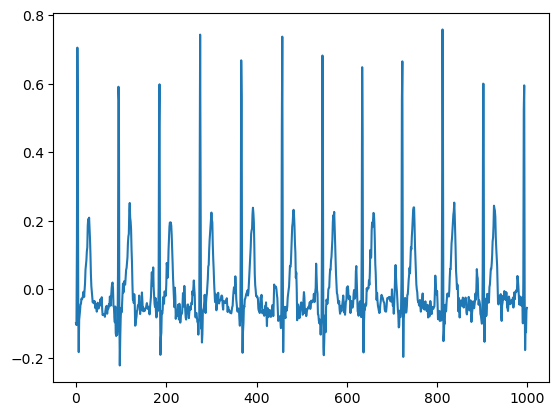

tensor([[[-0.0290, -0.0300, -0.0450,  ..., -0.0460, -0.0660, -0.1450]],

        [[ 0.0570,  0.0350, -0.0140,  ...,  0.0180,  0.0220,  0.0790]],

        [[-0.0290, -0.0220, -0.0340,  ..., -0.0250,  0.0030, -0.0030]],

        ...,

        [[ 0.1680,  0.1600,  0.1220,  ..., -0.0140, -0.0110, -0.0190]],

        [[-0.0330, -0.0460, -0.0710,  ..., -0.0510, -0.0370, -0.0580]],

        [[ 0.1410,  0.1070,  0.0500,  ..., -0.0380, -0.0220,  0.0180]]],
       device='cuda:0')


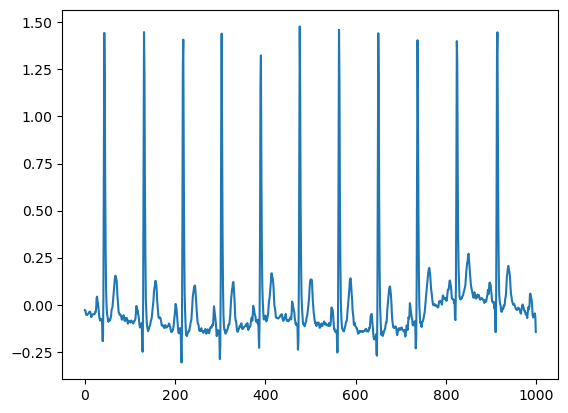

tensor([[[-0.0630, -0.0330,  0.0020,  ..., -0.1450, -0.0490, -0.3160]],

        [[ 0.0460,  0.0790,  0.0150,  ..., -0.1170, -0.1220, -0.1370]],

        [[ 0.0720,  0.0440,  0.0200,  ...,  0.2700,  0.0970, -0.0710]],

        ...,

        [[-0.0010,  0.0140,  0.0280,  ..., -0.0560, -0.0610, -0.1950]],

        [[-0.0990, -0.0730, -0.0460,  ..., -0.0690, -0.0640, -0.0490]],

        [[-0.0940,  0.0190,  0.4540,  ..., -0.1790, -0.1930, -0.2310]]],
       device='cuda:0')


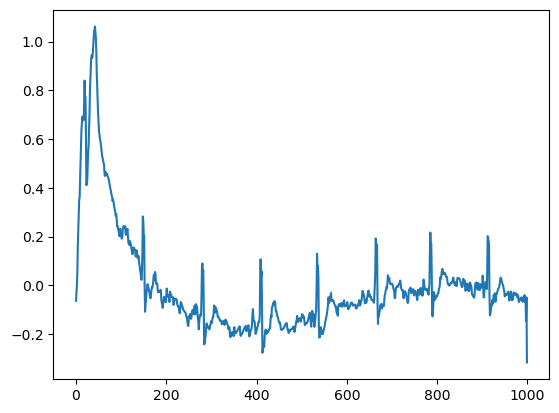

tensor([[[-0.0370, -0.0380, -0.0370,  ..., -0.0010,  0.0850,  0.0690]],

        [[-0.0200, -0.0200, -0.0200,  ..., -0.0550, -0.0560, -0.0520]],

        [[-0.0400, -0.0190, -0.0300,  ...,  0.0080,  0.0040, -0.0050]],

        ...,

        [[-0.1550, -0.1760, -0.1820,  ..., -0.1250, -0.0880,  0.0930]],

        [[-0.0100, -0.0090, -0.0080,  ...,  0.3620,  0.6940,  0.4840]],

        [[ 0.2770,  0.4720,  0.5830,  ..., -0.0070,  0.0020, -0.0330]]],
       device='cuda:0')


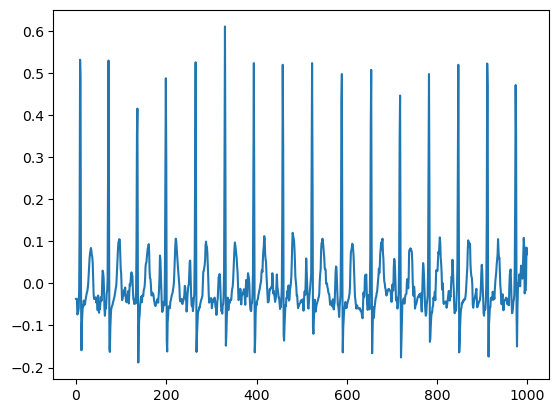

tensor([[[-0.0420, -0.0190, -0.0020,  ..., -0.0610, -0.0780, -0.0810]],

        [[ 0.2280,  0.4340,  0.5830,  ..., -0.0550, -0.0750, -0.0640]],

        [[ 0.0970,  0.1010,  0.0680,  ..., -0.0560, -0.0330, -0.0130]],

        ...,

        [[ 0.0920,  0.0820,  0.0500,  ...,  0.0060,  0.0060,  0.1880]],

        [[ 0.1420,  0.1540,  0.1630,  ...,  0.7360,  0.3570,  0.2610]],

        [[ 0.0250,  0.0360,  0.0450,  ...,  0.1360,  0.1320, -0.1060]]],
       device='cuda:0')


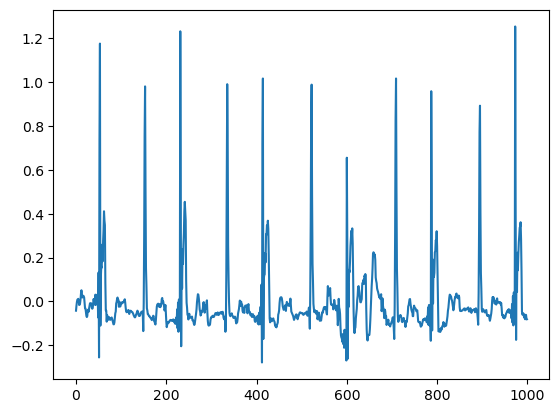

tensor([[[ 0.0900,  0.0380, -0.0100,  ..., -0.0570, -0.0640, -0.0470]],

        [[-0.0150, -0.0120, -0.0060,  ..., -0.0690, -0.0710, -0.0920]],

        [[ 0.0700,  0.0690,  0.0660,  ..., -0.2150, -0.2390, -0.2400]],

        ...,

        [[-0.0700, -0.0710, -0.0850,  ...,  0.0210, -0.0180, -0.0390]],

        [[-0.1030, -0.0890, -0.0870,  ..., -0.0450, -0.0450, -0.1090]],

        [[-0.0100, -0.0100, -0.0100,  ..., -1.3380, -0.7800, -0.1990]]],
       device='cuda:0')


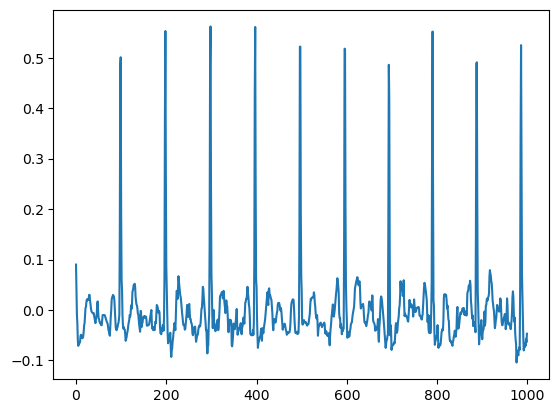

tensor([[[ 0.0000, -0.0070, -0.0180,  ..., -0.0760, -0.0800, -0.0660]],

        [[-0.0220, -0.0380, -0.0480,  ..., -0.0050, -0.0230,  0.0640]],

        [[ 0.1440,  0.1910,  0.1400,  ..., -0.0670, -0.0630, -0.0430]],

        ...,

        [[ 0.0120,  0.0180,  0.0350,  ..., -0.0280, -0.0310, -0.0350]],

        [[-0.1590, -0.1820, -0.1340,  ...,  0.2240,  0.2480,  0.2810]],

        [[-0.0700, -0.0880, -0.1130,  ...,  0.1350,  0.1040, -0.0830]]],
       device='cuda:0')


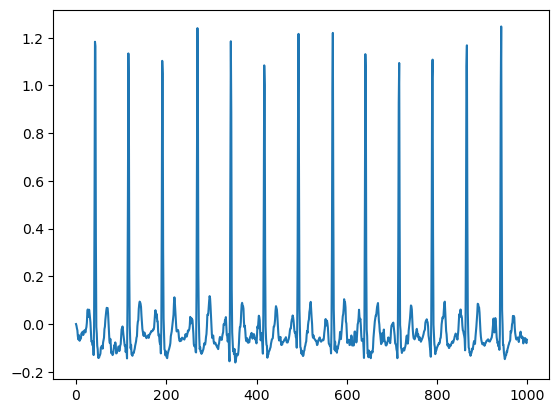

tensor([[[ 0.0050,  0.0210,  0.0000,  ..., -0.0320,  0.5600,  1.1600]],

        [[ 0.0350,  0.0410,  0.0820,  ...,  0.0150, -0.1910, -0.0140]],

        [[ 0.6710,  0.4930,  0.2150,  ...,  0.7160,  0.5810,  0.2400]],

        ...,

        [[ 0.0290,  0.0470,  0.0500,  ...,  0.0350,  0.0100,  0.0120]],

        [[-0.1140, -0.1400, -0.1450,  ...,  0.0540, -0.1890, -0.0710]],

        [[ 0.0840,  0.0640,  0.0350,  ...,  0.0000,  0.0100, -0.0600]]],
       device='cuda:0')


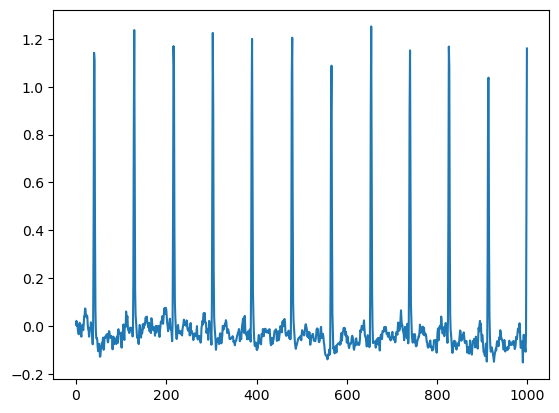

tensor([[[-0.0350, -0.0350, -0.0350,  ..., -0.1520,  0.0050, -0.1170]],

        [[-0.1110, -0.0830,  0.1040,  ..., -0.0960, -0.0790, -0.1100]],

        [[-1.0170, -0.9930, -0.9620,  ..., -0.0250, -0.0080, -0.0080]],

        ...,

        [[-0.3240, -0.3140, -0.3250,  ...,  0.3020,  0.3410,  0.3450]],

        [[-0.0350, -0.0340, -0.0360,  ...,  0.0870, -0.0130,  0.0960]],

        [[ 0.0640,  0.0980,  0.0550,  ..., -0.1340, -0.1220, -0.1400]]],
       device='cuda:0')


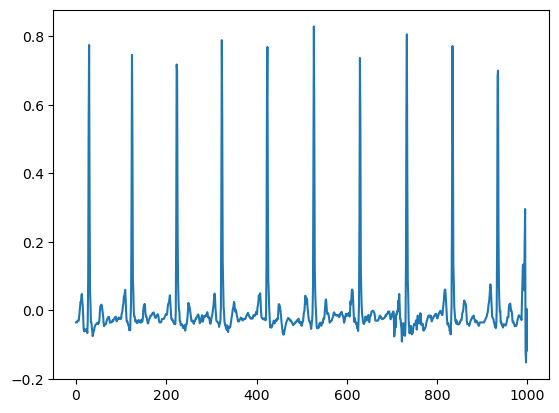

tensor([[[-0.2950, -0.2950, -0.2960,  ..., -0.4070, -0.3840, -0.4110]],

        [[-0.0610, -0.0750, -0.0950,  ..., -0.1810, -0.6790, -0.3050]],

        [[-0.0850, -0.0850, -0.0820,  ...,  0.0180,  0.0010,  0.0110]],

        ...,

        [[-0.0660, -0.0850, -0.1000,  ..., -0.1020, -0.0790, -0.0880]],

        [[ 0.2510,  0.4150,  0.5160,  ..., -0.1120, -0.1130, -0.1070]],

        [[-0.0460, -0.0490, -0.0460,  ..., -0.0430, -0.0540, -0.0900]]],
       device='cuda:0')


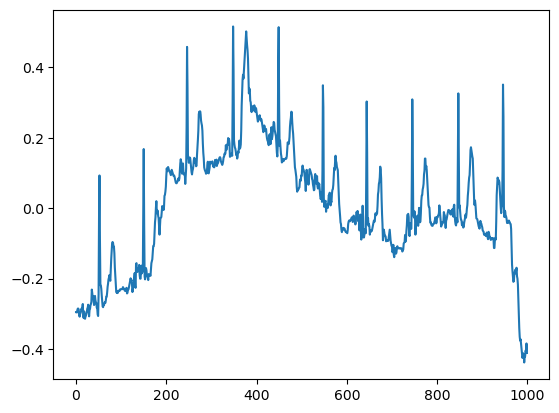

tensor([[[-0.0830, -0.0870, -0.0610,  ..., -0.0120, -0.0040, -0.0090]],

        [[-0.1750, -0.1740, -0.1600,  ...,  0.0220,  0.0460,  0.0380]],

        [[-0.0760, -0.0870, -0.0980,  ...,  0.2630,  0.1550, -0.1450]],

        ...,

        [[ 0.0310,  0.0040, -0.0050,  ..., -0.0910, -0.0940, -0.0810]],

        [[-0.0520, -0.0720, -0.0760,  ..., -0.0450,  0.0080, -0.0540]],

        [[ 0.0960,  0.0710,  0.0660,  ...,  0.2970,  0.9210,  0.8450]]],
       device='cuda:0')


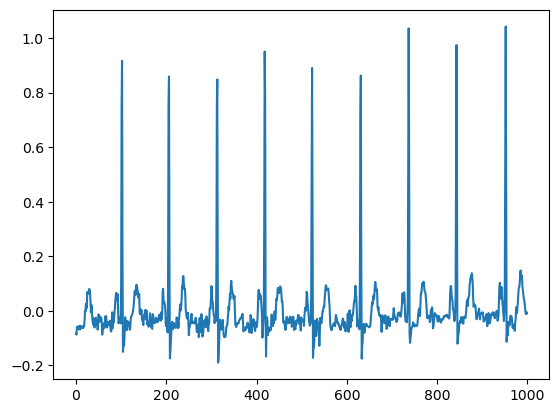

tensor([[[ 0.0040,  0.0330,  0.0180,  ..., -0.0070,  0.0000, -0.0160]],

        [[-0.0040, -0.0320, -0.0450,  ..., -0.0670, -0.0500, -0.0400]],

        [[ 0.0460,  0.0610,  0.0790,  ..., -0.7370,  0.3420,  0.0430]],

        ...,

        [[ 0.0550,  0.0810,  0.0440,  ..., -0.0340, -0.0140,  0.2800]],

        [[ 0.0340,  0.0320,  0.0440,  ..., -0.1340, -0.1110, -0.1170]],

        [[-0.0140, -0.0120, -0.0120,  ...,  0.3600,  0.2490,  0.0920]]],
       device='cuda:0')


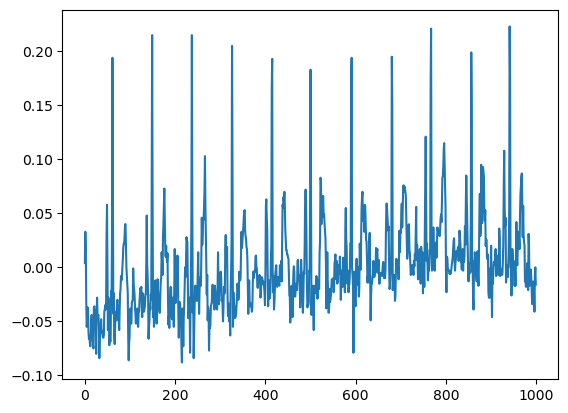

tensor([[[ 0.0700,  0.0370,  0.0170,  ...,  0.0530,  0.0450,  0.0330]],

        [[-0.1050, -0.1030, -0.0970,  ...,  0.0740,  0.1090,  0.0930]],

        [[ 0.1790,  0.1610,  0.1250,  ..., -0.3020, -0.1890,  0.1040]],

        ...,

        [[-0.0430, -0.0360, -0.0220,  ..., -0.1040, -0.0170,  0.0780]],

        [[-0.0550, -0.0310, -0.0020,  ..., -0.0220, -0.0020,  0.0030]],

        [[-0.0300, -0.0390, -0.0390,  ..., -0.0490, -0.0370, -0.0340]]],
       device='cuda:0')


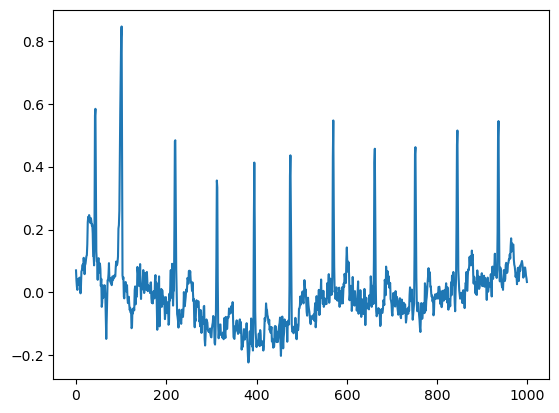

tensor([[[ 0.0210,  0.0400,  0.0600,  ..., -0.0350,  0.0290,  0.1090]],

        [[-0.0010, -0.0260,  0.0150,  ...,  0.2130, -0.0830,  0.1740]],

        [[-0.1130, -0.1020, -0.0780,  ...,  0.5090,  0.4420, -0.0200]],

        ...,

        [[ 0.0730,  0.0680,  0.0500,  ..., -0.0150, -0.0490, -0.0110]],

        [[-0.0910, -0.0690, -0.0200,  ..., -0.0560, -0.0570,  0.0030]],

        [[ 0.0680,  0.0770,  0.0830,  ..., -0.1710, -0.1590, -0.2420]]],
       device='cuda:0')


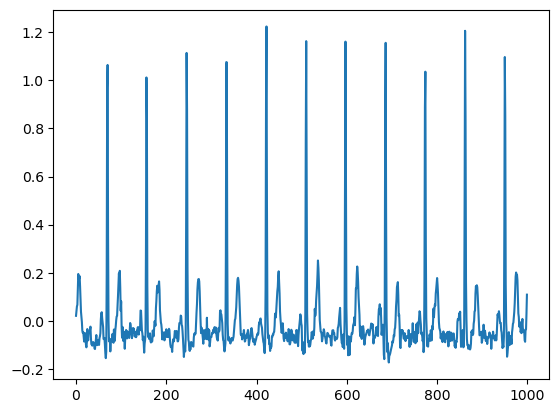

tensor([[[ 0.0570,  0.0680,  0.0720,  ..., -0.0310,  0.0000,  0.1540]],

        [[-0.0390, -0.0370, -0.0440,  ..., -0.0530, -0.0420, -0.0300]],

        [[-0.0050, -0.0060, -0.0070,  ..., -0.0040, -0.1140, -0.1090]],

        ...,

        [[ 0.0190,  0.0080,  0.0010,  ..., -0.1430, -0.2250,  0.0050]],

        [[ 0.0150,  0.0120,  0.0030,  ...,  0.0660,  0.2270,  0.3370]],

        [[ 0.4560,  0.4440,  0.3980,  ..., -0.1050, -0.1210, -0.1240]]],
       device='cuda:0')


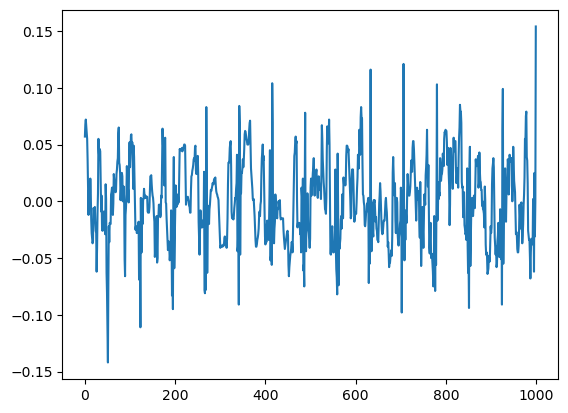

tensor([[[-0.0800, -0.0790, -0.0720,  ..., -0.1750, -0.2380, -0.2340]],

        [[-0.0200, -0.0230, -0.0340,  ..., -0.0750, -0.0640, -0.0400]],

        [[-0.1570, -0.1540, -0.1440,  ..., -0.0540, -0.0210,  0.1830]],

        ...,

        [[-0.0090, -0.0130, -0.0190,  ...,  0.4190,  0.5660, -0.0070]],

        [[ 0.0220,  0.0210,  0.0160,  ..., -0.0240, -0.1090,  0.0350]],

        [[-0.1060, -0.0220,  0.0220,  ..., -0.0670,  0.0470, -0.0070]]],
       device='cuda:0')


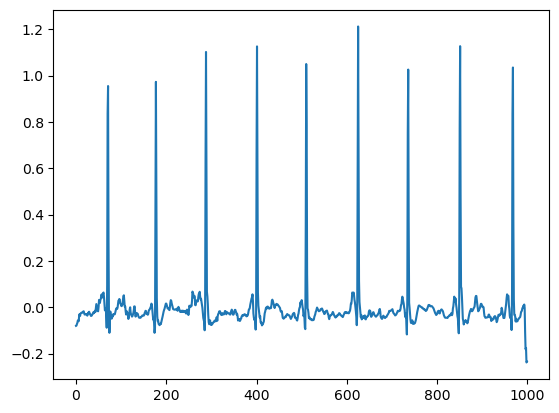

tensor([[[-0.1270, -0.0880, -0.0540,  ..., -0.0140, -0.0020, -0.0140]],

        [[-0.0400, -0.0400, -0.0710,  ..., -0.1030, -0.1030, -0.1210]],

        [[-0.0440,  0.0470,  0.2270,  ...,  0.0330, -0.0230,  0.0330]],

        ...,

        [[-0.1250, -0.1250, -0.1240,  ...,  0.0160,  0.0150,  0.0150]],

        [[-0.0260, -0.0160, -0.0540,  ..., -0.0790, -0.1060, -0.1290]],

        [[-0.1370, -0.1520, -0.1560,  ..., -0.0600, -0.0610, -0.0260]]],
       device='cuda:0')


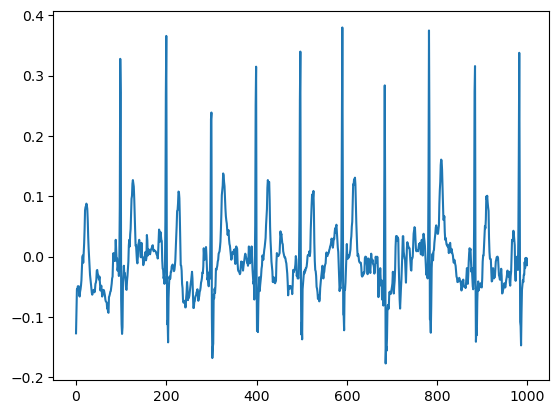

tensor([[[-0.0340, -0.0730, -0.0040,  ..., -0.1840, -0.1830, -0.1790]],

        [[-0.0650, -0.0650, -0.0650,  ..., -0.0490, -0.0360, -0.0420]],

        [[-0.0100,  0.0040,  0.0150,  ..., -0.0620, -0.0630, -0.0820]],

        ...,

        [[-0.0700, -0.0580, -0.0310,  ..., -0.0380, -0.0410, -0.0420]],

        [[ 0.0020,  0.0020, -0.0180,  ..., -0.0990, -0.0920, -0.1120]],

        [[ 0.0940,  0.1190,  0.1700,  ..., -0.0460, -0.0350,  0.0630]]],
       device='cuda:0')


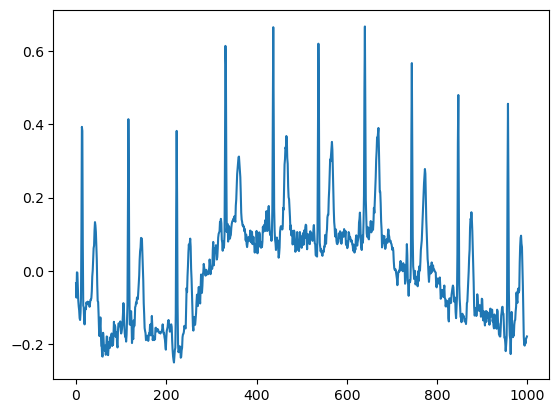

tensor([[[ 0.0350,  0.0370,  0.0460,  ...,  0.0670,  0.0060,  0.0000]],

        [[ 1.5910,  1.2560,  1.9210,  ..., -1.6360, -1.9260, -2.1680]],

        [[-0.3470, -0.3600, -0.3860,  ..., -0.0680, -0.0540, -0.0400]],

        ...,

        [[ 0.0560,  0.0440,  0.0160,  ...,  0.0290, -0.3090, -0.4620]],

        [[-0.0400, -0.0380, -0.0640,  ..., -0.0460, -0.0190,  0.1110]],

        [[-0.0650, -0.0770, -0.0950,  ...,  0.0320,  0.0220,  0.0170]]],
       device='cuda:0')


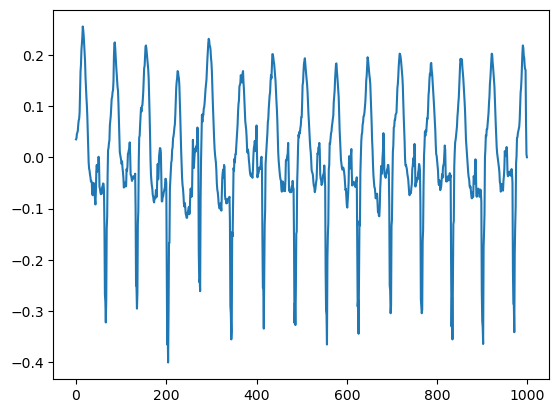

tensor([[[ 0.0030, -0.0200, -0.0240,  ...,  0.0180,  0.0670,  0.0830]],

        [[-0.0200, -0.0050, -0.0040,  ...,  0.3950, -0.0910,  0.1320]],

        [[-0.0330, -0.0470, -0.0410,  ..., -0.0910, -0.1300, -0.0910]],

        ...,

        [[-0.0340, -0.0350, -0.0390,  ...,  0.0040,  0.0010,  0.0060]],

        [[-0.0450, -0.0750, -0.0240,  ..., -0.1210, -0.1230, -0.0560]],

        [[-0.0360, -0.0790, -0.1370,  ...,  0.0370, -0.0030,  0.0340]]],
       device='cuda:0')


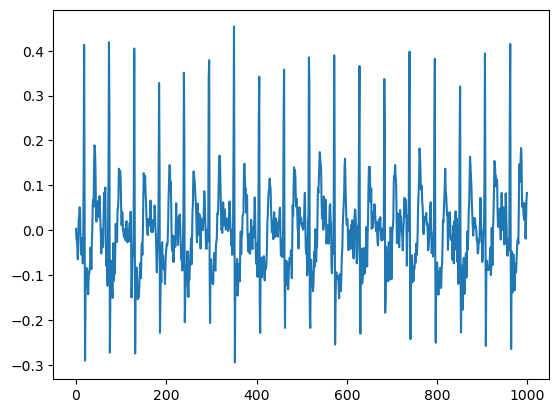

tensor([[[ 0.1230,  0.0330, -0.0530,  ..., -0.0760, -0.0740, -0.0730]],

        [[ 0.0380,  0.0240,  0.0010,  ..., -0.0750, -0.0510, -0.0470]],

        [[-0.0470, -0.0450, -0.0170,  ..., -0.0020, -0.0020,  0.0160]],

        ...,

        [[-0.0430, -0.0340, -0.0210,  ...,  0.0080,  0.0020, -0.0010]],

        [[ 0.0040,  0.0090,  0.0220,  ..., -0.0670, -0.0520, -0.0360]],

        [[-0.0470, -0.0350,  0.0060,  ..., -0.2360, -0.0160,  0.0670]]],
       device='cuda:0')


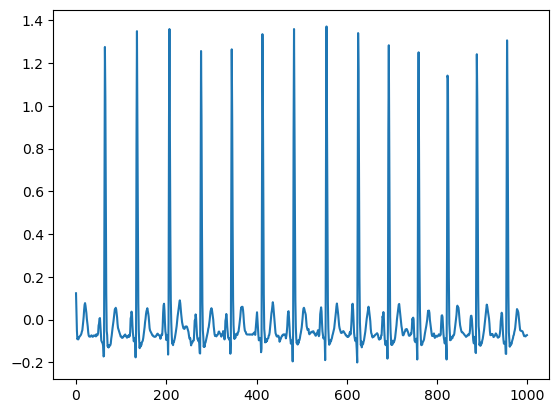

tensor([[[ 0.2090,  0.4420,  0.6760,  ..., -0.0160, -0.0160, -0.0110]],

        [[-1.2360, -1.2210, -1.2220,  ..., -0.1110, -0.1130, -0.0850]],

        [[ 0.3360,  1.3960,  0.0760,  ..., -0.0270, -0.0350, -0.0300]],

        ...,

        [[ 0.0290,  0.0070, -0.0170,  ...,  0.0110,  0.0460,  0.0710]],

        [[-0.0390, -0.0600, -0.0300,  ..., -0.0500, -0.0720, -0.0070]],

        [[ 0.2560,  0.2640,  0.2680,  ..., -0.0260, -0.0260, -0.0210]]],
       device='cuda:0')


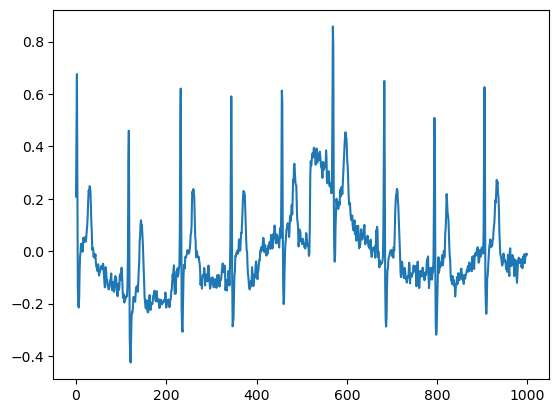

tensor([[[-0.0570, -0.0690, -0.0710,  ...,  0.0250,  0.0040,  0.0620]],

        [[-0.0800, -0.0740, -0.0630,  ..., -0.1640, -0.2200,  0.1530]],

        [[-0.0460, -0.0540, -0.0570,  ...,  0.5670,  0.2790,  0.2640]],

        ...,

        [[-0.0430, -0.0400, -0.0350,  ...,  0.0030,  0.0610,  0.1000]],

        [[-0.0560, -0.0280, -0.0360,  ...,  0.1210, -0.0730,  0.0590]],

        [[ 0.0510,  0.0580,  0.0540,  ..., -0.0470, -0.0500, -0.0640]]],
       device='cuda:0')


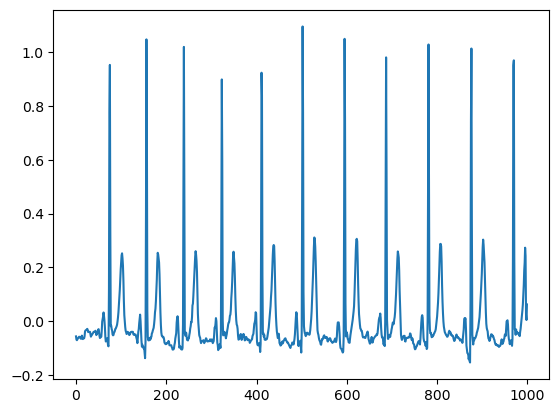

tensor([[[-0.0450, -0.0370, -0.0360,  ..., -0.0630, -0.0450, -0.0370]],

        [[-0.0560, -0.0600, -0.0630,  ..., -0.0760, -0.1270, -0.1340]],

        [[-0.0420, -0.0630, -0.0400,  ...,  0.0250, -0.0240, -0.0470]],

        ...,

        [[-0.0550, -0.0600, -0.0550,  ...,  0.8550,  0.4180,  0.0570]],

        [[ 0.0360,  0.0340,  0.0210,  ..., -0.1820, -0.2870, -0.1580]],

        [[ 0.0210,  0.0410,  0.0550,  ..., -0.0250, -0.0700, -0.0360]]],
       device='cuda:0')


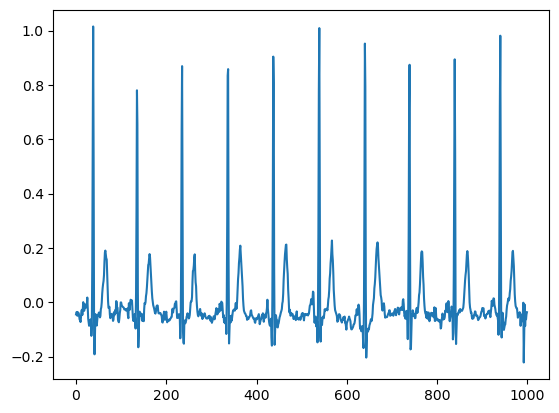

tensor([[[ 0.0300,  0.0350,  0.0390,  ..., -0.0040,  0.0110,  0.0270]],

        [[-0.1630, -0.1650, -0.1740,  ..., -0.0320, -0.0700, -0.0970]],

        [[-0.0090,  0.0010,  0.0040,  ..., -0.0560, -0.0680, -0.0790]],

        ...,

        [[ 0.0010, -0.0140, -0.0160,  ...,  0.0260,  0.0230,  0.0100]],

        [[ 0.1760,  0.1940,  0.2330,  ...,  0.0180,  0.0610,  0.1020]],

        [[ 0.0380,  0.0170, -0.0030,  ..., -0.0170, -0.0200, -0.0150]]],
       device='cuda:0')


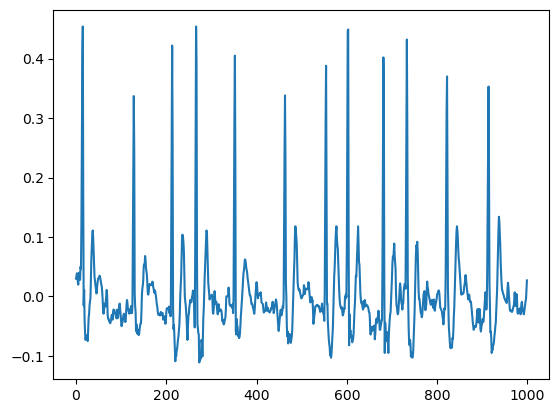

tensor([[[ 0.1090,  0.0970,  0.0540,  ..., -0.0090, -0.0130,  0.0610]],

        [[-0.0540, -0.0530, -0.0480,  ..., -0.0770, -0.0790, -0.1070]],

        [[-0.0400, -0.0450, -0.0570,  ...,  0.2190,  0.1660, -0.1070]],

        ...,

        [[-0.0550, -0.0550, -0.0560,  ...,  0.1430,  0.1900,  0.1740]],

        [[-0.0120, -0.0480, -0.1080,  ..., -0.2020, -0.0490,  0.1570]],

        [[ 0.0540,  0.0660,  0.0890,  ..., -0.0220,  0.0100,  0.0790]]],
       device='cuda:0')


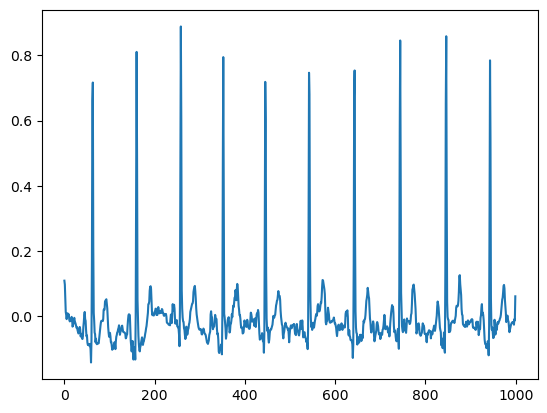

tensor([[[-0.0410, -0.0420, -0.0520,  ..., -0.0310, -0.0290,  0.0160]],

        [[-0.0050, -0.0050, -0.0050,  ...,  0.0340,  0.2440,  0.3880]],

        [[-0.0630, -0.0550, -0.0450,  ..., -0.0500, -0.1410, -0.2820]],

        ...,

        [[ 0.0100,  0.0080,  0.0070,  ...,  0.0170, -0.0080, -0.0110]],

        [[-0.0360, -0.0180, -0.0230,  ...,  0.0330,  0.0160,  0.1290]],

        [[-0.0410, -0.0510, -0.0680,  ..., -0.0480, -0.0890, -0.0810]]],
       device='cuda:0')


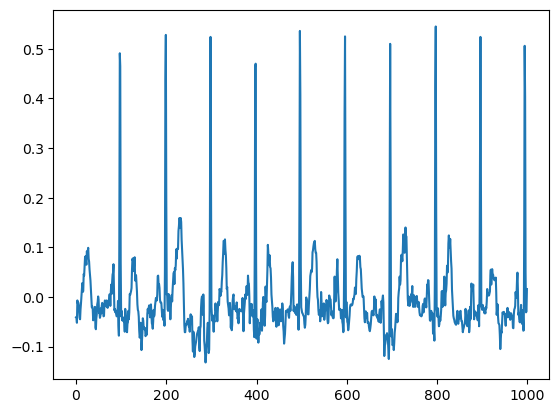

tensor([[[ 0.0830,  0.2850,  0.8280,  ...,  0.1700,  0.6440,  1.0320]],

        [[-0.1330, -0.1240, -0.1260,  ..., -0.0840,  0.4020,  1.0400]],

        [[-0.0110, -0.0170, -0.0200,  ..., -0.0680, -0.0610, -0.0920]],

        ...,

        [[-0.0580, -0.0470, -0.0530,  ..., -0.0930, -0.0120, -0.1030]],

        [[-0.0950, -0.0950, -0.0950,  ..., -0.0710, -0.0380, -0.0430]],

        [[ 0.0000, -0.0160, -0.0270,  ...,  0.0030, -0.0940, -0.3870]]],
       device='cuda:0')


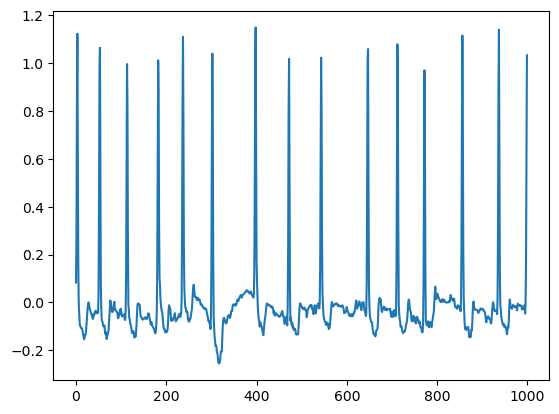

tensor([[[-0.0460, -0.0400, -0.0310,  ..., -0.0570, -0.0700, -0.0870]],

        [[-0.1250, -0.1140, -0.0800,  ..., -0.0150,  0.0070,  0.0470]],

        [[-0.1820, -0.1780, -0.1580,  ..., -0.1340, -0.1370, -0.1270]],

        ...,

        [[ 0.0600,  0.0600,  0.0610,  ...,  0.0190,  0.0340,  0.0050]],

        [[-0.0070, -0.0230, -0.0260,  ..., -0.1810, -0.2060, -0.0550]],

        [[ 0.0100,  0.0260,  0.0460,  ...,  0.0410,  0.0600, -0.0200]]],
       device='cuda:0')


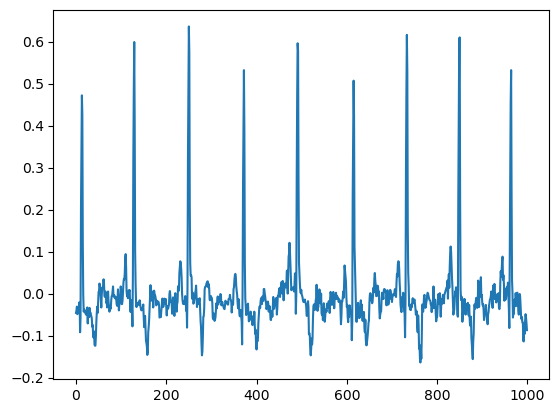

tensor([[[ 0.0080,  0.0260,  0.0290,  ...,  0.0180,  0.0070,  0.0030]],

        [[-0.0140, -0.0030,  0.0030,  ..., -0.1140, -0.0920,  0.0750]],

        [[-0.0040,  0.0030,  0.0140,  ..., -0.0210, -0.0190, -0.0230]],

        ...,

        [[ 0.0380,  0.0780, -0.0140,  ..., -0.1060, -0.0450,  0.4630]],

        [[-0.0570, -0.0410,  0.0030,  ...,  0.0330,  0.0270, -0.0060]],

        [[-0.0490, -0.0490, -0.0590,  ...,  0.0910,  0.1750,  0.1660]]],
       device='cuda:0')


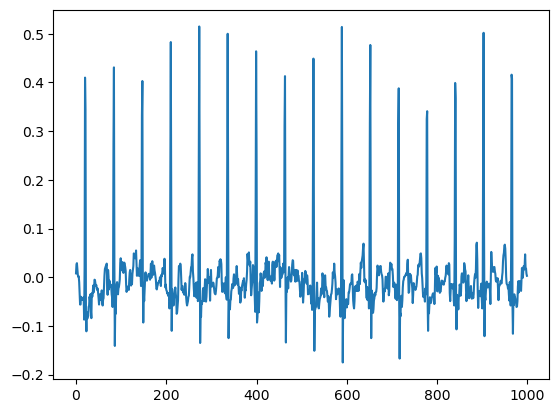

In [48]:
 for i, data in enumerate(dataloader, 0):
            real_data = data[0].to(device)
            print(real_data)
            rd = real_data.detach().cpu().squeeze(1).numpy()[0].transpose()
            plt.plot(rd)
            plt.show()

In [70]:
torch.save(trainer.netD.state_dict(), f"discriminator_2.pth")